TO DO:
1. ~Fix counties for unclaimed~
2. ~Fix counties for unidentified~
3. ~Add line to state_centroids with south pole coordinates and nonsense FIPS code~
4. ~Re-export state-level json (now that county fields have been updated within the databases and American Samoa has been removed)~
    * ~MAKE SURE TO MAP NAS to nonsense FIPS~
5. ~Add to county centroids:~
    * ~55 lines with south pole coordinates and nonsense county FIPS codes (state only_999)~
    * ~1 line with south pole coordinates and nonsense FIPS code (99)~
6. ~Format county data - state name, and then name and county FIPS code, to get GEOID~
7. ~Export county-level json~
    * ~any records with no county get pulled (to separate state FIPS with no county key and nonsense coordinates [south pole])~
    * ~make sure state name included as field with each database, not just FIPS code~
8. ~Re-export summary count JSON (as a few cases have been deleted)~
    * ~Address 21 NAs for Unclaimed?~
9. ~Clean null values for age and gender and sex and race / ethnicity~
10. ~Re-export state and county JSONS~
11. ~Make GeoJSON of state polygons~
12. ~Make GeoJSON of county polygons~
13. ~Make summary GeoJSON with county counts~
14. See how bad city data would be
    * likely need to make all city names .lower
15. re-check city nulls
16. ~change 'other' and 'unsure' to uncertain for race / ethnicity in all databases~
17. ~Add new county name field to city_df based on GEOID (since county names spelled differently)~
18. Re-run all steps (inc. summary county json and county polygons)

In [1]:
# import necessary packages
import pandas as pd
import geopandas as gpd
import numpy as np
import json
import geojson

Notes:
1. Edits to Missing_04182020.csv prior to import
  * Virgin Islands (to United States Virgin Islands), 
  * Tennesse (to Tennessee), and 
  * Northern Mariana Islands (to Commonwealth of the Northern Mariana Islands)
  * Address all county nulls
2. Edits to Unclaimed_0418202.csv priort to import
  * Address all county nulls
3. Edits to Unidentified_04182020.csv prior to import
  * Virgin Islands (to United States Virgin Islands)
  * Address all county nulls
4. Edits to state_centroids_v2 prior to import
  * Add one row with south pole coordinates and nonsense FIPS code(99) - for cases w/ no city, county, or state
5. Edits to county_centroids_v2 prior to import
  * Add one row with south pole coordinates and nonsense FIPS code(99) - for cases w/ no city, county, or state
  * Add 55 rows with south pole coordinates and nonsense county FIPS codes(999) - for cases w/ no city or county

In [2]:
# Read in csvs
city_df = pd.read_csv('cities_v3.csv', encoding='ISO-8859-1', engine='python')

In [3]:
state_centroids_df = pd.read_csv('state_centroids.csv')

In [4]:
# alternate centroids - with None option with FIPS 99
state_centroids_v2_df = pd.read_csv('state_centroids_v2.csv')

In [5]:
county_centroids_df = pd.read_csv('county_centroids.csv', encoding='Windows-1252')

In [6]:
# alternate centroids - with None options with count FIPS 999
county_centroids_v2_df = pd.read_csv('county_centroids_v2.csv', encoding='Windows-1252')

In [7]:
missing_df = pd.read_csv('Missing_04182020.csv')

In [8]:
unclaimed_df = pd.read_csv('Unclaimed_04182020.csv')

In [9]:
unidentified_df = pd.read_csv('Unidentified_04182020.csv')

In [10]:
# check dataframe
state_centroids_v2_df.head()

OBJECTID  STATEFP  STATENS     AFFGEOID  GEOID STUSPS            NAME  \
0         1       28  1779790  0400000US28     28     MS     Mississippi   
1         2       37  1027616  0400000US37     37     NC  North Carolina   
2         3       40  1102857  0400000US40     40     OK        Oklahoma   
3         4       51  1779803  0400000US51     51     VA        Virginia   
4         5       54  1779805  0400000US54     54     WV   West Virginia   

   LSAD         ALAND        AWATER  ORIG_FID     Lon_dd     Lat_dd  
0     0  1.220000e+11  3.926920e+09         1 -89.665425  32.751473  
1     0  1.260000e+11  1.346607e+10         2 -79.380052  35.542238  
2     0  1.780000e+11  3.374588e+09         3 -97.508293  35.583486  
3     0  1.020000e+11  8.528532e+09         4 -78.883285  37.512967  
4     0  6.226647e+10  4.890285e+08         5 -80.613731  38.642587

# Part 1 - Prep data by replacing null attribute values [NOT CITY, COUNTY, OR STATE - Those are addressed later]

### Clean Missing dataframe

##### Check for null values, and replace as needed

In [11]:
# check dataframe
missing_df.head()

Case Number        DLC   Last Name First Name Missing Age        City  \
0      MP2341   5/8/1999    Reynolds      James          28         Opp   
1      MP8522  1/15/2010      Walker     Jeremy          32  Prattville   
2     MP50314  5/16/2018  Keszthelyi      Steve          79     Elberta   
3     MP43187  2/20/2018     johnson      abram          60    fairhope   
4     MP23019  11/5/2012     Shroyer      James          40    Fairhope   

    County    State   Sex          Race / Ethnicity Date Modified  
0  Autauga  Alabama  Male  Black / African American     2/14/2020  
1  Autauga  Alabama  Male         White / Caucasian     7/27/2015  
2  Baldwin  Alabama  Male         White / Caucasian    11/13/2019  
3  Baldwin  Alabama  Male         White / Caucasian     2/13/2020  
4  Baldwin  Alabama  Male         White / Caucasian      2/3/2016

In [12]:
## Check if any rows with null value for DLC [NOTE: Leave as NaN]
missing_attr_df = missing_df.loc[missing_df['DLC'].isnull()]
# len(missing_attr_df)
missing_attr_df

Case Number  DLC Last Name First Name Missing Age    City  County  \
14160     MP56286  NaN   DELAHAY    Glenora         NaN    York    York   
16310     MP54713  NaN    Garcia      Ruben         NaN  Austin  Travis   

              State     Sex   Race / Ethnicity Date Modified  
14160  Pennsylvania  Female  White / Caucasian      4/8/2020  
16310         Texas    Male  Hispanic / Latino      4/3/2020

In [13]:
## Check if any rows with null value for Missing Age
missing_attr_1_df = missing_df.loc[missing_df['Missing Age'].isnull()]
# len(missing_attr_1_df)
missing_attr_1_df

Case Number         DLC   Last Name First Name Missing Age  \
3293      MP35843   7/20/1990    Renteria     Martin         NaN   
4756      MP59185  11/25/1970     Rindahl   Baby Boy         NaN   
5480      MP38301   8/13/2014      Weedon   Nehemiah         NaN   
6208      MP38734   2/15/2016  Richardson       Baby         NaN   
6883        MP566    7/7/1999      Murphy      Sarah         NaN   
7079       MP1284   4/21/2002    Martinez  Priscilla         NaN   
7085       MP1282   7/29/2005      Amaral     Robert         NaN   
7826      MP17063   5/20/2003      Liendo     Fabian         NaN   
12607     MP14033    4/1/1965      Franks  Elizabeth         NaN   
13678     MP20168   12/4/1974       Lloyd    Charles         NaN   
14160     MP56286         NaN     DELAHAY    Glenora         NaN   
16310     MP54713         NaN      Garcia      Ruben         NaN   

               City      County         State     Sex  \
3293      Santa Ana      Orange    California    Male   
4756    Wheat Ridge   Jefferson      Colorado    Male   
5480   Jacksonville       Duval       Florida    Male   
6208        Orlando      Orange       Florida  Female   
6883       Columbus    Muscogee       Georgia  Female   
7079      Honokowai        Maui        Hawaii  Female   
7085          Lanai        Maui        Hawaii    Male   
7826        Wapello      Louisa          Iowa    Male   
12607        Toledo       Lucas          Ohio  Female   
13678         Banks  Washington        Oregon    Male   
14160          York        York  Pennsylvania  Female   
16310        Austin      Travis         Texas    Male   

                           Race / Ethnicity Date Modified  
3293                      Hispanic / Latino    11/21/2019  
4756                      White / Caucasian     1/27/2020  
5480               Black / African American     4/13/2020  
6208               Black / African American      4/9/2020  
6883               Black / African American     10/4/2011  
7079   White / Caucasian, Hispanic / Latino      3/5/2020  
7085                                  Other      3/5/2020  
7826   White / Caucasian, Hispanic / Latino     10/4/2017  
12607                     White / Caucasian      6/1/2018  
13678                     White / Caucasian      3/2/2020  
14160                     White / Caucasian      4/8/2020  
16310                     Hispanic / Latino      4/3/2020

In [14]:
# Re-assign missing age values to be 'Unknown'
missing_df['Missing Age'] = missing_df['Missing Age'].fillna('Unknown')
missing_df.head()

Case Number        DLC   Last Name First Name Missing Age        City  \
0      MP2341   5/8/1999    Reynolds      James          28         Opp   
1      MP8522  1/15/2010      Walker     Jeremy          32  Prattville   
2     MP50314  5/16/2018  Keszthelyi      Steve          79     Elberta   
3     MP43187  2/20/2018     johnson      abram          60    fairhope   
4     MP23019  11/5/2012     Shroyer      James          40    Fairhope   

    County    State   Sex          Race / Ethnicity Date Modified  
0  Autauga  Alabama  Male  Black / African American     2/14/2020  
1  Autauga  Alabama  Male         White / Caucasian     7/27/2015  
2  Baldwin  Alabama  Male         White / Caucasian    11/13/2019  
3  Baldwin  Alabama  Male         White / Caucasian     2/13/2020  
4  Baldwin  Alabama  Male         White / Caucasian      2/3/2016

In [15]:
## Double check re-assigned values
missing_age_test_df = missing_df.loc[missing_df['Missing Age']=='Unknown']
missing_age_test_df
# len(missing_age_test_df)

Case Number         DLC   Last Name First Name Missing Age  \
3293      MP35843   7/20/1990    Renteria     Martin     Unknown   
4756      MP59185  11/25/1970     Rindahl   Baby Boy     Unknown   
5480      MP38301   8/13/2014      Weedon   Nehemiah     Unknown   
6208      MP38734   2/15/2016  Richardson       Baby     Unknown   
6883        MP566    7/7/1999      Murphy      Sarah     Unknown   
7079       MP1284   4/21/2002    Martinez  Priscilla     Unknown   
7085       MP1282   7/29/2005      Amaral     Robert     Unknown   
7826      MP17063   5/20/2003      Liendo     Fabian     Unknown   
12607     MP14033    4/1/1965      Franks  Elizabeth     Unknown   
13678     MP20168   12/4/1974       Lloyd    Charles     Unknown   
14160     MP56286         NaN     DELAHAY    Glenora     Unknown   
16310     MP54713         NaN      Garcia      Ruben     Unknown   

               City      County         State     Sex  \
3293      Santa Ana      Orange    California    Male   
4756    Wheat Ridge   Jefferson      Colorado    Male   
5480   Jacksonville       Duval       Florida    Male   
6208        Orlando      Orange       Florida  Female   
6883       Columbus    Muscogee       Georgia  Female   
7079      Honokowai        Maui        Hawaii  Female   
7085          Lanai        Maui        Hawaii    Male   
7826        Wapello      Louisa          Iowa    Male   
12607        Toledo       Lucas          Ohio  Female   
13678         Banks  Washington        Oregon    Male   
14160          York        York  Pennsylvania  Female   
16310        Austin      Travis         Texas    Male   

                           Race / Ethnicity Date Modified  
3293                      Hispanic / Latino    11/21/2019  
4756                      White / Caucasian     1/27/2020  
5480               Black / African American     4/13/2020  
6208               Black / African American      4/9/2020  
6883               Black / African American     10/4/2011  
7079   White / Caucasian, Hispanic / Latino      3/5/2020  
7085                                  Other      3/5/2020  
7826   White / Caucasian, Hispanic / Latino     10/4/2017  
12607                     White / Caucasian      6/1/2018  
13678                     White / Caucasian      3/2/2020  
14160                     White / Caucasian      4/8/2020  
16310                     Hispanic / Latino      4/3/2020

In [16]:
## Check if any rows with null value for Race / Ethnicity
missing_attr_2_df = missing_df.loc[missing_df['Race / Ethnicity'].isnull()]
# len(missing_attr_2_df)
missing_attr_2_df

Case Number       DLC Last Name First Name Missing Age    City  \
12167     MP55602  4/1/1955  Williams      James          27  Marion   

         County           State   Sex Race / Ethnicity Date Modified  
12167  McDowell  North Carolina  Male              NaN      8/1/2019

In [17]:
# Re-assign missing race / ethnicity values to be 'Uncertain'
missing_df['Race / Ethnicity'] = missing_df['Race / Ethnicity'].fillna('Uncertain')
missing_df.head()

Case Number        DLC   Last Name First Name Missing Age        City  \
0      MP2341   5/8/1999    Reynolds      James          28         Opp   
1      MP8522  1/15/2010      Walker     Jeremy          32  Prattville   
2     MP50314  5/16/2018  Keszthelyi      Steve          79     Elberta   
3     MP43187  2/20/2018     johnson      abram          60    fairhope   
4     MP23019  11/5/2012     Shroyer      James          40    Fairhope   

    County    State   Sex          Race / Ethnicity Date Modified  
0  Autauga  Alabama  Male  Black / African American     2/14/2020  
1  Autauga  Alabama  Male         White / Caucasian     7/27/2015  
2  Baldwin  Alabama  Male         White / Caucasian    11/13/2019  
3  Baldwin  Alabama  Male         White / Caucasian     2/13/2020  
4  Baldwin  Alabama  Male         White / Caucasian      2/3/2016

In [18]:
# Re-assign 'unsure' race / ethnicity values to be 'Uncertain'
missing_df['Race / Ethnicity'] = missing_df['Race / Ethnicity'].str.replace('Unsure','Uncertain')
missing_df.head()

Case Number        DLC   Last Name First Name Missing Age        City  \
0      MP2341   5/8/1999    Reynolds      James          28         Opp   
1      MP8522  1/15/2010      Walker     Jeremy          32  Prattville   
2     MP50314  5/16/2018  Keszthelyi      Steve          79     Elberta   
3     MP43187  2/20/2018     johnson      abram          60    fairhope   
4     MP23019  11/5/2012     Shroyer      James          40    Fairhope   

    County    State   Sex          Race / Ethnicity Date Modified  
0  Autauga  Alabama  Male  Black / African American     2/14/2020  
1  Autauga  Alabama  Male         White / Caucasian     7/27/2015  
2  Baldwin  Alabama  Male         White / Caucasian    11/13/2019  
3  Baldwin  Alabama  Male         White / Caucasian     2/13/2020  
4  Baldwin  Alabama  Male         White / Caucasian      2/3/2016

In [19]:
# Re-assign 'other' race / ethnicity values to be 'Uncertain'
missing_df['Race / Ethnicity'] = missing_df['Race / Ethnicity'].str.replace('Other','Uncertain')
missing_df.head()

Case Number        DLC   Last Name First Name Missing Age        City  \
0      MP2341   5/8/1999    Reynolds      James          28         Opp   
1      MP8522  1/15/2010      Walker     Jeremy          32  Prattville   
2     MP50314  5/16/2018  Keszthelyi      Steve          79     Elberta   
3     MP43187  2/20/2018     johnson      abram          60    fairhope   
4     MP23019  11/5/2012     Shroyer      James          40    Fairhope   

    County    State   Sex          Race / Ethnicity Date Modified  
0  Autauga  Alabama  Male  Black / African American     2/14/2020  
1  Autauga  Alabama  Male         White / Caucasian     7/27/2015  
2  Baldwin  Alabama  Male         White / Caucasian    11/13/2019  
3  Baldwin  Alabama  Male         White / Caucasian     2/13/2020  
4  Baldwin  Alabama  Male         White / Caucasian      2/3/2016

In [20]:
## Double check re-assigned values
missing_race_test_df = missing_df.loc[missing_df['Race / Ethnicity']=='Uncertain']
missing_race_test_df
# len(missing_race_test_df)

Case Number         DLC    Last Name First Name Missing Age  \
252       MP55684  11/22/1979      Hoffman     Ronald          37   
259       MP34147   7/24/2004  Flores-Mata  Valeriano          32   
302       MP24314    4/1/2013    McCormick    Dashawn           5   
306       MP57385   8/27/1985       Garcia      James          26   
307       MP43344   8/17/1981         Hawk     Robert          34   
...           ...         ...          ...        ...         ...   
17399      MP2768    5/9/2009      Collins     Kelsey          18   
17657     MP35299   12/3/2015   Richardson       Chaz          26   
17684     MP41664  11/15/2017       Guyton     Daniel          38   
17827     MP66297  10/14/1975        Theis    Charles          76   
17842     MP50856   8/20/1999       Menger     Dakota           2   

               City          County          State     Sex Race / Ethnicity  \
252    Dutch Harbor  Aleutians West         Alaska    Male        Uncertain   
259        St. Paul  Aleutians West         Alaska    Male        Uncertain   
302       Anchorage       Anchorage         Alaska    Male        Uncertain   
306       Anchorage       Anchorage         Alaska    Male        Uncertain   
307       Anchorage       Anchorage         Alaska    Male        Uncertain   
...             ...             ...            ...     ...              ...   
17399       Everett       Snohomish     Washington  Female        Uncertain   
17657      Surveyor         Raleigh  West Virginia    Male        Uncertain   
17684     Green Bay           Brown      Wisconsin    Male        Uncertain   
17827        Phelps           Vilas      Wisconsin    Male        Uncertain   
17842       Nekoosa            Wood      Wisconsin    Male        Uncertain   

      Date Modified  
252       4/14/2020  
259       4/14/2020  
302       4/14/2020  
306       4/14/2020  
307        2/5/2020  
...             ...  
17399     1/10/2018  
17657    11/22/2019  
17684     1/31/2018  
17827     3/12/2020  
17842      2/5/2019  

[198 rows x 11 columns]

##### Force all names to lowercase then capitalize


In [21]:
# check dataframe
missing_df.head()

Case Number        DLC   Last Name First Name Missing Age        City  \
0      MP2341   5/8/1999    Reynolds      James          28         Opp   
1      MP8522  1/15/2010      Walker     Jeremy          32  Prattville   
2     MP50314  5/16/2018  Keszthelyi      Steve          79     Elberta   
3     MP43187  2/20/2018     johnson      abram          60    fairhope   
4     MP23019  11/5/2012     Shroyer      James          40    Fairhope   

    County    State   Sex          Race / Ethnicity Date Modified  
0  Autauga  Alabama  Male  Black / African American     2/14/2020  
1  Autauga  Alabama  Male         White / Caucasian     7/27/2015  
2  Baldwin  Alabama  Male         White / Caucasian    11/13/2019  
3  Baldwin  Alabama  Male         White / Caucasian     2/13/2020  
4  Baldwin  Alabama  Male         White / Caucasian      2/3/2016

In [22]:
missing_df['Last Name'] = missing_df['Last Name'].str.lower()
missing_df.head()

Case Number        DLC   Last Name First Name Missing Age        City  \
0      MP2341   5/8/1999    reynolds      James          28         Opp   
1      MP8522  1/15/2010      walker     Jeremy          32  Prattville   
2     MP50314  5/16/2018  keszthelyi      Steve          79     Elberta   
3     MP43187  2/20/2018     johnson      abram          60    fairhope   
4     MP23019  11/5/2012     shroyer      James          40    Fairhope   

    County    State   Sex          Race / Ethnicity Date Modified  
0  Autauga  Alabama  Male  Black / African American     2/14/2020  
1  Autauga  Alabama  Male         White / Caucasian     7/27/2015  
2  Baldwin  Alabama  Male         White / Caucasian    11/13/2019  
3  Baldwin  Alabama  Male         White / Caucasian     2/13/2020  
4  Baldwin  Alabama  Male         White / Caucasian      2/3/2016

In [23]:
missing_df['Last Name'] = missing_df['Last Name'].str.capitalize()
missing_df.head()

Case Number        DLC   Last Name First Name Missing Age        City  \
0      MP2341   5/8/1999    Reynolds      James          28         Opp   
1      MP8522  1/15/2010      Walker     Jeremy          32  Prattville   
2     MP50314  5/16/2018  Keszthelyi      Steve          79     Elberta   
3     MP43187  2/20/2018     Johnson      abram          60    fairhope   
4     MP23019  11/5/2012     Shroyer      James          40    Fairhope   

    County    State   Sex          Race / Ethnicity Date Modified  
0  Autauga  Alabama  Male  Black / African American     2/14/2020  
1  Autauga  Alabama  Male         White / Caucasian     7/27/2015  
2  Baldwin  Alabama  Male         White / Caucasian    11/13/2019  
3  Baldwin  Alabama  Male         White / Caucasian     2/13/2020  
4  Baldwin  Alabama  Male         White / Caucasian      2/3/2016

In [24]:
missing_df['First Name'] = missing_df['First Name'].str.lower()
missing_df.head()

Case Number        DLC   Last Name First Name Missing Age        City  \
0      MP2341   5/8/1999    Reynolds      james          28         Opp   
1      MP8522  1/15/2010      Walker     jeremy          32  Prattville   
2     MP50314  5/16/2018  Keszthelyi      steve          79     Elberta   
3     MP43187  2/20/2018     Johnson      abram          60    fairhope   
4     MP23019  11/5/2012     Shroyer      james          40    Fairhope   

    County    State   Sex          Race / Ethnicity Date Modified  
0  Autauga  Alabama  Male  Black / African American     2/14/2020  
1  Autauga  Alabama  Male         White / Caucasian     7/27/2015  
2  Baldwin  Alabama  Male         White / Caucasian    11/13/2019  
3  Baldwin  Alabama  Male         White / Caucasian     2/13/2020  
4  Baldwin  Alabama  Male         White / Caucasian      2/3/2016

In [25]:
missing_df['First Name'] = missing_df['First Name'].str.capitalize()
missing_df.head()

Case Number        DLC   Last Name First Name Missing Age        City  \
0      MP2341   5/8/1999    Reynolds      James          28         Opp   
1      MP8522  1/15/2010      Walker     Jeremy          32  Prattville   
2     MP50314  5/16/2018  Keszthelyi      Steve          79     Elberta   
3     MP43187  2/20/2018     Johnson      Abram          60    fairhope   
4     MP23019  11/5/2012     Shroyer      James          40    Fairhope   

    County    State   Sex          Race / Ethnicity Date Modified  
0  Autauga  Alabama  Male  Black / African American     2/14/2020  
1  Autauga  Alabama  Male         White / Caucasian     7/27/2015  
2  Baldwin  Alabama  Male         White / Caucasian    11/13/2019  
3  Baldwin  Alabama  Male         White / Caucasian     2/13/2020  
4  Baldwin  Alabama  Male         White / Caucasian      2/3/2016

### Clean Unclaimed dataframe

##### Check for null values, and replace as needed

In [26]:
# check dataframe
unclaimed_df.head()

Case Number         DBF  Last Name First Name     Sex   Race / Ethnicity  \
0    UCP64623   12/6/2019       Gray     Steven    Male  White / Caucasian   
1    UCP68260  11/17/2019  Serquinia      Decca  Female  White / Caucasian   
2    UCP58281   1/20/2019    Elliott     Daniel    Male  White / Caucasian   
3    UCP58282    8/4/2018    Nielsen      Selma  Female  White / Caucasian   
4    UCP58460   4/22/2018   Anderson    Michael    Male  White / Caucasian   

       City        County       State Date Modified  
0  Aberdeen  Grays Harbor  Washington     1/24/2020  
1  Aberdeen  Grays Harbor  Washington     4/17/2020  
2  Aberdeen  Grays Harbor  Washington    12/27/2019  
3  Aberdeen  Grays Harbor  Washington    12/27/2019  
4  Aberdeen  Grays Harbor  Washington    12/27/2019

In [27]:
## Check if any rows with null value for DBF [NOTE: Leave as NaN]
unclaimed_attr_df = unclaimed_df.loc[unclaimed_df['DBF'].isnull()]
# len(unclaimed_attr_df)
unclaimed_attr_df

Case Number  DBF         Last Name First Name     Sex  \
337      UCP3089  NaN    De Jesus Gomez       Jose    Male   
603      UCP4222  NaN          Thompson     Rashie  Female   
604      UCP1815  NaN            Torres      Angel    Male   
610      UCP3591  NaN  Funez-Hernandez       Fredi    Male   
1252     UCP5397  NaN              Texi  Salvadore    Male   
...          ...  ...               ...        ...     ...   
8330     UCP1040  NaN             Snell     Gerald    Male   
8331      UCP341  NaN        Brotherton     Quilen    Male   
8332      UCP326  NaN              Bell    Phillip    Male   
8333      UCP345  NaN        Buonantony      Elena  Female   
8334      UCP371  NaN          Callison      James    Male   

                          Race / Ethnicity       City      County  \
337                              Uncertain   Avondale    Maricopa   
603               Black / African American     Boston     Suffolk   
604                              Uncertain     Boston     Suffolk   
610   White / Caucasian, Hispanic / Latino  Brentwood  Williamson   
1252  White / Caucasian, Hispanic / Latino      Bronx       Bronx   
...                                    ...        ...         ...   
8330                                   NaN        NaN       Wayne   
8331                                   NaN        NaN     Spokane   
8332                                   NaN        NaN     Spokane   
8333                                   NaN        NaN     Spokane   
8334                                   NaN        NaN       Adams   

              State Date Modified  
337         Arizona      2/7/2017  
603   Massachusetts     4/23/2019  
604   Massachusetts    12/14/2015  
610       Tennessee     4/21/2017  
1252       New York    11/21/2018  
...             ...           ...  
8330       Michigan     3/19/2020  
8331     Washington     4/14/2020  
8332     Washington     4/14/2020  
8333     Washington     4/14/2020  
8334     Washington     4/14/2020  

[953 rows x 10 columns]

In [28]:
## Check if any rows with null value for last name
unclaimed_attr_1_df = unclaimed_df.loc[unclaimed_df['Last Name'].isnull()]
# len(unclaimed_attr_1_df)
unclaimed_attr_1_df

Case Number  DBF Last Name First Name  Sex Race / Ethnicity City  \
7979    UCP62756  NaN       NaN        NaN  NaN              NaN  NaN   
8292    UCP62750  NaN       NaN        NaN  NaN              NaN  NaN   

              County       State Date Modified  
7979  San Bernardino  California    12/19/2019  
8292  San Bernardino  California    12/19/2019

In [29]:
# Re-assign missing last name values to be 'Unknown'
unclaimed_df['Last Name'] = unclaimed_df['Last Name'].fillna('Unknown')
unclaimed_df.head()

Case Number         DBF  Last Name First Name     Sex   Race / Ethnicity  \
0    UCP64623   12/6/2019       Gray     Steven    Male  White / Caucasian   
1    UCP68260  11/17/2019  Serquinia      Decca  Female  White / Caucasian   
2    UCP58281   1/20/2019    Elliott     Daniel    Male  White / Caucasian   
3    UCP58282    8/4/2018    Nielsen      Selma  Female  White / Caucasian   
4    UCP58460   4/22/2018   Anderson    Michael    Male  White / Caucasian   

       City        County       State Date Modified  
0  Aberdeen  Grays Harbor  Washington     1/24/2020  
1  Aberdeen  Grays Harbor  Washington     4/17/2020  
2  Aberdeen  Grays Harbor  Washington    12/27/2019  
3  Aberdeen  Grays Harbor  Washington    12/27/2019  
4  Aberdeen  Grays Harbor  Washington    12/27/2019

In [30]:
## Double check re-assigned values
unclaimed_lname_test_df = unclaimed_df.loc[unclaimed_df['Last Name']=='Unknown']
unclaimed_lname_test_df
# len(unclaimed_lname_test_df)

Case Number  DBF Last Name First Name  Sex Race / Ethnicity City  \
7979    UCP62756  NaN   Unknown        NaN  NaN              NaN  NaN   
8292    UCP62750  NaN   Unknown        NaN  NaN              NaN  NaN   

              County       State Date Modified  
7979  San Bernardino  California    12/19/2019  
8292  San Bernardino  California    12/19/2019

In [31]:
## Check if any rows with null value for first name
unclaimed_attr_2_df = unclaimed_df.loc[unclaimed_df['First Name'].isnull()]
# len(unclaimed_attr_2_df)
unclaimed_attr_2_df

Case Number  DBF  Last Name First Name  Sex Race / Ethnicity City  \
7979    UCP62756  NaN    Unknown        NaN  NaN              NaN  NaN   
8195    UCP66063  NaN  Goldstein        NaN  NaN              NaN  NaN   
8292    UCP62750  NaN    Unknown        NaN  NaN              NaN  NaN   

              County       State Date Modified  
7979  San Bernardino  California    12/19/2019  
8195          Yakima  Washington     3/26/2020  
8292  San Bernardino  California    12/19/2019

In [32]:
# Re-assign missing first name values to be 'Unknown'
unclaimed_df['First Name'] = unclaimed_df['First Name'].fillna('Unknown')
unclaimed_df.head()

Case Number         DBF  Last Name First Name     Sex   Race / Ethnicity  \
0    UCP64623   12/6/2019       Gray     Steven    Male  White / Caucasian   
1    UCP68260  11/17/2019  Serquinia      Decca  Female  White / Caucasian   
2    UCP58281   1/20/2019    Elliott     Daniel    Male  White / Caucasian   
3    UCP58282    8/4/2018    Nielsen      Selma  Female  White / Caucasian   
4    UCP58460   4/22/2018   Anderson    Michael    Male  White / Caucasian   

       City        County       State Date Modified  
0  Aberdeen  Grays Harbor  Washington     1/24/2020  
1  Aberdeen  Grays Harbor  Washington     4/17/2020  
2  Aberdeen  Grays Harbor  Washington    12/27/2019  
3  Aberdeen  Grays Harbor  Washington    12/27/2019  
4  Aberdeen  Grays Harbor  Washington    12/27/2019

In [33]:
## Double check re-assigned values
unclaimed_fname_test_df = unclaimed_df.loc[unclaimed_df['First Name']=='Unknown']
unclaimed_fname_test_df
# len(unclaimed_fname_test_df)

Case Number  DBF  Last Name First Name  Sex Race / Ethnicity City  \
7979    UCP62756  NaN    Unknown    Unknown  NaN              NaN  NaN   
8195    UCP66063  NaN  Goldstein    Unknown  NaN              NaN  NaN   
8292    UCP62750  NaN    Unknown    Unknown  NaN              NaN  NaN   

              County       State Date Modified  
7979  San Bernardino  California    12/19/2019  
8195          Yakima  Washington     3/26/2020  
8292  San Bernardino  California    12/19/2019

In [34]:
## Check if any rows with null value for sex
unclaimed_attr_3_df = unclaimed_df.loc[unclaimed_df['Sex'].isnull()]
# len(unclaimed_attr_3_df)
unclaimed_attr_3_df

Case Number         DBF      Last Name First Name  Sex Race / Ethnicity  \
1247     UCP1185  10/23/2014        Sanchez    Egberto  NaN              NaN   
2372     UCP3178         NaN           Lang      Thanh  NaN              NaN   
4404     UCP1177   3/20/2015        Etienne    Luzanne  NaN              NaN   
4809      UCP379  10/27/2001        Chapman     Andees  NaN              NaN   
6587    UCP63503   1/22/2016     Vanderbeck     Robert  NaN              NaN   
...          ...         ...            ...        ...  ...              ...   
8315    UCP62761         NaN      Sepulveda    Raymond  NaN              NaN   
8316    UCP62762         NaN           Cruz     Sergio  NaN              NaN   
8317    UCP62738         NaN        Hartman    William  NaN              NaN   
8321     UCP1027         NaN           Miah     Mashuk  NaN              NaN   
8329     UCP1048         NaN  Haraszkiewicz  Kazimierz  NaN              NaN   

          City          County       State Date Modified  
1247     Bronx           Bronx    New York     5/30/2017  
2372  Highland  San Bernardino  California      3/2/2017  
4404    Queens          Queens    New York      5/7/2015  
4809   Spokane         Spokane  Washington     4/14/2020  
6587       NaN  San Bernardino  California    12/19/2019  
...        ...             ...         ...           ...  
8315       NaN  San Bernardino  California    12/19/2019  
8316       NaN  San Bernardino  California    12/19/2019  
8317       NaN  San Bernardino  California    12/19/2019  
8321       NaN           Wayne    Michigan     3/19/2020  
8329       NaN           Wayne    Michigan     3/19/2020  

[1063 rows x 10 columns]

In [35]:
# Re-assign missing sex values to be 'Unknown'
unclaimed_df['Sex'] = unclaimed_df['Sex'].fillna('Unknown')
unclaimed_df.head()

Case Number         DBF  Last Name First Name     Sex   Race / Ethnicity  \
0    UCP64623   12/6/2019       Gray     Steven    Male  White / Caucasian   
1    UCP68260  11/17/2019  Serquinia      Decca  Female  White / Caucasian   
2    UCP58281   1/20/2019    Elliott     Daniel    Male  White / Caucasian   
3    UCP58282    8/4/2018    Nielsen      Selma  Female  White / Caucasian   
4    UCP58460   4/22/2018   Anderson    Michael    Male  White / Caucasian   

       City        County       State Date Modified  
0  Aberdeen  Grays Harbor  Washington     1/24/2020  
1  Aberdeen  Grays Harbor  Washington     4/17/2020  
2  Aberdeen  Grays Harbor  Washington    12/27/2019  
3  Aberdeen  Grays Harbor  Washington    12/27/2019  
4  Aberdeen  Grays Harbor  Washington    12/27/2019

In [36]:
## Double check re-assigned values
unclaimed_sex_test_df = unclaimed_df.loc[unclaimed_df['Sex']=='Unknown']
unclaimed_sex_test_df
# len(unclaimed_sex_test_df)

Case Number         DBF      Last Name First Name      Sex  \
1247     UCP1185  10/23/2014        Sanchez    Egberto  Unknown   
2372     UCP3178         NaN           Lang      Thanh  Unknown   
4404     UCP1177   3/20/2015        Etienne    Luzanne  Unknown   
4809      UCP379  10/27/2001        Chapman     Andees  Unknown   
6587    UCP63503   1/22/2016     Vanderbeck     Robert  Unknown   
...          ...         ...            ...        ...      ...   
8315    UCP62761         NaN      Sepulveda    Raymond  Unknown   
8316    UCP62762         NaN           Cruz     Sergio  Unknown   
8317    UCP62738         NaN        Hartman    William  Unknown   
8321     UCP1027         NaN           Miah     Mashuk  Unknown   
8329     UCP1048         NaN  Haraszkiewicz  Kazimierz  Unknown   

     Race / Ethnicity      City          County       State Date Modified  
1247              NaN     Bronx           Bronx    New York     5/30/2017  
2372              NaN  Highland  San Bernardino  California      3/2/2017  
4404              NaN    Queens          Queens    New York      5/7/2015  
4809              NaN   Spokane         Spokane  Washington     4/14/2020  
6587              NaN       NaN  San Bernardino  California    12/19/2019  
...               ...       ...             ...         ...           ...  
8315              NaN       NaN  San Bernardino  California    12/19/2019  
8316              NaN       NaN  San Bernardino  California    12/19/2019  
8317              NaN       NaN  San Bernardino  California    12/19/2019  
8321              NaN       NaN           Wayne    Michigan     3/19/2020  
8329              NaN       NaN           Wayne    Michigan     3/19/2020  

[1063 rows x 10 columns]

In [37]:
## Check if any rows with null value for race / ethnicity
unclaimed_attr_4_df = unclaimed_df.loc[unclaimed_df['Race / Ethnicity'].isnull()]
# len(unclaimed_attr_4_df)
unclaimed_attr_4_df

Case Number         DBF      Last Name First Name     Sex  \
22       UCP5386    4/7/2016       Abusaiba      Helal    Male   
324       UCP146   6/18/2010       Martinez       Jose    Male   
346      UCP3430   8/16/2016         Busang      Harry    Male   
478      UCP3395  11/26/2014        Kennedy     Bobbie  Female   
479      UCP3391   8/16/2014  Flint-Higgins      Quade    Male   
...          ...         ...            ...        ...     ...   
8330     UCP1040         NaN          Snell     Gerald    Male   
8331      UCP341         NaN     Brotherton     Quilen    Male   
8332      UCP326         NaN           Bell    Phillip    Male   
8333      UCP345         NaN     Buonantony      Elena  Female   
8334      UCP371         NaN       Callison      James    Male   

     Race / Ethnicity         City   County       State Date Modified  
22                NaN  Albuquerque    Union  New Mexico      5/5/2018  
324               NaN      Atlanta   Fulton     Georgia     4/19/2019  
346               NaN      Bellvue   Blaine       Idaho      4/5/2017  
478               NaN        Boise      Ada       Idaho      4/3/2017  
479               NaN        Boise      Ada       Idaho      4/3/2017  
...               ...          ...      ...         ...           ...  
8330              NaN          NaN    Wayne    Michigan     3/19/2020  
8331              NaN          NaN  Spokane  Washington     4/14/2020  
8332              NaN          NaN  Spokane  Washington     4/14/2020  
8333              NaN          NaN  Spokane  Washington     4/14/2020  
8334              NaN          NaN    Adams  Washington     4/14/2020  

[1556 rows x 10 columns]

In [38]:
# Re-assign missing race / ethnicity values to be 'Uncertain'
unclaimed_df['Race / Ethnicity'] = unclaimed_df['Race / Ethnicity'].fillna('Uncertain')
unclaimed_df.head()

Case Number         DBF  Last Name First Name     Sex   Race / Ethnicity  \
0    UCP64623   12/6/2019       Gray     Steven    Male  White / Caucasian   
1    UCP68260  11/17/2019  Serquinia      Decca  Female  White / Caucasian   
2    UCP58281   1/20/2019    Elliott     Daniel    Male  White / Caucasian   
3    UCP58282    8/4/2018    Nielsen      Selma  Female  White / Caucasian   
4    UCP58460   4/22/2018   Anderson    Michael    Male  White / Caucasian   

       City        County       State Date Modified  
0  Aberdeen  Grays Harbor  Washington     1/24/2020  
1  Aberdeen  Grays Harbor  Washington     4/17/2020  
2  Aberdeen  Grays Harbor  Washington    12/27/2019  
3  Aberdeen  Grays Harbor  Washington    12/27/2019  
4  Aberdeen  Grays Harbor  Washington    12/27/2019

In [39]:
# Re-assign 'unsure' race / ethnicity values to be 'Uncertain'
unclaimed_df['Race / Ethnicity'] = unclaimed_df['Race / Ethnicity'].str.replace('Unsure','Uncertain')
unclaimed_df.head()

Case Number         DBF  Last Name First Name     Sex   Race / Ethnicity  \
0    UCP64623   12/6/2019       Gray     Steven    Male  White / Caucasian   
1    UCP68260  11/17/2019  Serquinia      Decca  Female  White / Caucasian   
2    UCP58281   1/20/2019    Elliott     Daniel    Male  White / Caucasian   
3    UCP58282    8/4/2018    Nielsen      Selma  Female  White / Caucasian   
4    UCP58460   4/22/2018   Anderson    Michael    Male  White / Caucasian   

       City        County       State Date Modified  
0  Aberdeen  Grays Harbor  Washington     1/24/2020  
1  Aberdeen  Grays Harbor  Washington     4/17/2020  
2  Aberdeen  Grays Harbor  Washington    12/27/2019  
3  Aberdeen  Grays Harbor  Washington    12/27/2019  
4  Aberdeen  Grays Harbor  Washington    12/27/2019

In [40]:
# Re-assign 'other' race / ethnicity values to be 'Uncertain'
unclaimed_df['Race / Ethnicity'] = unclaimed_df['Race / Ethnicity'].str.replace('Other','Uncertain')
unclaimed_df.head()

Case Number         DBF  Last Name First Name     Sex   Race / Ethnicity  \
0    UCP64623   12/6/2019       Gray     Steven    Male  White / Caucasian   
1    UCP68260  11/17/2019  Serquinia      Decca  Female  White / Caucasian   
2    UCP58281   1/20/2019    Elliott     Daniel    Male  White / Caucasian   
3    UCP58282    8/4/2018    Nielsen      Selma  Female  White / Caucasian   
4    UCP58460   4/22/2018   Anderson    Michael    Male  White / Caucasian   

       City        County       State Date Modified  
0  Aberdeen  Grays Harbor  Washington     1/24/2020  
1  Aberdeen  Grays Harbor  Washington     4/17/2020  
2  Aberdeen  Grays Harbor  Washington    12/27/2019  
3  Aberdeen  Grays Harbor  Washington    12/27/2019  
4  Aberdeen  Grays Harbor  Washington    12/27/2019

In [41]:
## Double check re-assigned values
unclaimed_race_test_df = unclaimed_df.loc[unclaimed_df['Race / Ethnicity']=='Uncertain']
unclaimed_race_test_df
# len(unclaimed_race_test_df)

Case Number         DBF   Last Name First Name     Sex Race / Ethnicity  \
22       UCP5386    4/7/2016    Abusaiba      Helal    Male        Uncertain   
61       UCP3909    2/3/2009      Herlem     Ronald    Male        Uncertain   
110      UCP3670    9/1/2006     Jackson      Elias    Male        Uncertain   
127      UCP3545   2/28/2005       Adams     Donald    Male        Uncertain   
129      UCP3352  11/14/2004       Nunez   Benjamin    Male        Uncertain   
...          ...         ...         ...        ...     ...              ...   
8330     UCP1040         NaN       Snell     Gerald    Male        Uncertain   
8331      UCP341         NaN  Brotherton     Quilen    Male        Uncertain   
8332      UCP326         NaN        Bell    Phillip    Male        Uncertain   
8333      UCP345         NaN  Buonantony      Elena  Female        Uncertain   
8334      UCP371         NaN    Callison      James    Male        Uncertain   

             City   County       State Date Modified  
22    Albuquerque    Union  New Mexico      5/5/2018  
61        Anaheim   Orange  California     5/11/2017  
110       Anaheim   Orange  California      5/2/2017  
127       Anaheim   Orange  California     4/20/2017  
129       Anaheim   Orange  California     3/30/2017  
...           ...      ...         ...           ...  
8330          NaN    Wayne    Michigan     3/19/2020  
8331          NaN  Spokane  Washington     4/14/2020  
8332          NaN  Spokane  Washington     4/14/2020  
8333          NaN  Spokane  Washington     4/14/2020  
8334          NaN    Adams  Washington     4/14/2020  

[2177 rows x 10 columns]

##### Force all names to lowercase, then capitalize

In [42]:
# check dataframe
unclaimed_df.head()

Case Number         DBF  Last Name First Name     Sex   Race / Ethnicity  \
0    UCP64623   12/6/2019       Gray     Steven    Male  White / Caucasian   
1    UCP68260  11/17/2019  Serquinia      Decca  Female  White / Caucasian   
2    UCP58281   1/20/2019    Elliott     Daniel    Male  White / Caucasian   
3    UCP58282    8/4/2018    Nielsen      Selma  Female  White / Caucasian   
4    UCP58460   4/22/2018   Anderson    Michael    Male  White / Caucasian   

       City        County       State Date Modified  
0  Aberdeen  Grays Harbor  Washington     1/24/2020  
1  Aberdeen  Grays Harbor  Washington     4/17/2020  
2  Aberdeen  Grays Harbor  Washington    12/27/2019  
3  Aberdeen  Grays Harbor  Washington    12/27/2019  
4  Aberdeen  Grays Harbor  Washington    12/27/2019

In [43]:
unclaimed_df['Last Name'] = unclaimed_df['Last Name'].str.lower()
unclaimed_df.head()

Case Number         DBF  Last Name First Name     Sex   Race / Ethnicity  \
0    UCP64623   12/6/2019       gray     Steven    Male  White / Caucasian   
1    UCP68260  11/17/2019  serquinia      Decca  Female  White / Caucasian   
2    UCP58281   1/20/2019    elliott     Daniel    Male  White / Caucasian   
3    UCP58282    8/4/2018    nielsen      Selma  Female  White / Caucasian   
4    UCP58460   4/22/2018   anderson    Michael    Male  White / Caucasian   

       City        County       State Date Modified  
0  Aberdeen  Grays Harbor  Washington     1/24/2020  
1  Aberdeen  Grays Harbor  Washington     4/17/2020  
2  Aberdeen  Grays Harbor  Washington    12/27/2019  
3  Aberdeen  Grays Harbor  Washington    12/27/2019  
4  Aberdeen  Grays Harbor  Washington    12/27/2019

In [44]:
unclaimed_df['Last Name'] = unclaimed_df['Last Name'].str.capitalize()
unclaimed_df.head()

Case Number         DBF  Last Name First Name     Sex   Race / Ethnicity  \
0    UCP64623   12/6/2019       Gray     Steven    Male  White / Caucasian   
1    UCP68260  11/17/2019  Serquinia      Decca  Female  White / Caucasian   
2    UCP58281   1/20/2019    Elliott     Daniel    Male  White / Caucasian   
3    UCP58282    8/4/2018    Nielsen      Selma  Female  White / Caucasian   
4    UCP58460   4/22/2018   Anderson    Michael    Male  White / Caucasian   

       City        County       State Date Modified  
0  Aberdeen  Grays Harbor  Washington     1/24/2020  
1  Aberdeen  Grays Harbor  Washington     4/17/2020  
2  Aberdeen  Grays Harbor  Washington    12/27/2019  
3  Aberdeen  Grays Harbor  Washington    12/27/2019  
4  Aberdeen  Grays Harbor  Washington    12/27/2019

In [45]:
unclaimed_df['First Name'] = unclaimed_df['First Name'].str.lower()
unclaimed_df.head()

Case Number         DBF  Last Name First Name     Sex   Race / Ethnicity  \
0    UCP64623   12/6/2019       Gray     steven    Male  White / Caucasian   
1    UCP68260  11/17/2019  Serquinia      decca  Female  White / Caucasian   
2    UCP58281   1/20/2019    Elliott     daniel    Male  White / Caucasian   
3    UCP58282    8/4/2018    Nielsen      selma  Female  White / Caucasian   
4    UCP58460   4/22/2018   Anderson    michael    Male  White / Caucasian   

       City        County       State Date Modified  
0  Aberdeen  Grays Harbor  Washington     1/24/2020  
1  Aberdeen  Grays Harbor  Washington     4/17/2020  
2  Aberdeen  Grays Harbor  Washington    12/27/2019  
3  Aberdeen  Grays Harbor  Washington    12/27/2019  
4  Aberdeen  Grays Harbor  Washington    12/27/2019

In [46]:
unclaimed_df['First Name'] = unclaimed_df['First Name'].str.capitalize()
unclaimed_df.head()

Case Number         DBF  Last Name First Name     Sex   Race / Ethnicity  \
0    UCP64623   12/6/2019       Gray     Steven    Male  White / Caucasian   
1    UCP68260  11/17/2019  Serquinia      Decca  Female  White / Caucasian   
2    UCP58281   1/20/2019    Elliott     Daniel    Male  White / Caucasian   
3    UCP58282    8/4/2018    Nielsen      Selma  Female  White / Caucasian   
4    UCP58460   4/22/2018   Anderson    Michael    Male  White / Caucasian   

       City        County       State Date Modified  
0  Aberdeen  Grays Harbor  Washington     1/24/2020  
1  Aberdeen  Grays Harbor  Washington     4/17/2020  
2  Aberdeen  Grays Harbor  Washington    12/27/2019  
3  Aberdeen  Grays Harbor  Washington    12/27/2019  
4  Aberdeen  Grays Harbor  Washington    12/27/2019

### Clean Unidentified dataframe

##### Check for null values, and replace as needed

In [47]:
# check dataframe
unidentified_df.head()

Case Number        DBF  Age From  Age To        City   County    State  \
0     UP51903  3/30/1986       NaN     NaN     Marbury  Autauga  Alabama   
1      UP5000  9/29/2007      40.0    60.0  Prattville  Autauga  Alabama   
2      UP6519   1/6/2006      45.0    59.0     Elberta  Baldwin  Alabama   
3     UP55409  3/26/2000       NaN     NaN         NaN  Baldwin  Alabama   
4     UP13483  3/27/1961      14.0    17.0         NaN     Bibb  Alabama   

      Sex                                   Race / Ethnicity Date Modified  
0  Female                                  White / Caucasian     1/28/2020  
1  Female                           Black / African American     8/12/2019  
2    Male                                  White / Caucasian    10/24/2018  
3    Male  White / Caucasian, Asian, American Indian / Al...     2/13/2020  
4    Male                                  White / Caucasian     3/25/2019

In [48]:
## Check if any rows with null value for DBF [NOTE: Leave as NaN]
unidentified_attr_df = unidentified_df.loc[unidentified_df['DBF'].isnull()]
# len(unidentified_attr_df)
unidentified_attr_df

Case Number  DBF  Age From  Age To City  County       State   Sex  \
1621     UP54136  NaN       NaN     NaN  NaN    Pima     Arizona   NaN   
3718     UP17837  NaN      65.0    70.0  NaN  Orange  California  Male   

       Race / Ethnicity Date Modified  
1621          Uncertain     1/16/2020  
3718  White / Caucasian     11/1/2018

In [49]:
## Check if any rows with null value for Age From
unidentified_attr_1_df = unidentified_df.loc[unidentified_df['Age From'].isnull()]
# len(unidentified_attr_1_df)
unidentified_attr_1_df

Case Number         DBF  Age From  Age To        City     County  \
0         UP51903   3/30/1986       NaN     NaN     Marbury    Autauga   
3         UP55409   3/26/2000       NaN     NaN         NaN    Baldwin   
34        UP51245  11/29/2017       NaN     NaN  Huntsville    Madison   
35        UP11867   12/8/2013       NaN     NaN  Huntsville    Madison   
36        UP51243  11/29/2017       NaN     NaN  Huntsville    Madison   
...           ...         ...       ...     ...         ...        ...   
13206     UP52045   6/14/2018       NaN     NaN     Cyclone    Wyoming   
13216     UP13695   11/9/1989       NaN     NaN       Paris    Kenosha   
13240     UP11611    6/5/2008       NaN     NaN     Baraboo       Sauk   
13248      UP7631   7/10/1973       NaN     NaN    Waukesha   Waukesha   
13251     UP58757  12/16/1970       NaN     NaN      Neenah  Winnebago   

               State     Sex  \
0            Alabama  Female   
3            Alabama    Male   
34           Alabama    Male   
35           Alabama    Male   
36           Alabama  Female   
...              ...     ...   
13206  West Virginia    Male   
13216      Wisconsin    Male   
13240      Wisconsin    Male   
13248      Wisconsin    Male   
13251      Wisconsin  Female   

                                        Race / Ethnicity Date Modified  
0                                      White / Caucasian     1/28/2020  
3      White / Caucasian, Asian, American Indian / Al...     2/13/2020  
34                                             Uncertain    12/27/2019  
35                                     White / Caucasian     11/9/2018  
36                                             Uncertain    12/27/2019  
...                                                  ...           ...  
13206                                          Uncertain     1/15/2020  
13216                                  White / Caucasian     4/11/2017  
13240                                          Uncertain    11/22/2013  
13248                                  White / Caucasian     11/9/2013  
13251                                  White / Caucasian     1/10/2020  

[1602 rows x 10 columns]

In [50]:
# Re-assign missing age from values to be 0
unidentified_df['Age From'] = unidentified_df['Age From'].fillna(0)
unidentified_df.head()

Case Number        DBF  Age From  Age To        City   County    State  \
0     UP51903  3/30/1986       0.0     NaN     Marbury  Autauga  Alabama   
1      UP5000  9/29/2007      40.0    60.0  Prattville  Autauga  Alabama   
2      UP6519   1/6/2006      45.0    59.0     Elberta  Baldwin  Alabama   
3     UP55409  3/26/2000       0.0     NaN         NaN  Baldwin  Alabama   
4     UP13483  3/27/1961      14.0    17.0         NaN     Bibb  Alabama   

      Sex                                   Race / Ethnicity Date Modified  
0  Female                                  White / Caucasian     1/28/2020  
1  Female                           Black / African American     8/12/2019  
2    Male                                  White / Caucasian    10/24/2018  
3    Male  White / Caucasian, Asian, American Indian / Al...     2/13/2020  
4    Male                                  White / Caucasian     3/25/2019

In [51]:
## Double check re-assigned values
unidentified_agefrom_test_df = unidentified_df.loc[unidentified_df['Age From']==0]
unidentified_agefrom_test_df
# len(unidentified_agefrom_test_df)

Case Number         DBF  Age From  Age To        City     County  \
0         UP51903   3/30/1986       0.0     NaN     Marbury    Autauga   
3         UP55409   3/26/2000       0.0     NaN         NaN    Baldwin   
34        UP51245  11/29/2017       0.0     NaN  Huntsville    Madison   
35        UP11867   12/8/2013       0.0     NaN  Huntsville    Madison   
36        UP51243  11/29/2017       0.0     NaN  Huntsville    Madison   
...           ...         ...       ...     ...         ...        ...   
13236     UP13617  11/14/2014       0.0     1.0  West Allis  Milwaukee   
13240     UP11611    6/5/2008       0.0     NaN     Baraboo       Sauk   
13248      UP7631   7/10/1973       0.0     NaN    Waukesha   Waukesha   
13251     UP58757  12/16/1970       0.0     NaN      Neenah  Winnebago   
13256     UP10781   2/28/1988       0.0     0.0    Cheyenne    Laramie   

           State     Sex                                   Race / Ethnicity  \
0        Alabama  Female                                  White / Caucasian   
3        Alabama    Male  White / Caucasian, Asian, American Indian / Al...   
34       Alabama    Male                                          Uncertain   
35       Alabama    Male                                  White / Caucasian   
36       Alabama  Female                                          Uncertain   
...          ...     ...                                                ...   
13236  Wisconsin    Male                                          Uncertain   
13240  Wisconsin    Male                                          Uncertain   
13248  Wisconsin    Male                                  White / Caucasian   
13251  Wisconsin  Female                                  White / Caucasian   
13256    Wyoming    Male                                  White / Caucasian   

      Date Modified  
0         1/28/2020  
3         2/13/2020  
34       12/27/2019  
35        11/9/2018  
36       12/27/2019  
...             ...  
13236     4/20/2016  
13240    11/22/2013  
13248     11/9/2013  
13251     1/10/2020  
13256     1/24/2020  

[1972 rows x 10 columns]

In [52]:
## Check if any rows with null value for Age To
unidentified_attr_2_df = unidentified_df.loc[unidentified_df['Age To'].isnull()]
# len(unidentified_attr_2_df)
unidentified_attr_2_df

Case Number         DBF  Age From  Age To        City     County  \
0         UP51903   3/30/1986       0.0     NaN     Marbury    Autauga   
3         UP55409   3/26/2000       0.0     NaN         NaN    Baldwin   
34        UP51245  11/29/2017       0.0     NaN  Huntsville    Madison   
35        UP11867   12/8/2013       0.0     NaN  Huntsville    Madison   
36        UP51243  11/29/2017       0.0     NaN  Huntsville    Madison   
...           ...         ...       ...     ...         ...        ...   
13206     UP52045   6/14/2018       0.0     NaN     Cyclone    Wyoming   
13216     UP13695   11/9/1989       0.0     NaN       Paris    Kenosha   
13240     UP11611    6/5/2008       0.0     NaN     Baraboo       Sauk   
13248      UP7631   7/10/1973       0.0     NaN    Waukesha   Waukesha   
13251     UP58757  12/16/1970       0.0     NaN      Neenah  Winnebago   

               State     Sex  \
0            Alabama  Female   
3            Alabama    Male   
34           Alabama    Male   
35           Alabama    Male   
36           Alabama  Female   
...              ...     ...   
13206  West Virginia    Male   
13216      Wisconsin    Male   
13240      Wisconsin    Male   
13248      Wisconsin    Male   
13251      Wisconsin  Female   

                                        Race / Ethnicity Date Modified  
0                                      White / Caucasian     1/28/2020  
3      White / Caucasian, Asian, American Indian / Al...     2/13/2020  
34                                             Uncertain    12/27/2019  
35                                     White / Caucasian     11/9/2018  
36                                             Uncertain    12/27/2019  
...                                                  ...           ...  
13206                                          Uncertain     1/15/2020  
13216                                  White / Caucasian     4/11/2017  
13240                                          Uncertain    11/22/2013  
13248                                  White / Caucasian     11/9/2013  
13251                                  White / Caucasian     1/10/2020  

[1602 rows x 10 columns]

In [53]:
# Re-assign missing age to values to be 120
unidentified_df['Age To'] = unidentified_df['Age To'].fillna(120)
unidentified_df.head()

Case Number        DBF  Age From  Age To        City   County    State  \
0     UP51903  3/30/1986       0.0   120.0     Marbury  Autauga  Alabama   
1      UP5000  9/29/2007      40.0    60.0  Prattville  Autauga  Alabama   
2      UP6519   1/6/2006      45.0    59.0     Elberta  Baldwin  Alabama   
3     UP55409  3/26/2000       0.0   120.0         NaN  Baldwin  Alabama   
4     UP13483  3/27/1961      14.0    17.0         NaN     Bibb  Alabama   

      Sex                                   Race / Ethnicity Date Modified  
0  Female                                  White / Caucasian     1/28/2020  
1  Female                           Black / African American     8/12/2019  
2    Male                                  White / Caucasian    10/24/2018  
3    Male  White / Caucasian, Asian, American Indian / Al...     2/13/2020  
4    Male                                  White / Caucasian     3/25/2019

In [54]:
## Double check re-assigned values
unidentified_ageto_test_df = unidentified_df.loc[unidentified_df['Age To']==120]
unidentified_ageto_test_df
# len(unidentified_ageto_test_df)

Case Number         DBF  Age From  Age To        City     County  \
0         UP51903   3/30/1986       0.0   120.0     Marbury    Autauga   
3         UP55409   3/26/2000       0.0   120.0         NaN    Baldwin   
34        UP51245  11/29/2017       0.0   120.0  Huntsville    Madison   
35        UP11867   12/8/2013       0.0   120.0  Huntsville    Madison   
36        UP51243  11/29/2017       0.0   120.0  Huntsville    Madison   
...           ...         ...       ...     ...         ...        ...   
13206     UP52045   6/14/2018       0.0   120.0     Cyclone    Wyoming   
13216     UP13695   11/9/1989       0.0   120.0       Paris    Kenosha   
13240     UP11611    6/5/2008       0.0   120.0     Baraboo       Sauk   
13248      UP7631   7/10/1973       0.0   120.0    Waukesha   Waukesha   
13251     UP58757  12/16/1970       0.0   120.0      Neenah  Winnebago   

               State     Sex  \
0            Alabama  Female   
3            Alabama    Male   
34           Alabama    Male   
35           Alabama    Male   
36           Alabama  Female   
...              ...     ...   
13206  West Virginia    Male   
13216      Wisconsin    Male   
13240      Wisconsin    Male   
13248      Wisconsin    Male   
13251      Wisconsin  Female   

                                        Race / Ethnicity Date Modified  
0                                      White / Caucasian     1/28/2020  
3      White / Caucasian, Asian, American Indian / Al...     2/13/2020  
34                                             Uncertain    12/27/2019  
35                                     White / Caucasian     11/9/2018  
36                                             Uncertain    12/27/2019  
...                                                  ...           ...  
13206                                          Uncertain     1/15/2020  
13216                                  White / Caucasian     4/11/2017  
13240                                          Uncertain    11/22/2013  
13248                                  White / Caucasian     11/9/2013  
13251                                  White / Caucasian     1/10/2020  

[1602 rows x 10 columns]

In [55]:
## Check if any rows with null value for sex
unidentified_attr_3_df = unidentified_df.loc[unidentified_df['Sex'].isnull()]
# len(unidentified_attr_3_df)
unidentified_attr_3_df

Case Number  DBF  Age From  Age To City County    State  Sex  \
1621     UP54136  NaN       0.0   120.0  NaN   Pima  Arizona  NaN   

     Race / Ethnicity Date Modified  
1621        Uncertain     1/16/2020

In [56]:
# Re-assign missing sex values to be 'Unknown'
unidentified_df['Sex'] = unidentified_df['Sex'].fillna('Unknown')
unidentified_df.head()

Case Number        DBF  Age From  Age To        City   County    State  \
0     UP51903  3/30/1986       0.0   120.0     Marbury  Autauga  Alabama   
1      UP5000  9/29/2007      40.0    60.0  Prattville  Autauga  Alabama   
2      UP6519   1/6/2006      45.0    59.0     Elberta  Baldwin  Alabama   
3     UP55409  3/26/2000       0.0   120.0         NaN  Baldwin  Alabama   
4     UP13483  3/27/1961      14.0    17.0         NaN     Bibb  Alabama   

      Sex                                   Race / Ethnicity Date Modified  
0  Female                                  White / Caucasian     1/28/2020  
1  Female                           Black / African American     8/12/2019  
2    Male                                  White / Caucasian    10/24/2018  
3    Male  White / Caucasian, Asian, American Indian / Al...     2/13/2020  
4    Male                                  White / Caucasian     3/25/2019

In [57]:
## Double check re-assigned values
unidentified_sex_test_df = unidentified_df.loc[unidentified_df['Sex']=='Unknown']
unidentified_sex_test_df
# len(unidentified_sex_test_df)

Case Number  DBF  Age From  Age To City County    State      Sex  \
1621     UP54136  NaN       0.0   120.0  NaN   Pima  Arizona  Unknown   

     Race / Ethnicity Date Modified  
1621        Uncertain     1/16/2020

In [58]:
## Check if any rows with null value for race / ethnicity
unidentified_attr_4_df = unidentified_df.loc[unidentified_df['Race / Ethnicity'].isnull()]
# len(unidentified_attr_4_df)
unidentified_attr_4_df

Case Number         DBF  Age From  Age To         City         County  \
369       UP1978  11/10/2001       0.0     0.0    Gila Bend       Maricopa   
484       UP2024   12/1/2003      17.0    24.0          NaN       Maricopa   
499       UP1938   5/27/1996      22.0    43.0          NaN       Maricopa   
500       UP1936   2/27/1996      19.0    35.0          NaN       Maricopa   
506       UP1927   12/7/1991      45.0    60.0          NaN       Maricopa   
511       UP1914   9/23/1987      25.0    35.0          NaN       Maricopa   
4527      UP5903    5/9/1984       0.0     0.0          NaN  San Francisco   
4528      UP5874  11/27/1981       0.0     0.0          NaN  San Francisco   
4529      UP5841    3/7/1975       0.0     0.0          NaN  San Francisco   
4656     UP53055   4/27/1986       0.0   120.0  Porterville         Tulare   

           State     Sex Race / Ethnicity Date Modified  
369      Arizona  Female              NaN     7/26/2018  
484      Arizona    Male              NaN      6/4/2014  
499      Arizona    Male              NaN      6/4/2014  
500      Arizona    Male              NaN      6/4/2014  
506      Arizona    Male              NaN      4/4/2019  
511      Arizona    Male              NaN      6/4/2014  
4527  California    Male              NaN     7/23/2019  
4528  California    Male              NaN     7/23/2019  
4529  California    Male              NaN     7/23/2019  
4656  California    Male              NaN    11/29/2018

In [59]:
# Re-assign missing race / ethnicity values to be 'Uncertain'
unidentified_df['Race / Ethnicity'] = unidentified_df['Race / Ethnicity'].fillna('Uncertain')
unidentified_df.head()

Case Number        DBF  Age From  Age To        City   County    State  \
0     UP51903  3/30/1986       0.0   120.0     Marbury  Autauga  Alabama   
1      UP5000  9/29/2007      40.0    60.0  Prattville  Autauga  Alabama   
2      UP6519   1/6/2006      45.0    59.0     Elberta  Baldwin  Alabama   
3     UP55409  3/26/2000       0.0   120.0         NaN  Baldwin  Alabama   
4     UP13483  3/27/1961      14.0    17.0         NaN     Bibb  Alabama   

      Sex                                   Race / Ethnicity Date Modified  
0  Female                                  White / Caucasian     1/28/2020  
1  Female                           Black / African American     8/12/2019  
2    Male                                  White / Caucasian    10/24/2018  
3    Male  White / Caucasian, Asian, American Indian / Al...     2/13/2020  
4    Male                                  White / Caucasian     3/25/2019

In [60]:
# Re-assign 'unsure' race / ethnicity values to be 'Uncertain'
unidentified_df['Race / Ethnicity'] = unidentified_df['Race / Ethnicity'].str.replace('Unsure','Uncertain')
unidentified_df.head()

Case Number        DBF  Age From  Age To        City   County    State  \
0     UP51903  3/30/1986       0.0   120.0     Marbury  Autauga  Alabama   
1      UP5000  9/29/2007      40.0    60.0  Prattville  Autauga  Alabama   
2      UP6519   1/6/2006      45.0    59.0     Elberta  Baldwin  Alabama   
3     UP55409  3/26/2000       0.0   120.0         NaN  Baldwin  Alabama   
4     UP13483  3/27/1961      14.0    17.0         NaN     Bibb  Alabama   

      Sex                                   Race / Ethnicity Date Modified  
0  Female                                  White / Caucasian     1/28/2020  
1  Female                           Black / African American     8/12/2019  
2    Male                                  White / Caucasian    10/24/2018  
3    Male  White / Caucasian, Asian, American Indian / Al...     2/13/2020  
4    Male                                  White / Caucasian     3/25/2019

In [61]:
# Re-assign 'other' race / ethnicity values to be 'Uncertain'
unidentified_df['Race / Ethnicity'] = unidentified_df['Race / Ethnicity'].str.replace('Other','Uncertain')
unidentified_df.head()

Case Number        DBF  Age From  Age To        City   County    State  \
0     UP51903  3/30/1986       0.0   120.0     Marbury  Autauga  Alabama   
1      UP5000  9/29/2007      40.0    60.0  Prattville  Autauga  Alabama   
2      UP6519   1/6/2006      45.0    59.0     Elberta  Baldwin  Alabama   
3     UP55409  3/26/2000       0.0   120.0         NaN  Baldwin  Alabama   
4     UP13483  3/27/1961      14.0    17.0         NaN     Bibb  Alabama   

      Sex                                   Race / Ethnicity Date Modified  
0  Female                                  White / Caucasian     1/28/2020  
1  Female                           Black / African American     8/12/2019  
2    Male                                  White / Caucasian    10/24/2018  
3    Male  White / Caucasian, Asian, American Indian / Al...     2/13/2020  
4    Male                                  White / Caucasian     3/25/2019

In [62]:
## Double check re-assigned values
unidentified_race_test_df = unidentified_df.loc[unidentified_df['Race / Ethnicity']=='Uncertain']
unidentified_race_test_df
# len(unidentified_race_test_df)

Case Number         DBF  Age From  Age To                City  \
6          UP5011   7/22/2007      30.0    40.0               Titus   
7         UP15338   4/12/2002      18.0    99.0               Adger   
11        UP14991    4/8/2016      20.0    60.0          Birmingham   
12        UP13987  12/23/2012      18.0    99.0          Birmingham   
15        UP14466   6/22/2004      17.0    30.0          Birmingham   
...           ...         ...       ...     ...                 ...   
13243     UP12012  10/11/1979      20.0    35.0           East Troy   
13245      UP7405  11/18/1984      30.0    55.0   Town of Mukwonago   
13246      UP7634   9/28/1975      18.0    99.0  Town of Oconomowoc   
13249      UP7548    4/3/1976      25.0    50.0            Waukesha   
13252     UP12361   7/26/1985      30.0    65.0          Winneconne   

          County      State     Sex Race / Ethnicity Date Modified  
6         Elmore    Alabama  Female        Uncertain     4/13/2020  
7      Jefferson    Alabama  Unsure        Uncertain     3/18/2020  
11     Jefferson    Alabama    Male        Uncertain     3/18/2020  
12     Jefferson    Alabama    Male        Uncertain     3/18/2020  
15     Jefferson    Alabama    Male        Uncertain     3/18/2020  
...          ...        ...     ...              ...           ...  
13243   Walworth  Wisconsin    Male        Uncertain     7/18/2019  
13245   Waukesha  Wisconsin  Female        Uncertain    10/11/2019  
13246   Waukesha  Wisconsin    Male        Uncertain     1/27/2012  
13249   Waukesha  Wisconsin  Female        Uncertain     10/3/2019  
13252  Winnebago  Wisconsin  Female        Uncertain    10/30/2019  

[2884 rows x 10 columns]

# Part 2 - Prep data for state-level GeoJSON with data from all 3 databases

### 2a: Add in State FIPS column to each database dataframe

In [63]:
# make dictionary of states and state FIPS code
state_dict = dict(zip(state_centroids_df.NAME, state_centroids_df.STATEFP))
# state_dict
# state_dict['Alaska']
len(state_dict)

55

#### 1/3: add state FIPS codes to missing persons dataframe

In [64]:
missing_df.head()

Case Number        DLC   Last Name First Name Missing Age        City  \
0      MP2341   5/8/1999    Reynolds      James          28         Opp   
1      MP8522  1/15/2010      Walker     Jeremy          32  Prattville   
2     MP50314  5/16/2018  Keszthelyi      Steve          79     Elberta   
3     MP43187  2/20/2018     Johnson      Abram          60    fairhope   
4     MP23019  11/5/2012     Shroyer      James          40    Fairhope   

    County    State   Sex          Race / Ethnicity Date Modified  
0  Autauga  Alabama  Male  Black / African American     2/14/2020  
1  Autauga  Alabama  Male         White / Caucasian     7/27/2015  
2  Baldwin  Alabama  Male         White / Caucasian    11/13/2019  
3  Baldwin  Alabama  Male         White / Caucasian     2/13/2020  
4  Baldwin  Alabama  Male         White / Caucasian      2/3/2016

In [65]:
# Add new column to dataframe, using the state name field as a key in the state_dict, to pull the correct FIPS code for each row
missing_df['State_FIPS'] = missing_df['State'].map(state_dict)
missing_df.head()

Case Number        DLC   Last Name First Name Missing Age        City  \
0      MP2341   5/8/1999    Reynolds      James          28         Opp   
1      MP8522  1/15/2010      Walker     Jeremy          32  Prattville   
2     MP50314  5/16/2018  Keszthelyi      Steve          79     Elberta   
3     MP43187  2/20/2018     Johnson      Abram          60    fairhope   
4     MP23019  11/5/2012     Shroyer      James          40    Fairhope   

    County    State   Sex          Race / Ethnicity Date Modified  State_FIPS  
0  Autauga  Alabama  Male  Black / African American     2/14/2020           1  
1  Autauga  Alabama  Male         White / Caucasian     7/27/2015           1  
2  Baldwin  Alabama  Male         White / Caucasian    11/13/2019           1  
3  Baldwin  Alabama  Male         White / Caucasian     2/13/2020           1  
4  Baldwin  Alabama  Male         White / Caucasian      2/3/2016           1

In [66]:
# Check unique values in new dataframe field
missing_df['State_FIPS'].unique()

array([ 1,  2,  4,  5,  6,  8, 69,  9, 10, 11, 12, 13, 66, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 72, 44, 45, 46, 47, 48, 78, 49, 50, 51,
       53, 54, 55, 56], dtype=int64)

In [67]:
## If any nulls, check to see what is producing null values [NOTE: fixed by making changes to csv fields, as noted where csvs are imported]
mis_test_df = missing_df.loc[missing_df['State_FIPS'].isnull()]
mis_test_df.head()

Empty DataFrame
Columns: [Case Number, DLC, Last Name, First Name, Missing Age, City, County, State, Sex, Race / Ethnicity, Date Modified, State_FIPS]
Index: []

In [68]:
# check missing df
missing_df.head()
# len(missing_df)

Case Number        DLC   Last Name First Name Missing Age        City  \
0      MP2341   5/8/1999    Reynolds      James          28         Opp   
1      MP8522  1/15/2010      Walker     Jeremy          32  Prattville   
2     MP50314  5/16/2018  Keszthelyi      Steve          79     Elberta   
3     MP43187  2/20/2018     Johnson      Abram          60    fairhope   
4     MP23019  11/5/2012     Shroyer      James          40    Fairhope   

    County    State   Sex          Race / Ethnicity Date Modified  State_FIPS  
0  Autauga  Alabama  Male  Black / African American     2/14/2020           1  
1  Autauga  Alabama  Male         White / Caucasian     7/27/2015           1  
2  Baldwin  Alabama  Male         White / Caucasian    11/13/2019           1  
3  Baldwin  Alabama  Male         White / Caucasian     2/13/2020           1  
4  Baldwin  Alabama  Male         White / Caucasian      2/3/2016           1

#### 2/3: add state FIPS codes to unclaimed persons dataframe

In [69]:
unclaimed_df.head()
# len(unclaimed_df)

Case Number         DBF  Last Name First Name     Sex   Race / Ethnicity  \
0    UCP64623   12/6/2019       Gray     Steven    Male  White / Caucasian   
1    UCP68260  11/17/2019  Serquinia      Decca  Female  White / Caucasian   
2    UCP58281   1/20/2019    Elliott     Daniel    Male  White / Caucasian   
3    UCP58282    8/4/2018    Nielsen      Selma  Female  White / Caucasian   
4    UCP58460   4/22/2018   Anderson    Michael    Male  White / Caucasian   

       City        County       State Date Modified  
0  Aberdeen  Grays Harbor  Washington     1/24/2020  
1  Aberdeen  Grays Harbor  Washington     4/17/2020  
2  Aberdeen  Grays Harbor  Washington    12/27/2019  
3  Aberdeen  Grays Harbor  Washington    12/27/2019  
4  Aberdeen  Grays Harbor  Washington    12/27/2019

In [70]:
# Add new column to dataframe, using the state name field as a key in the state_dict, to pull the correct FIPS code for each row
unclaimed_df['State_FIPS'] = unclaimed_df['State'].map(state_dict)
unclaimed_df.head()

Case Number         DBF  Last Name First Name     Sex   Race / Ethnicity  \
0    UCP64623   12/6/2019       Gray     Steven    Male  White / Caucasian   
1    UCP68260  11/17/2019  Serquinia      Decca  Female  White / Caucasian   
2    UCP58281   1/20/2019    Elliott     Daniel    Male  White / Caucasian   
3    UCP58282    8/4/2018    Nielsen      Selma  Female  White / Caucasian   
4    UCP58460   4/22/2018   Anderson    Michael    Male  White / Caucasian   

       City        County       State Date Modified  State_FIPS  
0  Aberdeen  Grays Harbor  Washington     1/24/2020        53.0  
1  Aberdeen  Grays Harbor  Washington     4/17/2020        53.0  
2  Aberdeen  Grays Harbor  Washington    12/27/2019        53.0  
3  Aberdeen  Grays Harbor  Washington    12/27/2019        53.0  
4  Aberdeen  Grays Harbor  Washington    12/27/2019        53.0

In [71]:
# Check unique values in new dataframe field
unclaimed_df['State_FIPS'].unique()

array([53., 48.,  1., 40., 25., 15., 36., 35., 22.,  6., 45., 12.,  4.,
       13., 34., 54., 26., 16., 37.,  9., 10., 38., 17., 47.,  8., 39.,
       51., 29., 19., 55.,  2., 42.,  5., 21., 32., 28., 18., 33., 23.,
       41., 56., 49., 11., nan])

In [72]:
## If any nulls, check to see what is producing null values [NOTE: cannot be addressed, as these cases do not have a state or county assigned]
unc_test_df = unclaimed_df.loc[unclaimed_df['State_FIPS'].isnull()]
# len(unc_test_df)
unc_test_df

Case Number         DBF          Last Name First Name     Sex  \
6215     UCP5339   12/3/2016           Williams    Barbara  Female   
6684     UCP2489   3/26/2015             Lupien      Daryl    Male   
6713     UCP4001   11/2/2014              Brown      David    Male   
6945     UCP3962   3/22/2010           Gonzalez      David    Male   
6978     UCP3937   12/7/2009          Togovnick    Bernice  Female   
7076     UCP3901   1/21/2009             Carney       John    Male   
7132     UCP3689    6/5/2008             Guzman      Ralph    Male   
7221     UCP3824    7/2/2007            Vasquez     Rafael    Male   
7270     UCP3672   9/22/2006            Barajas   Epifanio    Male   
7275     UCP3668    8/5/2006               Huff       Paul    Male   
7277     UCP3661   7/15/2006           Williams   Michael     Male   
7334     UCP3543   3/21/2005            Russell     Carlos    Male   
7360     UCP3500    5/5/2004               Knox    Michael    Male   
7366     UCP4032   2/11/2004             Butler     Donald    Male   
7377     UCP3332  10/15/2003            Sanchez    Ricardo    Male   
7379     UCP3326   10/9/2003              Shand     Steven    Male   
7380     UCP4497   10/8/2003  Gonzalez enriquez      Pedro    Male   
7385     UCP3315    9/8/2003           Siguenza  Dagoberto    Male   
7410     UCP3252  11/24/2002             Hickey    William    Male   
7451      UCP992   7/30/1999              Pruit      Frank    Male   
8173      UCP771         NaN             Garcia    Richard    Male   

                          Race / Ethnicity City County State Date Modified  \
6215                                 Asian  NaN    NaN   NaN      5/3/2018   
6684                             Uncertain  NaN    NaN   NaN     8/18/2016   
6713                     White / Caucasian  NaN    NaN   NaN     5/11/2017   
6945                     Hispanic / Latino  NaN    NaN   NaN     5/11/2017   
6978                     White / Caucasian  NaN    NaN   NaN     5/11/2017   
7076                     White / Caucasian  NaN    NaN   NaN     5/11/2017   
7132                     Hispanic / Latino  NaN    NaN   NaN      5/2/2017   
7221                     Hispanic / Latino  NaN    NaN   NaN      5/4/2017   
7270                     Hispanic / Latino  NaN    NaN   NaN      5/2/2017   
7275                     White / Caucasian  NaN    NaN   NaN      5/2/2017   
7277                     White / Caucasian  NaN    NaN   NaN      5/2/2017   
7334                     Hispanic / Latino  NaN    NaN   NaN     4/20/2017   
7360                     White / Caucasian  NaN    NaN   NaN     4/18/2017   
7366                     White / Caucasian  NaN    NaN   NaN     5/16/2017   
7377                     Hispanic / Latino  NaN    NaN   NaN     3/30/2017   
7379                     White / Caucasian  NaN    NaN   NaN     3/30/2017   
7380  White / Caucasian, Hispanic / Latino  NaN    NaN   NaN     8/28/2017   
7385                     Hispanic / Latino  NaN    NaN   NaN     3/30/2017   
7410                     White / Caucasian  NaN    NaN   NaN     3/28/2017   
7451                     White / Caucasian  NaN    NaN   NaN     4/14/2020   
8173                             Uncertain  NaN    NaN   NaN     4/19/2019   

      State_FIPS  
6215         NaN  
6684         NaN  
6713         NaN  
6945         NaN  
6978         NaN  
7076         NaN  
7132         NaN  
7221         NaN  
7270         NaN  
7275         NaN  
7277         NaN  
7334         NaN  
7360         NaN  
7366         NaN  
7377         NaN  
7379         NaN  
7380         NaN  
7385         NaN  
7410         NaN  
7451         NaN  
8173         NaN

In [73]:
# # change NaN FIPS codes (for cases with no city, county or state) to 99 (none option in state_centroids_v2.csv)
unclaimed_df['State_FIPS'] = unclaimed_df['State_FIPS'].fillna(99)
unclaimed_df['State_FIPS'] = unclaimed_df['State_FIPS'].astype(int)
unclaimed_df.head()

Case Number         DBF  Last Name First Name     Sex   Race / Ethnicity  \
0    UCP64623   12/6/2019       Gray     Steven    Male  White / Caucasian   
1    UCP68260  11/17/2019  Serquinia      Decca  Female  White / Caucasian   
2    UCP58281   1/20/2019    Elliott     Daniel    Male  White / Caucasian   
3    UCP58282    8/4/2018    Nielsen      Selma  Female  White / Caucasian   
4    UCP58460   4/22/2018   Anderson    Michael    Male  White / Caucasian   

       City        County       State Date Modified  State_FIPS  
0  Aberdeen  Grays Harbor  Washington     1/24/2020          53  
1  Aberdeen  Grays Harbor  Washington     4/17/2020          53  
2  Aberdeen  Grays Harbor  Washington    12/27/2019          53  
3  Aberdeen  Grays Harbor  Washington    12/27/2019          53  
4  Aberdeen  Grays Harbor  Washington    12/27/2019          53

In [74]:
## Double check re-assigned values
unc_test_df2 = unclaimed_df.loc[unclaimed_df['State_FIPS']==99]
unc_test_df2
# len(unc_test_df2)

Case Number         DBF          Last Name First Name     Sex  \
6215     UCP5339   12/3/2016           Williams    Barbara  Female   
6684     UCP2489   3/26/2015             Lupien      Daryl    Male   
6713     UCP4001   11/2/2014              Brown      David    Male   
6945     UCP3962   3/22/2010           Gonzalez      David    Male   
6978     UCP3937   12/7/2009          Togovnick    Bernice  Female   
7076     UCP3901   1/21/2009             Carney       John    Male   
7132     UCP3689    6/5/2008             Guzman      Ralph    Male   
7221     UCP3824    7/2/2007            Vasquez     Rafael    Male   
7270     UCP3672   9/22/2006            Barajas   Epifanio    Male   
7275     UCP3668    8/5/2006               Huff       Paul    Male   
7277     UCP3661   7/15/2006           Williams   Michael     Male   
7334     UCP3543   3/21/2005            Russell     Carlos    Male   
7360     UCP3500    5/5/2004               Knox    Michael    Male   
7366     UCP4032   2/11/2004             Butler     Donald    Male   
7377     UCP3332  10/15/2003            Sanchez    Ricardo    Male   
7379     UCP3326   10/9/2003              Shand     Steven    Male   
7380     UCP4497   10/8/2003  Gonzalez enriquez      Pedro    Male   
7385     UCP3315    9/8/2003           Siguenza  Dagoberto    Male   
7410     UCP3252  11/24/2002             Hickey    William    Male   
7451      UCP992   7/30/1999              Pruit      Frank    Male   
8173      UCP771         NaN             Garcia    Richard    Male   

                          Race / Ethnicity City County State Date Modified  \
6215                                 Asian  NaN    NaN   NaN      5/3/2018   
6684                             Uncertain  NaN    NaN   NaN     8/18/2016   
6713                     White / Caucasian  NaN    NaN   NaN     5/11/2017   
6945                     Hispanic / Latino  NaN    NaN   NaN     5/11/2017   
6978                     White / Caucasian  NaN    NaN   NaN     5/11/2017   
7076                     White / Caucasian  NaN    NaN   NaN     5/11/2017   
7132                     Hispanic / Latino  NaN    NaN   NaN      5/2/2017   
7221                     Hispanic / Latino  NaN    NaN   NaN      5/4/2017   
7270                     Hispanic / Latino  NaN    NaN   NaN      5/2/2017   
7275                     White / Caucasian  NaN    NaN   NaN      5/2/2017   
7277                     White / Caucasian  NaN    NaN   NaN      5/2/2017   
7334                     Hispanic / Latino  NaN    NaN   NaN     4/20/2017   
7360                     White / Caucasian  NaN    NaN   NaN     4/18/2017   
7366                     White / Caucasian  NaN    NaN   NaN     5/16/2017   
7377                     Hispanic / Latino  NaN    NaN   NaN     3/30/2017   
7379                     White / Caucasian  NaN    NaN   NaN     3/30/2017   
7380  White / Caucasian, Hispanic / Latino  NaN    NaN   NaN     8/28/2017   
7385                     Hispanic / Latino  NaN    NaN   NaN     3/30/2017   
7410                     White / Caucasian  NaN    NaN   NaN     3/28/2017   
7451                     White / Caucasian  NaN    NaN   NaN     4/14/2020   
8173                             Uncertain  NaN    NaN   NaN     4/19/2019   

      State_FIPS  
6215          99  
6684          99  
6713          99  
6945          99  
6978          99  
7076          99  
7132          99  
7221          99  
7270          99  
7275          99  
7277          99  
7334          99  
7360          99  
7366          99  
7377          99  
7379          99  
7380          99  
7385          99  
7410          99  
7451          99  
8173          99

In [75]:
# check full dataframe
len(unclaimed_df)

8335

#### 3/3: add state FIPS codes to unidentified persons dataframe

In [76]:
unidentified_df.head()

Case Number        DBF  Age From  Age To        City   County    State  \
0     UP51903  3/30/1986       0.0   120.0     Marbury  Autauga  Alabama   
1      UP5000  9/29/2007      40.0    60.0  Prattville  Autauga  Alabama   
2      UP6519   1/6/2006      45.0    59.0     Elberta  Baldwin  Alabama   
3     UP55409  3/26/2000       0.0   120.0         NaN  Baldwin  Alabama   
4     UP13483  3/27/1961      14.0    17.0         NaN     Bibb  Alabama   

      Sex                                   Race / Ethnicity Date Modified  
0  Female                                  White / Caucasian     1/28/2020  
1  Female                           Black / African American     8/12/2019  
2    Male                                  White / Caucasian    10/24/2018  
3    Male  White / Caucasian, Asian, American Indian / Al...     2/13/2020  
4    Male                                  White / Caucasian     3/25/2019

In [77]:
# Add new column to dataframe, using the state name field as a key in the state_dict, to pull the correct FIPS code for each row
unidentified_df['State_FIPS'] = unidentified_df['State'].map(state_dict)
unidentified_df.head()

Case Number        DBF  Age From  Age To        City   County    State  \
0     UP51903  3/30/1986       0.0   120.0     Marbury  Autauga  Alabama   
1      UP5000  9/29/2007      40.0    60.0  Prattville  Autauga  Alabama   
2      UP6519   1/6/2006      45.0    59.0     Elberta  Baldwin  Alabama   
3     UP55409  3/26/2000       0.0   120.0         NaN  Baldwin  Alabama   
4     UP13483  3/27/1961      14.0    17.0         NaN     Bibb  Alabama   

      Sex                                   Race / Ethnicity Date Modified  \
0  Female                                  White / Caucasian     1/28/2020   
1  Female                           Black / African American     8/12/2019   
2    Male                                  White / Caucasian    10/24/2018   
3    Male  White / Caucasian, Asian, American Indian / Al...     2/13/2020   
4    Male                                  White / Caucasian     3/25/2019   

   State_FIPS  
0           1  
1           1  
2           1  
3           1  
4           1

In [78]:
# Check unique values in new dataframe field
unidentified_df['State_FIPS'].unique()

array([ 1,  2,  4,  5,  6,  8,  9, 10, 11, 12, 13, 66, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 72, 44, 45, 46, 47, 48, 78, 49, 50, 51, 53,
       54, 55, 56], dtype=int64)

In [79]:
## If any nulls, check to see what is producing null values [NOTE: fixed by making changes to csv fields, as noted where csvs are imported]
uni_test_df = unidentified_df.loc[unidentified_df['State_FIPS'].isnull()]
uni_test_df.head()

Empty DataFrame
Columns: [Case Number, DBF, Age From, Age To, City, County, State, Sex, Race / Ethnicity, Date Modified, State_FIPS]
Index: []

# Part 3: Prep data for county-level JSONs for all 3 databases

#### Add in State name and County_Key columns to county centroid v2 dataframe

In [80]:
# make dictionary of state FIPS codes and state names
state_FIPS_dict = dict(zip(state_centroids_v2_df.STATEFP, state_centroids_v2_df.NAME))
# state_FIPS_dict
# state_FIPS_dict['Alaska']
len(state_FIPS_dict)

56

In [81]:
# check county centroids v2 df
county_centroids_v2_df.head()

OBJECTID  STATEFP  COUNTYFP  COUNTYNS        AFFGEOID  GEOID     NAME  \
0        17        1         1    161526  0500000US01001   1001  Autauga   
1      2755        1         3    161527  0500000US01003   1003  Baldwin   
2        18        1         5    161528  0500000US01005   1005  Barbour   
3      2337        1         7    161529  0500000US01007   1007     Bibb   
4      1021        1         9    161530  0500000US01009   1009   Blount   

   LSAD         ALAND      AWATER  ORIG_FID     Lon_dd     Lat_dd  
0     6  1.539602e+09    25706961        17 -86.642735  32.534929  
1     6  4.117547e+09  1133055836      2759 -87.722569  30.727484  
2     6  2.292145e+09    50538698        18 -85.393214  31.869587  
3     6  1.612167e+09     9602089      2340 -87.126480  32.998634  
4     6  1.670104e+09    15015423      1021 -86.567385  33.980875

In [82]:
# Add new column to dataframe, using the state name field as a key in the state_dict, to pull the correct FIPS code for each row
county_centroids_v2_df['STATE_NAME'] = county_centroids_v2_df['STATEFP'].map(state_FIPS_dict)
# check dataframe
county_centroids_v2_df.head()
# Check unique values in new dataframe field
# county_centroids_v2_df['STATE_NAME'].unique()

OBJECTID  STATEFP  COUNTYFP  COUNTYNS        AFFGEOID  GEOID     NAME  \
0        17        1         1    161526  0500000US01001   1001  Autauga   
1      2755        1         3    161527  0500000US01003   1003  Baldwin   
2        18        1         5    161528  0500000US01005   1005  Barbour   
3      2337        1         7    161529  0500000US01007   1007     Bibb   
4      1021        1         9    161530  0500000US01009   1009   Blount   

   LSAD         ALAND      AWATER  ORIG_FID     Lon_dd     Lat_dd STATE_NAME  
0     6  1.539602e+09    25706961        17 -86.642735  32.534929    Alabama  
1     6  4.117547e+09  1133055836      2759 -87.722569  30.727484    Alabama  
2     6  2.292145e+09    50538698        18 -85.393214  31.869587    Alabama  
3     6  1.612167e+09     9602089      2340 -87.126480  32.998634    Alabama  
4     6  1.670104e+09    15015423      1021 -86.567385  33.980875    Alabama

In [83]:
# sort county centroids by state FIPS
county_centroids_v2_df = county_centroids_v2_df.sort_values(by=['STATEFP'])
county_centroids_v2_df.head()

OBJECTID  STATEFP  COUNTYFP  COUNTYNS        AFFGEOID  GEOID        NAME  \
0         17        1         1    161526  0500000US01001   1001     Autauga   
36      1074        1        73    161562  0500000US01073   1073   Jefferson   
37      1045        1        75    161563  0500000US01075   1075       Lamar   
38      2068        1        77    161564  0500000US01077   1077  Lauderdale   
39      3025        1        79    161565  0500000US01079   1079    Lawrence   

    LSAD         ALAND     AWATER  ORIG_FID     Lon_dd     Lat_dd STATE_NAME  
0      6  1.539602e+09   25706961        17 -86.642735  32.534929    Alabama  
36     6  2.878465e+09   32885044      1074 -86.896413  33.554341    Alabama  
37     6  1.566545e+09    1600679      1045 -88.096963  33.779142    Alabama  
38     6  1.730146e+09  133608930      2070 -87.654015  34.901414    Alabama  
39     6  1.788864e+09   68682382      3031 -87.310996  34.521684    Alabama

In [84]:
# Add column with compound field key
county_centroids_v2_df['County_Key'] = county_centroids_v2_df['STATEFP'].astype(str) + "_" + county_centroids_v2_df['NAME']
county_centroids_v2_df.head()

OBJECTID  STATEFP  COUNTYFP  COUNTYNS        AFFGEOID  GEOID        NAME  \
0         17        1         1    161526  0500000US01001   1001     Autauga   
36      1074        1        73    161562  0500000US01073   1073   Jefferson   
37      1045        1        75    161563  0500000US01075   1075       Lamar   
38      2068        1        77    161564  0500000US01077   1077  Lauderdale   
39      3025        1        79    161565  0500000US01079   1079    Lawrence   

    LSAD         ALAND     AWATER  ORIG_FID     Lon_dd     Lat_dd STATE_NAME  \
0      6  1.539602e+09   25706961        17 -86.642735  32.534929    Alabama   
36     6  2.878465e+09   32885044      1074 -86.896413  33.554341    Alabama   
37     6  1.566545e+09    1600679      1045 -88.096963  33.779142    Alabama   
38     6  1.730146e+09  133608930      2070 -87.654015  34.901414    Alabama   
39     6  1.788864e+09   68682382      3031 -87.310996  34.521684    Alabama   

      County_Key  
0      1_Autauga  
36   1_Jefferson  
37       1_Lamar  
38  1_Lauderdale  
39    1_Lawrence

In [85]:
# check unique values and length
county_key_v2_list = county_centroids_v2_df['County_Key'].unique()
len(county_key_v2_list)

3284

In [86]:
# make dictionary of counties and county FIPS code (GEOID field)
county_v2_dict = dict(zip(county_centroids_v2_df.County_Key, county_centroids_v2_df.GEOID))
len(county_v2_dict)

3284

In [87]:
# make dictionary of counties FIPS codes (GEOID field) and county names 
countynames_v2_dict = dict(zip(county_centroids_v2_df.GEOID, county_centroids_v2_df.NAME))
len(countynames_v2_dict)
# countynames_v2_dict

3284

In [88]:
type(county_centroids_v2_df['GEOID'][0])

numpy.int64

#### Add in County_key column to county centroids dataframe

In [89]:
# sort county centroids by state FIPS
county_centroids_df = county_centroids_df.sort_values(by=['STATEFP'])
county_centroids_df.head()

OBJECTID  STATEFP  COUNTYFP  COUNTYNS        AFFGEOID  GEOID        NAME  \
0         17        1         1    161526  0500000US01001   1001     Autauga   
36      1074        1        73    161562  0500000US01073   1073   Jefferson   
37      1045        1        75    161563  0500000US01075   1075       Lamar   
38      2068        1        77    161564  0500000US01077   1077  Lauderdale   
39      3025        1        79    161565  0500000US01079   1079    Lawrence   

    LSAD         ALAND     AWATER  ORIG_FID     Lon_dd     Lat_dd  
0      6  1.539602e+09   25706961        17 -86.642735  32.534929  
36     6  2.878465e+09   32885044      1074 -86.896413  33.554341  
37     6  1.566545e+09    1600679      1045 -88.096963  33.779142  
38     6  1.730146e+09  133608930      2070 -87.654015  34.901414  
39     6  1.788864e+09   68682382      3031 -87.310996  34.521684

In [90]:
# Add column with compound field key
county_centroids_df['County_Key'] = county_centroids_df['STATEFP'].astype(str) + "_" + county_centroids_df['NAME']
county_centroids_df.head()

OBJECTID  STATEFP  COUNTYFP  COUNTYNS        AFFGEOID  GEOID        NAME  \
0         17        1         1    161526  0500000US01001   1001     Autauga   
36      1074        1        73    161562  0500000US01073   1073   Jefferson   
37      1045        1        75    161563  0500000US01075   1075       Lamar   
38      2068        1        77    161564  0500000US01077   1077  Lauderdale   
39      3025        1        79    161565  0500000US01079   1079    Lawrence   

    LSAD         ALAND     AWATER  ORIG_FID     Lon_dd     Lat_dd  \
0      6  1.539602e+09   25706961        17 -86.642735  32.534929   
36     6  2.878465e+09   32885044      1074 -86.896413  33.554341   
37     6  1.566545e+09    1600679      1045 -88.096963  33.779142   
38     6  1.730146e+09  133608930      2070 -87.654015  34.901414   
39     6  1.788864e+09   68682382      3031 -87.310996  34.521684   

      County_Key  
0      1_Autauga  
36   1_Jefferson  
37       1_Lamar  
38  1_Lauderdale  
39    1_Lawrence

In [91]:
# check unique values and length
county_key_list = county_centroids_df['County_Key'].unique()
len(county_key_list)

3228

In [92]:
# make dictionary of counties and county FIPS code (GEOID field)
county_dict = dict(zip(county_centroids_df.County_Key, county_centroids_df.GEOID))
len(county_dict)

3228

#### Add in County FIPS column to missing dataframe

##### To identify null values, add in County FIPS column to missing dataframe using county_centroids_df

In [93]:
# check missing df
missing_df.head()

Case Number        DLC   Last Name First Name Missing Age        City  \
0      MP2341   5/8/1999    Reynolds      James          28         Opp   
1      MP8522  1/15/2010      Walker     Jeremy          32  Prattville   
2     MP50314  5/16/2018  Keszthelyi      Steve          79     Elberta   
3     MP43187  2/20/2018     Johnson      Abram          60    fairhope   
4     MP23019  11/5/2012     Shroyer      James          40    Fairhope   

    County    State   Sex          Race / Ethnicity Date Modified  State_FIPS  
0  Autauga  Alabama  Male  Black / African American     2/14/2020           1  
1  Autauga  Alabama  Male         White / Caucasian     7/27/2015           1  
2  Baldwin  Alabama  Male         White / Caucasian    11/13/2019           1  
3  Baldwin  Alabama  Male         White / Caucasian     2/13/2020           1  
4  Baldwin  Alabama  Male         White / Caucasian      2/3/2016           1

In [94]:
# Add column with compound field key
missing_df['State_County'] = missing_df['State_FIPS'].astype(str) + "_" + missing_df['County']
missing_df.head()

Case Number        DLC   Last Name First Name Missing Age        City  \
0      MP2341   5/8/1999    Reynolds      James          28         Opp   
1      MP8522  1/15/2010      Walker     Jeremy          32  Prattville   
2     MP50314  5/16/2018  Keszthelyi      Steve          79     Elberta   
3     MP43187  2/20/2018     Johnson      Abram          60    fairhope   
4     MP23019  11/5/2012     Shroyer      James          40    Fairhope   

    County    State   Sex          Race / Ethnicity Date Modified  State_FIPS  \
0  Autauga  Alabama  Male  Black / African American     2/14/2020           1   
1  Autauga  Alabama  Male         White / Caucasian     7/27/2015           1   
2  Baldwin  Alabama  Male         White / Caucasian    11/13/2019           1   
3  Baldwin  Alabama  Male         White / Caucasian     2/13/2020           1   
4  Baldwin  Alabama  Male         White / Caucasian      2/3/2016           1   

  State_County  
0    1_Autauga  
1    1_Autauga  
2    1_Baldwin  
3    1_Baldwin  
4    1_Baldwin

In [95]:
# Add new column to dataframe, using the State_County name field as a key in the county_dict, to pull the correct County FIPS code for each row
missing_df['County_FIPS'] = missing_df['State_County'].map(county_dict)
# Check unique values in new dataframe field
missing_df['County_FIPS'].unique()

array([ 1001.,  1003.,  1005., ..., 56035., 56037., 56039.])

In [96]:
# check null values [NOTE: all ok - no city or county assigned]
missing_county_null_df = missing_df.loc[missing_df['County_FIPS'].isnull()]
# missing_county_null_df.shape
missing_county_null_df

Case Number         DLC       Last Name First Name Missing Age City  \
14181      MP4569    5/5/1974  Colonna aponte       John          12  NaN   
14182     MP54374  12/15/1984            Cruz     Marcos           2  NaN   
14183      MP4568    5/4/1974  Colonna aponte   Giannina          11  NaN   

      County        State     Sex                      Race / Ethnicity  \
14181    NaN  Puerto Rico    Male  White / Caucasian, Hispanic / Latino   
14182    NaN  Puerto Rico    Male              Black / African American   
14183    NaN  Puerto Rico  Female  White / Caucasian, Hispanic / Latino   

      Date Modified  State_FIPS State_County  County_FIPS  
14181     5/15/2018          72          NaN          NaN  
14182     3/12/2020          72          NaN          NaN  
14183     4/25/2018          72          NaN          NaN

In [97]:
# As needed, export nulls to address [NOTE: all that can have been addressed]
# missing_county_null_df.to_csv('missing_county_nulls.csv', encoding='Windows-1252')

In [98]:
# check missing_df
missing_df.head()

Case Number        DLC   Last Name First Name Missing Age        City  \
0      MP2341   5/8/1999    Reynolds      James          28         Opp   
1      MP8522  1/15/2010      Walker     Jeremy          32  Prattville   
2     MP50314  5/16/2018  Keszthelyi      Steve          79     Elberta   
3     MP43187  2/20/2018     Johnson      Abram          60    fairhope   
4     MP23019  11/5/2012     Shroyer      James          40    Fairhope   

    County    State   Sex          Race / Ethnicity Date Modified  State_FIPS  \
0  Autauga  Alabama  Male  Black / African American     2/14/2020           1   
1  Autauga  Alabama  Male         White / Caucasian     7/27/2015           1   
2  Baldwin  Alabama  Male         White / Caucasian    11/13/2019           1   
3  Baldwin  Alabama  Male         White / Caucasian     2/13/2020           1   
4  Baldwin  Alabama  Male         White / Caucasian      2/3/2016           1   

  State_County  County_FIPS  
0    1_Autauga       1001.0  
1    1_Autauga       1001.0  
2    1_Baldwin       1003.0  
3    1_Baldwin       1003.0  
4    1_Baldwin       1003.0

##### Replace null state values with 'None' and null county values with 'None', then re-write county_FIPS column using county_centroids_v2_dataframe

In [99]:
## Check if any rows with null value for 'State'
mis_state_test_df = missing_df.loc[missing_df['State'].isnull()]
# len(mis_state_test_df)
mis_state_test_df

Empty DataFrame
Columns: [Case Number, DLC, Last Name, First Name, Missing Age, City, County, State, Sex, Race / Ethnicity, Date Modified, State_FIPS, State_County, County_FIPS]
Index: []

In [100]:
## Check if any rows with null value for 'City' and County'
mis_county_test_df = missing_df.loc[missing_df['County'].isnull()]
# len(mis_county_test_df)
mis_county_test_df

Case Number         DLC       Last Name First Name Missing Age City  \
14181      MP4569    5/5/1974  Colonna aponte       John          12  NaN   
14182     MP54374  12/15/1984            Cruz     Marcos           2  NaN   
14183      MP4568    5/4/1974  Colonna aponte   Giannina          11  NaN   

      County        State     Sex                      Race / Ethnicity  \
14181    NaN  Puerto Rico    Male  White / Caucasian, Hispanic / Latino   
14182    NaN  Puerto Rico    Male              Black / African American   
14183    NaN  Puerto Rico  Female  White / Caucasian, Hispanic / Latino   

      Date Modified  State_FIPS State_County  County_FIPS  
14181     5/15/2018          72          NaN          NaN  
14182     3/12/2020          72          NaN          NaN  
14183     4/25/2018          72          NaN          NaN

In [101]:
# # change NaN County name (for cases with no city or county) to 'None'
missing_df['County'] = missing_df['County'].fillna('None')
missing_df.head()

Case Number        DLC   Last Name First Name Missing Age        City  \
0      MP2341   5/8/1999    Reynolds      James          28         Opp   
1      MP8522  1/15/2010      Walker     Jeremy          32  Prattville   
2     MP50314  5/16/2018  Keszthelyi      Steve          79     Elberta   
3     MP43187  2/20/2018     Johnson      Abram          60    fairhope   
4     MP23019  11/5/2012     Shroyer      James          40    Fairhope   

    County    State   Sex          Race / Ethnicity Date Modified  State_FIPS  \
0  Autauga  Alabama  Male  Black / African American     2/14/2020           1   
1  Autauga  Alabama  Male         White / Caucasian     7/27/2015           1   
2  Baldwin  Alabama  Male         White / Caucasian    11/13/2019           1   
3  Baldwin  Alabama  Male         White / Caucasian     2/13/2020           1   
4  Baldwin  Alabama  Male         White / Caucasian      2/3/2016           1   

  State_County  County_FIPS  
0    1_Autauga       1001.0  
1    1_Autauga       1001.0  
2    1_Baldwin       1003.0  
3    1_Baldwin       1003.0  
4    1_Baldwin       1003.0

In [102]:
## Double check re-assigned values
mis_county_test_2_df = missing_df.loc[missing_df['County']=='None']
mis_county_test_2_df
# len(mis_county_test_2_df)

Case Number         DLC       Last Name First Name Missing Age City  \
14181      MP4569    5/5/1974  Colonna aponte       John          12  NaN   
14182     MP54374  12/15/1984            Cruz     Marcos           2  NaN   
14183      MP4568    5/4/1974  Colonna aponte   Giannina          11  NaN   

      County        State     Sex                      Race / Ethnicity  \
14181   None  Puerto Rico    Male  White / Caucasian, Hispanic / Latino   
14182   None  Puerto Rico    Male              Black / African American   
14183   None  Puerto Rico  Female  White / Caucasian, Hispanic / Latino   

      Date Modified  State_FIPS State_County  County_FIPS  
14181     5/15/2018          72          NaN          NaN  
14182     3/12/2020          72          NaN          NaN  
14183     4/25/2018          72          NaN          NaN

In [103]:
# Re-Add column with compound field key
missing_df['State_County'] = missing_df['State_FIPS'].astype(str) + "_" + missing_df['County']
missing_df.head()

Case Number        DLC   Last Name First Name Missing Age        City  \
0      MP2341   5/8/1999    Reynolds      James          28         Opp   
1      MP8522  1/15/2010      Walker     Jeremy          32  Prattville   
2     MP50314  5/16/2018  Keszthelyi      Steve          79     Elberta   
3     MP43187  2/20/2018     Johnson      Abram          60    fairhope   
4     MP23019  11/5/2012     Shroyer      James          40    Fairhope   

    County    State   Sex          Race / Ethnicity Date Modified  State_FIPS  \
0  Autauga  Alabama  Male  Black / African American     2/14/2020           1   
1  Autauga  Alabama  Male         White / Caucasian     7/27/2015           1   
2  Baldwin  Alabama  Male         White / Caucasian    11/13/2019           1   
3  Baldwin  Alabama  Male         White / Caucasian     2/13/2020           1   
4  Baldwin  Alabama  Male         White / Caucasian      2/3/2016           1   

  State_County  County_FIPS  
0    1_Autauga       1001.0  
1    1_Autauga       1001.0  
2    1_Baldwin       1003.0  
3    1_Baldwin       1003.0  
4    1_Baldwin       1003.0

In [104]:
## Double check re-assigned values
mis_county_test_3_df = missing_df.loc[missing_df['County']=='None']
mis_county_test_3_df
# len(mis_county_test_3_df)

Case Number         DLC       Last Name First Name Missing Age City  \
14181      MP4569    5/5/1974  Colonna aponte       John          12  NaN   
14182     MP54374  12/15/1984            Cruz     Marcos           2  NaN   
14183      MP4568    5/4/1974  Colonna aponte   Giannina          11  NaN   

      County        State     Sex                      Race / Ethnicity  \
14181   None  Puerto Rico    Male  White / Caucasian, Hispanic / Latino   
14182   None  Puerto Rico    Male              Black / African American   
14183   None  Puerto Rico  Female  White / Caucasian, Hispanic / Latino   

      Date Modified  State_FIPS State_County  County_FIPS  
14181     5/15/2018          72      72_None          NaN  
14182     3/12/2020          72      72_None          NaN  
14183     4/25/2018          72      72_None          NaN

In [105]:
# Re-add County FIPS column to dataframe, using the State_County name field as a key in the county_v2_dict, to pull the correct County FIPS code for each row
missing_df['County_FIPS'] = missing_df['State_County'].map(county_v2_dict)
# Check unique values in new dataframe field
missing_df['County_FIPS'].unique()

array([ 1001,  1003,  1005, ..., 56035, 56037, 56039], dtype=int64)

In [106]:
# check null values to make sure none are left [Note - all gone!]
missing_county_null_v2_df = missing_df.loc[missing_df['County_FIPS'].isnull()]
# missing_county_null_v2_df.shape
missing_county_null_v2_df

Empty DataFrame
Columns: [Case Number, DLC, Last Name, First Name, Missing Age, City, County, State, Sex, Race / Ethnicity, Date Modified, State_FIPS, State_County, County_FIPS]
Index: []

In [107]:
## Double check re-assigned values
mis_county_test_4_df = missing_df.loc[missing_df['County']=='None']
mis_county_test_4_df
# len(mis_county_test_4_df)

Case Number         DLC       Last Name First Name Missing Age City  \
14181      MP4569    5/5/1974  Colonna aponte       John          12  NaN   
14182     MP54374  12/15/1984            Cruz     Marcos           2  NaN   
14183      MP4568    5/4/1974  Colonna aponte   Giannina          11  NaN   

      County        State     Sex                      Race / Ethnicity  \
14181   None  Puerto Rico    Male  White / Caucasian, Hispanic / Latino   
14182   None  Puerto Rico    Male              Black / African American   
14183   None  Puerto Rico  Female  White / Caucasian, Hispanic / Latino   

      Date Modified  State_FIPS State_County  County_FIPS  
14181     5/15/2018          72      72_None        72999  
14182     3/12/2020          72      72_None        72999  
14183     4/25/2018          72      72_None        72999

#### Add in County FIPS column to unclaimed dataframe

##### To identify null values, add in County FIPS column to unclaimed dataframe using county_centroids_df

In [108]:
# check unclaimed df
unclaimed_df.head()

Case Number         DBF  Last Name First Name     Sex   Race / Ethnicity  \
0    UCP64623   12/6/2019       Gray     Steven    Male  White / Caucasian   
1    UCP68260  11/17/2019  Serquinia      Decca  Female  White / Caucasian   
2    UCP58281   1/20/2019    Elliott     Daniel    Male  White / Caucasian   
3    UCP58282    8/4/2018    Nielsen      Selma  Female  White / Caucasian   
4    UCP58460   4/22/2018   Anderson    Michael    Male  White / Caucasian   

       City        County       State Date Modified  State_FIPS  
0  Aberdeen  Grays Harbor  Washington     1/24/2020          53  
1  Aberdeen  Grays Harbor  Washington     4/17/2020          53  
2  Aberdeen  Grays Harbor  Washington    12/27/2019          53  
3  Aberdeen  Grays Harbor  Washington    12/27/2019          53  
4  Aberdeen  Grays Harbor  Washington    12/27/2019          53

In [109]:
# Add column with compound field key
unclaimed_df['State_County'] = unclaimed_df['State_FIPS'].astype(str) + "_" + unclaimed_df['County']
unclaimed_df.head()

Case Number         DBF  Last Name First Name     Sex   Race / Ethnicity  \
0    UCP64623   12/6/2019       Gray     Steven    Male  White / Caucasian   
1    UCP68260  11/17/2019  Serquinia      Decca  Female  White / Caucasian   
2    UCP58281   1/20/2019    Elliott     Daniel    Male  White / Caucasian   
3    UCP58282    8/4/2018    Nielsen      Selma  Female  White / Caucasian   
4    UCP58460   4/22/2018   Anderson    Michael    Male  White / Caucasian   

       City        County       State Date Modified  State_FIPS  \
0  Aberdeen  Grays Harbor  Washington     1/24/2020          53   
1  Aberdeen  Grays Harbor  Washington     4/17/2020          53   
2  Aberdeen  Grays Harbor  Washington    12/27/2019          53   
3  Aberdeen  Grays Harbor  Washington    12/27/2019          53   
4  Aberdeen  Grays Harbor  Washington    12/27/2019          53   

      State_County  
0  53_Grays Harbor  
1  53_Grays Harbor  
2  53_Grays Harbor  
3  53_Grays Harbor  
4  53_Grays Harbor

In [110]:
# Add new column to dataframe, using the state name field as a key in the state_dict, to pull the correct FIPS code for each row
unclaimed_df['County_FIPS'] = unclaimed_df['State_County'].map(county_dict)
# Check unique values in new dataframe field
unclaimed_df['County_FIPS'].unique()

array([53027., 48215.,  1073., 40115., 25013., 15003., 53063., 36001.,
       35059., 22079., 48141., 25009., 53057.,  6059., 45007., 12075.,
        4019., 53061.,  6037., 36081.,  1115., 36061., 13121., 34001.,
       25005., 25001., 53033., 25027., 54027.,  4013., 48167.,  6071.,
       40147., 26025., 48201., 16013., 25017., 37101.,  9003., 10005.,
       12087., 38001., 16001., 17197., 53053.,  6073., 25025., 53035.,
       47187., 47001.,  9001.,  9005., 40037., 25023., 40143., 36005.,
       25021., 36047., 48473., 53077.,  8087.,  6025., 39099., 12071.,
       51175., 17001.,  4021.,  8035., 54025., 54039., 45019., 37119.,
       47065., 17031., 40097., 39035., 12009., 29019., 48339., 19155.,
       37077., 47035., 55127.,  2013.,  8031., 19153., 26163., 40073.,
       42029.,  9007., 26065., 25015., 40109., 40017., 17043.,  6023.,
        5143., 53049., 40131., 34025., 26077., 35031., 54099., 21209.,
       47157., 47179., 47105., 25011.,  9011.,  6047., 51650.,  6093.,
      

In [111]:
# check null values
unclaimed_county_null_df = unclaimed_df.loc[unclaimed_df['County_FIPS'].isnull()]
# unclaimed_county_null_df.shape
unclaimed_county_null_df

Case Number         DBF Last Name First Name     Sex  \
5459     UCP5438   4/30/2018    Flores     Victor    Male   
5460     UCP5440   4/22/2018    Browne     Edward    Male   
5461     UCP5297   4/15/2018     Davis     Thelma  Female   
5462     UCP5296   4/14/2018    Fasulo    Timothy    Male   
5463     UCP5439   4/14/2018     Reyes      Nivia  Female   
...          ...         ...       ...        ...     ...   
7468      UCP990   11/6/1997      Pope       Leon    Male   
7487     UCP1999  10/22/1991    Robles   Salvador    Male   
7489     UCP4522  10/18/1990       Way    Kenneth    Male   
7494     UCP1548   6/17/1973      Seah    Tee kee    Male   
8173      UCP771         NaN    Garcia    Richard    Male   

              Race / Ethnicity City County       State Date Modified  \
5459  Black / African American  NaN    NaN    New York     5/14/2019   
5460         Hispanic / Latino  NaN    NaN    New York     5/27/2019   
5461  Black / African American  NaN    NaN    New York     5/20/2019   
5462         White / Caucasian  NaN    NaN    New York     4/25/2019   
5463                 Uncertain  NaN    NaN    New York     5/27/2019   
...                        ...  ...    ...         ...           ...   
7468         White / Caucasian  NaN    NaN  Washington     4/14/2020   
7487                 Uncertain  NaN    NaN   Tennessee     1/10/2020   
7489  Black / African American  NaN    NaN    New York     5/11/2019   
7494                     Asian  NaN    NaN      Nevada     5/28/2019   
8173                 Uncertain  NaN    NaN         NaN     4/19/2019   

      State_FIPS State_County  County_FIPS  
5459          36          NaN          NaN  
5460          36          NaN          NaN  
5461          36          NaN          NaN  
5462          36          NaN          NaN  
5463          36          NaN          NaN  
...          ...          ...          ...  
7468          53          NaN          NaN  
7487          47          NaN          NaN  
7489          36          NaN          NaN  
7494          32          NaN          NaN  
8173          99          NaN          NaN  

[1241 rows x 13 columns]

In [112]:
# As needed, export nulls to address [NOTE: all have been addressed. 1241 cases have no county]
# unclaimed_county_null_df.to_csv('unclaimed_county_nulls.csv', encoding='Windows-1252')

In [113]:
# check unclaimed_df
unclaimed_df.head()

Case Number         DBF  Last Name First Name     Sex   Race / Ethnicity  \
0    UCP64623   12/6/2019       Gray     Steven    Male  White / Caucasian   
1    UCP68260  11/17/2019  Serquinia      Decca  Female  White / Caucasian   
2    UCP58281   1/20/2019    Elliott     Daniel    Male  White / Caucasian   
3    UCP58282    8/4/2018    Nielsen      Selma  Female  White / Caucasian   
4    UCP58460   4/22/2018   Anderson    Michael    Male  White / Caucasian   

       City        County       State Date Modified  State_FIPS  \
0  Aberdeen  Grays Harbor  Washington     1/24/2020          53   
1  Aberdeen  Grays Harbor  Washington     4/17/2020          53   
2  Aberdeen  Grays Harbor  Washington    12/27/2019          53   
3  Aberdeen  Grays Harbor  Washington    12/27/2019          53   
4  Aberdeen  Grays Harbor  Washington    12/27/2019          53   

      State_County  County_FIPS  
0  53_Grays Harbor      53027.0  
1  53_Grays Harbor      53027.0  
2  53_Grays Harbor      53027.0  
3  53_Grays Harbor      53027.0  
4  53_Grays Harbor      53027.0

##### Replace null state values with 'None' and null county values with 'None', then re-write county_FIPS column using county_centroids_v2_dataframe

In [114]:
## Check if any rows with null value for 'State'
unc_state_test_df = unclaimed_df.loc[unclaimed_df['State'].isnull()]
# len(unc_state_test_df)
unc_state_test_df

Case Number         DBF          Last Name First Name     Sex  \
6215     UCP5339   12/3/2016           Williams    Barbara  Female   
6684     UCP2489   3/26/2015             Lupien      Daryl    Male   
6713     UCP4001   11/2/2014              Brown      David    Male   
6945     UCP3962   3/22/2010           Gonzalez      David    Male   
6978     UCP3937   12/7/2009          Togovnick    Bernice  Female   
7076     UCP3901   1/21/2009             Carney       John    Male   
7132     UCP3689    6/5/2008             Guzman      Ralph    Male   
7221     UCP3824    7/2/2007            Vasquez     Rafael    Male   
7270     UCP3672   9/22/2006            Barajas   Epifanio    Male   
7275     UCP3668    8/5/2006               Huff       Paul    Male   
7277     UCP3661   7/15/2006           Williams   Michael     Male   
7334     UCP3543   3/21/2005            Russell     Carlos    Male   
7360     UCP3500    5/5/2004               Knox    Michael    Male   
7366     UCP4032   2/11/2004             Butler     Donald    Male   
7377     UCP3332  10/15/2003            Sanchez    Ricardo    Male   
7379     UCP3326   10/9/2003              Shand     Steven    Male   
7380     UCP4497   10/8/2003  Gonzalez enriquez      Pedro    Male   
7385     UCP3315    9/8/2003           Siguenza  Dagoberto    Male   
7410     UCP3252  11/24/2002             Hickey    William    Male   
7451      UCP992   7/30/1999              Pruit      Frank    Male   
8173      UCP771         NaN             Garcia    Richard    Male   

                          Race / Ethnicity City County State Date Modified  \
6215                                 Asian  NaN    NaN   NaN      5/3/2018   
6684                             Uncertain  NaN    NaN   NaN     8/18/2016   
6713                     White / Caucasian  NaN    NaN   NaN     5/11/2017   
6945                     Hispanic / Latino  NaN    NaN   NaN     5/11/2017   
6978                     White / Caucasian  NaN    NaN   NaN     5/11/2017   
7076                     White / Caucasian  NaN    NaN   NaN     5/11/2017   
7132                     Hispanic / Latino  NaN    NaN   NaN      5/2/2017   
7221                     Hispanic / Latino  NaN    NaN   NaN      5/4/2017   
7270                     Hispanic / Latino  NaN    NaN   NaN      5/2/2017   
7275                     White / Caucasian  NaN    NaN   NaN      5/2/2017   
7277                     White / Caucasian  NaN    NaN   NaN      5/2/2017   
7334                     Hispanic / Latino  NaN    NaN   NaN     4/20/2017   
7360                     White / Caucasian  NaN    NaN   NaN     4/18/2017   
7366                     White / Caucasian  NaN    NaN   NaN     5/16/2017   
7377                     Hispanic / Latino  NaN    NaN   NaN     3/30/2017   
7379                     White / Caucasian  NaN    NaN   NaN     3/30/2017   
7380  White / Caucasian, Hispanic / Latino  NaN    NaN   NaN     8/28/2017   
7385                     Hispanic / Latino  NaN    NaN   NaN     3/30/2017   
7410                     White / Caucasian  NaN    NaN   NaN     3/28/2017   
7451                     White / Caucasian  NaN    NaN   NaN     4/14/2020   
8173                             Uncertain  NaN    NaN   NaN     4/19/2019   

      State_FIPS State_County  County_FIPS  
6215          99          NaN          NaN  
6684          99          NaN          NaN  
6713          99          NaN          NaN  
6945          99          NaN          NaN  
6978          99          NaN          NaN  
7076          99          NaN          NaN  
7132          99          NaN          NaN  
7221          99          NaN          NaN  
7270          99          NaN          NaN  
7275          99          NaN          NaN  
7277          99          NaN          NaN  
7334          99          NaN          NaN  
7360          99          NaN          NaN  
7366          99          NaN          NaN  
7377          99          NaN          NaN  
7379          99          N

In [115]:
# # change NaN State name (for cases with no city or county or state) to 'None'
unclaimed_df['State'] = unclaimed_df['State'].fillna('None')
unclaimed_df.head()

Case Number         DBF  Last Name First Name     Sex   Race / Ethnicity  \
0    UCP64623   12/6/2019       Gray     Steven    Male  White / Caucasian   
1    UCP68260  11/17/2019  Serquinia      Decca  Female  White / Caucasian   
2    UCP58281   1/20/2019    Elliott     Daniel    Male  White / Caucasian   
3    UCP58282    8/4/2018    Nielsen      Selma  Female  White / Caucasian   
4    UCP58460   4/22/2018   Anderson    Michael    Male  White / Caucasian   

       City        County       State Date Modified  State_FIPS  \
0  Aberdeen  Grays Harbor  Washington     1/24/2020          53   
1  Aberdeen  Grays Harbor  Washington     4/17/2020          53   
2  Aberdeen  Grays Harbor  Washington    12/27/2019          53   
3  Aberdeen  Grays Harbor  Washington    12/27/2019          53   
4  Aberdeen  Grays Harbor  Washington    12/27/2019          53   

      State_County  County_FIPS  
0  53_Grays Harbor      53027.0  
1  53_Grays Harbor      53027.0  
2  53_Grays Harbor      53027.0  
3  53_Grays Harbor      53027.0  
4  53_Grays Harbor      53027.0

In [116]:
## Double check re-assigned values
unc_state_test_2_df = unclaimed_df.loc[unclaimed_df['State']=='None']
unc_state_test_2_df
# len(unc_state_test_2_df)

Case Number         DBF          Last Name First Name     Sex  \
6215     UCP5339   12/3/2016           Williams    Barbara  Female   
6684     UCP2489   3/26/2015             Lupien      Daryl    Male   
6713     UCP4001   11/2/2014              Brown      David    Male   
6945     UCP3962   3/22/2010           Gonzalez      David    Male   
6978     UCP3937   12/7/2009          Togovnick    Bernice  Female   
7076     UCP3901   1/21/2009             Carney       John    Male   
7132     UCP3689    6/5/2008             Guzman      Ralph    Male   
7221     UCP3824    7/2/2007            Vasquez     Rafael    Male   
7270     UCP3672   9/22/2006            Barajas   Epifanio    Male   
7275     UCP3668    8/5/2006               Huff       Paul    Male   
7277     UCP3661   7/15/2006           Williams   Michael     Male   
7334     UCP3543   3/21/2005            Russell     Carlos    Male   
7360     UCP3500    5/5/2004               Knox    Michael    Male   
7366     UCP4032   2/11/2004             Butler     Donald    Male   
7377     UCP3332  10/15/2003            Sanchez    Ricardo    Male   
7379     UCP3326   10/9/2003              Shand     Steven    Male   
7380     UCP4497   10/8/2003  Gonzalez enriquez      Pedro    Male   
7385     UCP3315    9/8/2003           Siguenza  Dagoberto    Male   
7410     UCP3252  11/24/2002             Hickey    William    Male   
7451      UCP992   7/30/1999              Pruit      Frank    Male   
8173      UCP771         NaN             Garcia    Richard    Male   

                          Race / Ethnicity City County State Date Modified  \
6215                                 Asian  NaN    NaN  None      5/3/2018   
6684                             Uncertain  NaN    NaN  None     8/18/2016   
6713                     White / Caucasian  NaN    NaN  None     5/11/2017   
6945                     Hispanic / Latino  NaN    NaN  None     5/11/2017   
6978                     White / Caucasian  NaN    NaN  None     5/11/2017   
7076                     White / Caucasian  NaN    NaN  None     5/11/2017   
7132                     Hispanic / Latino  NaN    NaN  None      5/2/2017   
7221                     Hispanic / Latino  NaN    NaN  None      5/4/2017   
7270                     Hispanic / Latino  NaN    NaN  None      5/2/2017   
7275                     White / Caucasian  NaN    NaN  None      5/2/2017   
7277                     White / Caucasian  NaN    NaN  None      5/2/2017   
7334                     Hispanic / Latino  NaN    NaN  None     4/20/2017   
7360                     White / Caucasian  NaN    NaN  None     4/18/2017   
7366                     White / Caucasian  NaN    NaN  None     5/16/2017   
7377                     Hispanic / Latino  NaN    NaN  None     3/30/2017   
7379                     White / Caucasian  NaN    NaN  None     3/30/2017   
7380  White / Caucasian, Hispanic / Latino  NaN    NaN  None     8/28/2017   
7385                     Hispanic / Latino  NaN    NaN  None     3/30/2017   
7410                     White / Caucasian  NaN    NaN  None     3/28/2017   
7451                     White / Caucasian  NaN    NaN  None     4/14/2020   
8173                             Uncertain  NaN    NaN  None     4/19/2019   

      State_FIPS State_County  County_FIPS  
6215          99          NaN          NaN  
6684          99          NaN          NaN  
6713          99          NaN          NaN  
6945          99          NaN          NaN  
6978          99          NaN          NaN  
7076          99          NaN          NaN  
7132          99          NaN          NaN  
7221          99          NaN          NaN  
7270          99          NaN          NaN  
7275          99          NaN          NaN  
7277          99          NaN          NaN  
7334          99          NaN          NaN  
7360          99          NaN          NaN  
7366          99          NaN          NaN  
7377          99          NaN          NaN  
7379          99          N

In [117]:
## Check if any rows with null value for 'City' and County'
unc_county_test_df = unclaimed_df.loc[unclaimed_df['County'].isnull()]
# len(unc_county_test_df)
unc_county_test_df

Case Number         DBF Last Name First Name     Sex  \
5459     UCP5438   4/30/2018    Flores     Victor    Male   
5460     UCP5440   4/22/2018    Browne     Edward    Male   
5461     UCP5297   4/15/2018     Davis     Thelma  Female   
5462     UCP5296   4/14/2018    Fasulo    Timothy    Male   
5463     UCP5439   4/14/2018     Reyes      Nivia  Female   
...          ...         ...       ...        ...     ...   
7468      UCP990   11/6/1997      Pope       Leon    Male   
7487     UCP1999  10/22/1991    Robles   Salvador    Male   
7489     UCP4522  10/18/1990       Way    Kenneth    Male   
7494     UCP1548   6/17/1973      Seah    Tee kee    Male   
8173      UCP771         NaN    Garcia    Richard    Male   

              Race / Ethnicity City County       State Date Modified  \
5459  Black / African American  NaN    NaN    New York     5/14/2019   
5460         Hispanic / Latino  NaN    NaN    New York     5/27/2019   
5461  Black / African American  NaN    NaN    New York     5/20/2019   
5462         White / Caucasian  NaN    NaN    New York     4/25/2019   
5463                 Uncertain  NaN    NaN    New York     5/27/2019   
...                        ...  ...    ...         ...           ...   
7468         White / Caucasian  NaN    NaN  Washington     4/14/2020   
7487                 Uncertain  NaN    NaN   Tennessee     1/10/2020   
7489  Black / African American  NaN    NaN    New York     5/11/2019   
7494                     Asian  NaN    NaN      Nevada     5/28/2019   
8173                 Uncertain  NaN    NaN        None     4/19/2019   

      State_FIPS State_County  County_FIPS  
5459          36          NaN          NaN  
5460          36          NaN          NaN  
5461          36          NaN          NaN  
5462          36          NaN          NaN  
5463          36          NaN          NaN  
...          ...          ...          ...  
7468          53          NaN          NaN  
7487          47          NaN          NaN  
7489          36          NaN          NaN  
7494          32          NaN          NaN  
8173          99          NaN          NaN  

[1241 rows x 13 columns]

In [118]:
# # change NaN County name (for cases with no city or county) to 'None'
unclaimed_df['County'] = unclaimed_df['County'].fillna('None')
unclaimed_df.head()

Case Number         DBF  Last Name First Name     Sex   Race / Ethnicity  \
0    UCP64623   12/6/2019       Gray     Steven    Male  White / Caucasian   
1    UCP68260  11/17/2019  Serquinia      Decca  Female  White / Caucasian   
2    UCP58281   1/20/2019    Elliott     Daniel    Male  White / Caucasian   
3    UCP58282    8/4/2018    Nielsen      Selma  Female  White / Caucasian   
4    UCP58460   4/22/2018   Anderson    Michael    Male  White / Caucasian   

       City        County       State Date Modified  State_FIPS  \
0  Aberdeen  Grays Harbor  Washington     1/24/2020          53   
1  Aberdeen  Grays Harbor  Washington     4/17/2020          53   
2  Aberdeen  Grays Harbor  Washington    12/27/2019          53   
3  Aberdeen  Grays Harbor  Washington    12/27/2019          53   
4  Aberdeen  Grays Harbor  Washington    12/27/2019          53   

      State_County  County_FIPS  
0  53_Grays Harbor      53027.0  
1  53_Grays Harbor      53027.0  
2  53_Grays Harbor      53027.0  
3  53_Grays Harbor      53027.0  
4  53_Grays Harbor      53027.0

In [119]:
## Double check re-assigned values
unc_county_test_2_df = unclaimed_df.loc[unclaimed_df['County']=='None']
unc_county_test_2_df
# len(unc_county_test_2_df)

Case Number         DBF Last Name First Name     Sex  \
5459     UCP5438   4/30/2018    Flores     Victor    Male   
5460     UCP5440   4/22/2018    Browne     Edward    Male   
5461     UCP5297   4/15/2018     Davis     Thelma  Female   
5462     UCP5296   4/14/2018    Fasulo    Timothy    Male   
5463     UCP5439   4/14/2018     Reyes      Nivia  Female   
...          ...         ...       ...        ...     ...   
7468      UCP990   11/6/1997      Pope       Leon    Male   
7487     UCP1999  10/22/1991    Robles   Salvador    Male   
7489     UCP4522  10/18/1990       Way    Kenneth    Male   
7494     UCP1548   6/17/1973      Seah    Tee kee    Male   
8173      UCP771         NaN    Garcia    Richard    Male   

              Race / Ethnicity City County       State Date Modified  \
5459  Black / African American  NaN   None    New York     5/14/2019   
5460         Hispanic / Latino  NaN   None    New York     5/27/2019   
5461  Black / African American  NaN   None    New York     5/20/2019   
5462         White / Caucasian  NaN   None    New York     4/25/2019   
5463                 Uncertain  NaN   None    New York     5/27/2019   
...                        ...  ...    ...         ...           ...   
7468         White / Caucasian  NaN   None  Washington     4/14/2020   
7487                 Uncertain  NaN   None   Tennessee     1/10/2020   
7489  Black / African American  NaN   None    New York     5/11/2019   
7494                     Asian  NaN   None      Nevada     5/28/2019   
8173                 Uncertain  NaN   None        None     4/19/2019   

      State_FIPS State_County  County_FIPS  
5459          36          NaN          NaN  
5460          36          NaN          NaN  
5461          36          NaN          NaN  
5462          36          NaN          NaN  
5463          36          NaN          NaN  
...          ...          ...          ...  
7468          53          NaN          NaN  
7487          47          NaN          NaN  
7489          36          NaN          NaN  
7494          32          NaN          NaN  
8173          99          NaN          NaN  

[1241 rows x 13 columns]

In [120]:
# Re-Add column with compound field key
unclaimed_df['State_County'] = unclaimed_df['State_FIPS'].astype(str) + "_" + unclaimed_df['County']
unclaimed_df.head()

Case Number         DBF  Last Name First Name     Sex   Race / Ethnicity  \
0    UCP64623   12/6/2019       Gray     Steven    Male  White / Caucasian   
1    UCP68260  11/17/2019  Serquinia      Decca  Female  White / Caucasian   
2    UCP58281   1/20/2019    Elliott     Daniel    Male  White / Caucasian   
3    UCP58282    8/4/2018    Nielsen      Selma  Female  White / Caucasian   
4    UCP58460   4/22/2018   Anderson    Michael    Male  White / Caucasian   

       City        County       State Date Modified  State_FIPS  \
0  Aberdeen  Grays Harbor  Washington     1/24/2020          53   
1  Aberdeen  Grays Harbor  Washington     4/17/2020          53   
2  Aberdeen  Grays Harbor  Washington    12/27/2019          53   
3  Aberdeen  Grays Harbor  Washington    12/27/2019          53   
4  Aberdeen  Grays Harbor  Washington    12/27/2019          53   

      State_County  County_FIPS  
0  53_Grays Harbor      53027.0  
1  53_Grays Harbor      53027.0  
2  53_Grays Harbor      53027.0  
3  53_Grays Harbor      53027.0  
4  53_Grays Harbor      53027.0

In [121]:
## Double check re-assigned values
unc_county_test_3_df = unclaimed_df.loc[unclaimed_df['County']=='None']
unc_county_test_3_df
# len(unc_county_test_3_df)

Case Number         DBF Last Name First Name     Sex  \
5459     UCP5438   4/30/2018    Flores     Victor    Male   
5460     UCP5440   4/22/2018    Browne     Edward    Male   
5461     UCP5297   4/15/2018     Davis     Thelma  Female   
5462     UCP5296   4/14/2018    Fasulo    Timothy    Male   
5463     UCP5439   4/14/2018     Reyes      Nivia  Female   
...          ...         ...       ...        ...     ...   
7468      UCP990   11/6/1997      Pope       Leon    Male   
7487     UCP1999  10/22/1991    Robles   Salvador    Male   
7489     UCP4522  10/18/1990       Way    Kenneth    Male   
7494     UCP1548   6/17/1973      Seah    Tee kee    Male   
8173      UCP771         NaN    Garcia    Richard    Male   

              Race / Ethnicity City County       State Date Modified  \
5459  Black / African American  NaN   None    New York     5/14/2019   
5460         Hispanic / Latino  NaN   None    New York     5/27/2019   
5461  Black / African American  NaN   None    New York     5/20/2019   
5462         White / Caucasian  NaN   None    New York     4/25/2019   
5463                 Uncertain  NaN   None    New York     5/27/2019   
...                        ...  ...    ...         ...           ...   
7468         White / Caucasian  NaN   None  Washington     4/14/2020   
7487                 Uncertain  NaN   None   Tennessee     1/10/2020   
7489  Black / African American  NaN   None    New York     5/11/2019   
7494                     Asian  NaN   None      Nevada     5/28/2019   
8173                 Uncertain  NaN   None        None     4/19/2019   

      State_FIPS State_County  County_FIPS  
5459          36      36_None          NaN  
5460          36      36_None          NaN  
5461          36      36_None          NaN  
5462          36      36_None          NaN  
5463          36      36_None          NaN  
...          ...          ...          ...  
7468          53      53_None          NaN  
7487          47      47_None          NaN  
7489          36      36_None          NaN  
7494          32      32_None          NaN  
8173          99      99_None          NaN  

[1241 rows x 13 columns]

In [122]:
# Re-add County FIPS column to dataframe, using the State_County name field as a key in the county_v2_dict, to pull the correct County FIPS code for each row
unclaimed_df['County_FIPS'] = unclaimed_df['State_County'].map(county_v2_dict)
# Check unique values in new dataframe field
unclaimed_df['County_FIPS'].unique()

array([53027, 48215,  1073, 40115, 25013, 15003, 53063, 36001, 35059,
       22079, 48141, 25009, 53057,  6059, 45007, 12075,  4019, 53061,
        6037, 36081,  1115, 36061, 13121, 34001, 25005, 25001, 53033,
       25027, 54027,  4013, 48167,  6071, 40147, 26025, 48201, 16013,
       25017, 37101,  9003, 10005, 12087, 38001, 16001, 17197, 53053,
        6073, 25025, 53035, 47187, 47001,  9001,  9005, 40037, 25023,
       40143, 36005, 25021, 36047, 48473, 53077,  8087,  6025, 39099,
       12071, 51175, 17001,  4021,  8035, 54025, 54039, 45019, 37119,
       47065, 17031, 40097, 39035, 12009, 29019, 48339, 19155, 37077,
       47035, 55127,  2013,  8031, 19153, 26163, 40073, 42029,  9007,
       26065, 25015, 40109, 40017, 17043,  6023,  5143, 53049, 40131,
       34025, 26077, 35031, 54099, 21209, 47157, 47179, 47105, 25011,
        9011,  6047, 51650,  6093, 45031, 22051,  6001, 54065, 47093,
       32003, 42011, 54011, 12021, 26067, 34029, 28049, 29051, 45001,
       34013, 18111,

In [123]:
# check null values to make sure none are left [Note - all gone!]
unclaimed_county_null_v2_df = unclaimed_df.loc[unclaimed_df['County_FIPS'].isnull()]
# unclaimed_county_null_v2_df.shape
unclaimed_county_null_v2_df

Empty DataFrame
Columns: [Case Number, DBF, Last Name, First Name, Sex, Race / Ethnicity, City, County, State, Date Modified, State_FIPS, State_County, County_FIPS]
Index: []

In [124]:
## Double check re-assigned values
unc_county_test_4_df = unclaimed_df.loc[unclaimed_df['County']=='None']
unc_county_test_4_df
# len(unc_county_test_4_df)

Case Number         DBF Last Name First Name     Sex  \
5459     UCP5438   4/30/2018    Flores     Victor    Male   
5460     UCP5440   4/22/2018    Browne     Edward    Male   
5461     UCP5297   4/15/2018     Davis     Thelma  Female   
5462     UCP5296   4/14/2018    Fasulo    Timothy    Male   
5463     UCP5439   4/14/2018     Reyes      Nivia  Female   
...          ...         ...       ...        ...     ...   
7468      UCP990   11/6/1997      Pope       Leon    Male   
7487     UCP1999  10/22/1991    Robles   Salvador    Male   
7489     UCP4522  10/18/1990       Way    Kenneth    Male   
7494     UCP1548   6/17/1973      Seah    Tee kee    Male   
8173      UCP771         NaN    Garcia    Richard    Male   

              Race / Ethnicity City County       State Date Modified  \
5459  Black / African American  NaN   None    New York     5/14/2019   
5460         Hispanic / Latino  NaN   None    New York     5/27/2019   
5461  Black / African American  NaN   None    New York     5/20/2019   
5462         White / Caucasian  NaN   None    New York     4/25/2019   
5463                 Uncertain  NaN   None    New York     5/27/2019   
...                        ...  ...    ...         ...           ...   
7468         White / Caucasian  NaN   None  Washington     4/14/2020   
7487                 Uncertain  NaN   None   Tennessee     1/10/2020   
7489  Black / African American  NaN   None    New York     5/11/2019   
7494                     Asian  NaN   None      Nevada     5/28/2019   
8173                 Uncertain  NaN   None        None     4/19/2019   

      State_FIPS State_County  County_FIPS  
5459          36      36_None        36999  
5460          36      36_None        36999  
5461          36      36_None        36999  
5462          36      36_None        36999  
5463          36      36_None        36999  
...          ...          ...          ...  
7468          53      53_None        53999  
7487          47      47_None        47999  
7489          36      36_None        36999  
7494          32      32_None        32999  
8173          99      99_None        99999  

[1241 rows x 13 columns]

#### Add in County FIPS column to unidentified dataframe

##### To identify null values, add in County FIPS column to unidentified dataframe using county_centroids_df

In [125]:
# check unidentified df
unidentified_df.head()

Case Number        DBF  Age From  Age To        City   County    State  \
0     UP51903  3/30/1986       0.0   120.0     Marbury  Autauga  Alabama   
1      UP5000  9/29/2007      40.0    60.0  Prattville  Autauga  Alabama   
2      UP6519   1/6/2006      45.0    59.0     Elberta  Baldwin  Alabama   
3     UP55409  3/26/2000       0.0   120.0         NaN  Baldwin  Alabama   
4     UP13483  3/27/1961      14.0    17.0         NaN     Bibb  Alabama   

      Sex                                   Race / Ethnicity Date Modified  \
0  Female                                  White / Caucasian     1/28/2020   
1  Female                           Black / African American     8/12/2019   
2    Male                                  White / Caucasian    10/24/2018   
3    Male  White / Caucasian, Asian, American Indian / Al...     2/13/2020   
4    Male                                  White / Caucasian     3/25/2019   

   State_FIPS  
0           1  
1           1  
2           1  
3           1  
4           1

In [126]:
# Add column with compound field key
unidentified_df['State_County'] = unidentified_df['State_FIPS'].astype(str) + "_" + unidentified_df['County']
unidentified_df.head()

Case Number        DBF  Age From  Age To        City   County    State  \
0     UP51903  3/30/1986       0.0   120.0     Marbury  Autauga  Alabama   
1      UP5000  9/29/2007      40.0    60.0  Prattville  Autauga  Alabama   
2      UP6519   1/6/2006      45.0    59.0     Elberta  Baldwin  Alabama   
3     UP55409  3/26/2000       0.0   120.0         NaN  Baldwin  Alabama   
4     UP13483  3/27/1961      14.0    17.0         NaN     Bibb  Alabama   

      Sex                                   Race / Ethnicity Date Modified  \
0  Female                                  White / Caucasian     1/28/2020   
1  Female                           Black / African American     8/12/2019   
2    Male                                  White / Caucasian    10/24/2018   
3    Male  White / Caucasian, Asian, American Indian / Al...     2/13/2020   
4    Male                                  White / Caucasian     3/25/2019   

   State_FIPS State_County  
0           1    1_Autauga  
1           1    1_Autauga  
2           1    1_Baldwin  
3           1    1_Baldwin  
4           1       1_Bibb

In [127]:
# Add new column to dataframe, using the state name field as a key in the state_dict, to pull the correct FIPS code for each row
unidentified_df['County_FIPS'] = unidentified_df['State_County'].map(county_dict)
# Check unique values in new dataframe field
unidentified_df['County_FIPS'].unique()

array([ 1001.,  1003.,  1007., ..., 56021., 56033., 56037.])

In [128]:
# check null values
unidentified_county_null_df = unidentified_df.loc[unidentified_df['County_FIPS'].isnull()]
# unidentified_county_null_df.shape
# len(unidentified_county_null_df)
unidentified_county_null_df

Case Number         DBF  Age From  Age To City County  \
55        UP14028  12/21/1991      18.0    25.0  NaN    NaN   
109       UP13395   9/20/2004       0.0   120.0  NaN    NaN   
110        UP7281   4/30/2001      20.0    30.0  NaN    NaN   
111       UP13575   9/11/1997       0.0   120.0  NaN    NaN   
6392       UP4846   4/14/1988      37.0    52.0  NaN    NaN   
7676       UP5018   4/19/1996      49.0    59.0  NaN    NaN   
8536      UP17664   1/29/2018       0.0   120.0  NaN    NaN   
8540      UP16690    5/3/2017       0.0   120.0  NaN    NaN   
8541       UP5578   3/26/2003      50.0    60.0  NaN    NaN   
10966     UP56112  10/10/2017       0.0   120.0  NaN    NaN   
10967     UP17155   12/3/2016      10.0    60.0  NaN    NaN   
10968     UP17158  10/27/2015      18.0    50.0  NaN    NaN   
10969     UP17311   2/22/2015       0.0   120.0  NaN    NaN   
10970     UP15706   11/9/2013      20.0    30.0  NaN    NaN   
10971     UP10578    9/1/2012      45.0    65.0  NaN    NaN   
10972      UP9403    9/3/2011      20.0    40.0  NaN    NaN   
10973      UP8896   1/11/2011      45.0    80.0  NaN    NaN   
10974      UP8562  10/16/2010      30.0    50.0  NaN    NaN   
10975      UP8926   9/18/2010      15.0    30.0  NaN    NaN   
10976      UP7790   7/22/2010      18.0    99.0  NaN    NaN   
10977      UP8118   4/30/2010      18.0    99.0  NaN    NaN   
10978      UP8081   1/27/2010      18.0    99.0  NaN    NaN   
10979      UP6690  12/23/2009      60.0    90.0  NaN    NaN   
10980      UP7723  11/27/2009      18.0    99.0  NaN    NaN   
10981     UP56111    1/1/2018       0.0   120.0  NaN    NaN   
10982     UP56466    1/1/2017      40.0    60.0  NaN    NaN   
10983     UP55774    1/1/2011       0.0   120.0  NaN    NaN   
12828     UP17628   7/11/2016       1.0    99.0  NaN    NaN   

                              State     Sex  \
55                          Alabama    Male   
109                          Alaska    Male   
110                          Alaska    Male   
111                          Alaska    Male   
6392                        Indiana  Female   
7676                       Missouri  Female   
8536                     New Mexico    Male   
8540                     New Mexico  Unsure   
8541                     New Mexico  Female   
10966                   Puerto Rico    Male   
10967                   Puerto Rico    Male   
10968                   Puerto Rico    Male   
10969                   Puerto Rico    Male   
10970                   Puerto Rico    Male   
10971                   Puerto Rico    Male   
10972                   Puerto Rico    Male   
10973                   Puerto Rico    Male   
10974                   Puerto Rico    Male   
10975                   Puerto Rico    Male   
10976                   Puerto Rico    Male   
10977                   Puerto Rico    Male   
10978                   Puerto Rico    Male   
10979                   Puerto Rico    Male   
10980                   Puerto Rico    Male   
10981                   Puerto Rico  Unsure   
10982                   Puerto Rico  Female   
10983                   Puerto Rico  Unsure   
12828  United States Virgin Islands  Unsure   

                                  Race / Ethnicity Date Modified  State_FIPS  \
55                               White / Caucasian     3/31/2017           1   
109                                      Uncertain     4/14/2020           2   
110                              White / Caucasian     4/14/2020           2   
111                                      Uncertain      7/2/2018           2   
6392                             White / Caucasian      6/3/2017          18   
7676                      Black / African American    10/23/2018          29   
8536                                     Uncertain     1/21/2020          35   
8540                                     Uncertain      2/8/2020          35   
8541                      Black / African American    10/24/2018          35   
10966         

In [129]:
# As needed, export nulls to address [NOTE - all have been addressed - 28 remain with no city or county]
# unidentified_county_null_df.to_csv('unidentified_county_nulls.csv', encoding='Windows-1252')

In [130]:
# check unclaimed_df
unidentified_df.head()

Case Number        DBF  Age From  Age To        City   County    State  \
0     UP51903  3/30/1986       0.0   120.0     Marbury  Autauga  Alabama   
1      UP5000  9/29/2007      40.0    60.0  Prattville  Autauga  Alabama   
2      UP6519   1/6/2006      45.0    59.0     Elberta  Baldwin  Alabama   
3     UP55409  3/26/2000       0.0   120.0         NaN  Baldwin  Alabama   
4     UP13483  3/27/1961      14.0    17.0         NaN     Bibb  Alabama   

      Sex                                   Race / Ethnicity Date Modified  \
0  Female                                  White / Caucasian     1/28/2020   
1  Female                           Black / African American     8/12/2019   
2    Male                                  White / Caucasian    10/24/2018   
3    Male  White / Caucasian, Asian, American Indian / Al...     2/13/2020   
4    Male                                  White / Caucasian     3/25/2019   

   State_FIPS State_County  County_FIPS  
0           1    1_Autauga       1001.0  
1           1    1_Autauga       1001.0  
2           1    1_Baldwin       1003.0  
3           1    1_Baldwin       1003.0  
4           1       1_Bibb       1007.0

##### Replace null state values with 'None' and null county values with 'None', then re-write county_FIPS column using county_centroids_v2_dataframe

In [131]:
## Check if any rows with null value for 'State'
uni_state_test_df = unidentified_df.loc[unidentified_df['State'].isnull()]
# len(uni_state_test_df)
uni_state_test_df

Empty DataFrame
Columns: [Case Number, DBF, Age From, Age To, City, County, State, Sex, Race / Ethnicity, Date Modified, State_FIPS, State_County, County_FIPS]
Index: []

In [132]:
## Check if any rows with null value for 'City' and County'
uni_county_test_df = unidentified_df.loc[unidentified_df['County'].isnull()]
# len(uni_county_test_df)
uni_county_test_df

Case Number         DBF  Age From  Age To City County  \
55        UP14028  12/21/1991      18.0    25.0  NaN    NaN   
109       UP13395   9/20/2004       0.0   120.0  NaN    NaN   
110        UP7281   4/30/2001      20.0    30.0  NaN    NaN   
111       UP13575   9/11/1997       0.0   120.0  NaN    NaN   
6392       UP4846   4/14/1988      37.0    52.0  NaN    NaN   
7676       UP5018   4/19/1996      49.0    59.0  NaN    NaN   
8536      UP17664   1/29/2018       0.0   120.0  NaN    NaN   
8540      UP16690    5/3/2017       0.0   120.0  NaN    NaN   
8541       UP5578   3/26/2003      50.0    60.0  NaN    NaN   
10966     UP56112  10/10/2017       0.0   120.0  NaN    NaN   
10967     UP17155   12/3/2016      10.0    60.0  NaN    NaN   
10968     UP17158  10/27/2015      18.0    50.0  NaN    NaN   
10969     UP17311   2/22/2015       0.0   120.0  NaN    NaN   
10970     UP15706   11/9/2013      20.0    30.0  NaN    NaN   
10971     UP10578    9/1/2012      45.0    65.0  NaN    NaN   
10972      UP9403    9/3/2011      20.0    40.0  NaN    NaN   
10973      UP8896   1/11/2011      45.0    80.0  NaN    NaN   
10974      UP8562  10/16/2010      30.0    50.0  NaN    NaN   
10975      UP8926   9/18/2010      15.0    30.0  NaN    NaN   
10976      UP7790   7/22/2010      18.0    99.0  NaN    NaN   
10977      UP8118   4/30/2010      18.0    99.0  NaN    NaN   
10978      UP8081   1/27/2010      18.0    99.0  NaN    NaN   
10979      UP6690  12/23/2009      60.0    90.0  NaN    NaN   
10980      UP7723  11/27/2009      18.0    99.0  NaN    NaN   
10981     UP56111    1/1/2018       0.0   120.0  NaN    NaN   
10982     UP56466    1/1/2017      40.0    60.0  NaN    NaN   
10983     UP55774    1/1/2011       0.0   120.0  NaN    NaN   
12828     UP17628   7/11/2016       1.0    99.0  NaN    NaN   

                              State     Sex  \
55                          Alabama    Male   
109                          Alaska    Male   
110                          Alaska    Male   
111                          Alaska    Male   
6392                        Indiana  Female   
7676                       Missouri  Female   
8536                     New Mexico    Male   
8540                     New Mexico  Unsure   
8541                     New Mexico  Female   
10966                   Puerto Rico    Male   
10967                   Puerto Rico    Male   
10968                   Puerto Rico    Male   
10969                   Puerto Rico    Male   
10970                   Puerto Rico    Male   
10971                   Puerto Rico    Male   
10972                   Puerto Rico    Male   
10973                   Puerto Rico    Male   
10974                   Puerto Rico    Male   
10975                   Puerto Rico    Male   
10976                   Puerto Rico    Male   
10977                   Puerto Rico    Male   
10978                   Puerto Rico    Male   
10979                   Puerto Rico    Male   
10980                   Puerto Rico    Male   
10981                   Puerto Rico  Unsure   
10982                   Puerto Rico  Female   
10983                   Puerto Rico  Unsure   
12828  United States Virgin Islands  Unsure   

                                  Race / Ethnicity Date Modified  State_FIPS  \
55                               White / Caucasian     3/31/2017           1   
109                                      Uncertain     4/14/2020           2   
110                              White / Caucasian     4/14/2020           2   
111                                      Uncertain      7/2/2018           2   
6392                             White / Caucasian      6/3/2017          18   
7676                      Black / African American    10/23/2018          29   
8536                                     Uncertain     1/21/2020          35   
8540                                     Uncertain      2/8/2020          35   
8541                      Black / African American    10/24/2018          35   
10966         

In [133]:
# # change NaN County name (for cases with no city or county) to 'None'
unidentified_df['County'] = unidentified_df['County'].fillna('None')
unidentified_df.head()

Case Number        DBF  Age From  Age To        City   County    State  \
0     UP51903  3/30/1986       0.0   120.0     Marbury  Autauga  Alabama   
1      UP5000  9/29/2007      40.0    60.0  Prattville  Autauga  Alabama   
2      UP6519   1/6/2006      45.0    59.0     Elberta  Baldwin  Alabama   
3     UP55409  3/26/2000       0.0   120.0         NaN  Baldwin  Alabama   
4     UP13483  3/27/1961      14.0    17.0         NaN     Bibb  Alabama   

      Sex                                   Race / Ethnicity Date Modified  \
0  Female                                  White / Caucasian     1/28/2020   
1  Female                           Black / African American     8/12/2019   
2    Male                                  White / Caucasian    10/24/2018   
3    Male  White / Caucasian, Asian, American Indian / Al...     2/13/2020   
4    Male                                  White / Caucasian     3/25/2019   

   State_FIPS State_County  County_FIPS  
0           1    1_Autauga       1001.0  
1           1    1_Autauga       1001.0  
2           1    1_Baldwin       1003.0  
3           1    1_Baldwin       1003.0  
4           1       1_Bibb       1007.0

In [134]:
## Double check re-assigned values
uni_county_test_2_df = unidentified_df.loc[unidentified_df['County']=='None']
uni_county_test_2_df
# len(uni_county_test_2_df)

Case Number         DBF  Age From  Age To City County  \
55        UP14028  12/21/1991      18.0    25.0  NaN   None   
109       UP13395   9/20/2004       0.0   120.0  NaN   None   
110        UP7281   4/30/2001      20.0    30.0  NaN   None   
111       UP13575   9/11/1997       0.0   120.0  NaN   None   
6392       UP4846   4/14/1988      37.0    52.0  NaN   None   
7676       UP5018   4/19/1996      49.0    59.0  NaN   None   
8536      UP17664   1/29/2018       0.0   120.0  NaN   None   
8540      UP16690    5/3/2017       0.0   120.0  NaN   None   
8541       UP5578   3/26/2003      50.0    60.0  NaN   None   
10966     UP56112  10/10/2017       0.0   120.0  NaN   None   
10967     UP17155   12/3/2016      10.0    60.0  NaN   None   
10968     UP17158  10/27/2015      18.0    50.0  NaN   None   
10969     UP17311   2/22/2015       0.0   120.0  NaN   None   
10970     UP15706   11/9/2013      20.0    30.0  NaN   None   
10971     UP10578    9/1/2012      45.0    65.0  NaN   None   
10972      UP9403    9/3/2011      20.0    40.0  NaN   None   
10973      UP8896   1/11/2011      45.0    80.0  NaN   None   
10974      UP8562  10/16/2010      30.0    50.0  NaN   None   
10975      UP8926   9/18/2010      15.0    30.0  NaN   None   
10976      UP7790   7/22/2010      18.0    99.0  NaN   None   
10977      UP8118   4/30/2010      18.0    99.0  NaN   None   
10978      UP8081   1/27/2010      18.0    99.0  NaN   None   
10979      UP6690  12/23/2009      60.0    90.0  NaN   None   
10980      UP7723  11/27/2009      18.0    99.0  NaN   None   
10981     UP56111    1/1/2018       0.0   120.0  NaN   None   
10982     UP56466    1/1/2017      40.0    60.0  NaN   None   
10983     UP55774    1/1/2011       0.0   120.0  NaN   None   
12828     UP17628   7/11/2016       1.0    99.0  NaN   None   

                              State     Sex  \
55                          Alabama    Male   
109                          Alaska    Male   
110                          Alaska    Male   
111                          Alaska    Male   
6392                        Indiana  Female   
7676                       Missouri  Female   
8536                     New Mexico    Male   
8540                     New Mexico  Unsure   
8541                     New Mexico  Female   
10966                   Puerto Rico    Male   
10967                   Puerto Rico    Male   
10968                   Puerto Rico    Male   
10969                   Puerto Rico    Male   
10970                   Puerto Rico    Male   
10971                   Puerto Rico    Male   
10972                   Puerto Rico    Male   
10973                   Puerto Rico    Male   
10974                   Puerto Rico    Male   
10975                   Puerto Rico    Male   
10976                   Puerto Rico    Male   
10977                   Puerto Rico    Male   
10978                   Puerto Rico    Male   
10979                   Puerto Rico    Male   
10980                   Puerto Rico    Male   
10981                   Puerto Rico  Unsure   
10982                   Puerto Rico  Female   
10983                   Puerto Rico  Unsure   
12828  United States Virgin Islands  Unsure   

                                  Race / Ethnicity Date Modified  State_FIPS  \
55                               White / Caucasian     3/31/2017           1   
109                                      Uncertain     4/14/2020           2   
110                              White / Caucasian     4/14/2020           2   
111                                      Uncertain      7/2/2018           2   
6392                             White / Caucasian      6/3/2017          18   
7676                      Black / African American    10/23/2018          29   
8536                                     Uncertain     1/21/2020          35   
8540                                     Uncertain      2/8/2020          35   
8541                      Black / African American    10/24/2018          35   
10966         

In [135]:
# Re-Add column with compound field key
unidentified_df['State_County'] = unidentified_df['State_FIPS'].astype(str) + "_" + unidentified_df['County']
unidentified_df.head()

Case Number        DBF  Age From  Age To        City   County    State  \
0     UP51903  3/30/1986       0.0   120.0     Marbury  Autauga  Alabama   
1      UP5000  9/29/2007      40.0    60.0  Prattville  Autauga  Alabama   
2      UP6519   1/6/2006      45.0    59.0     Elberta  Baldwin  Alabama   
3     UP55409  3/26/2000       0.0   120.0         NaN  Baldwin  Alabama   
4     UP13483  3/27/1961      14.0    17.0         NaN     Bibb  Alabama   

      Sex                                   Race / Ethnicity Date Modified  \
0  Female                                  White / Caucasian     1/28/2020   
1  Female                           Black / African American     8/12/2019   
2    Male                                  White / Caucasian    10/24/2018   
3    Male  White / Caucasian, Asian, American Indian / Al...     2/13/2020   
4    Male                                  White / Caucasian     3/25/2019   

   State_FIPS State_County  County_FIPS  
0           1    1_Autauga       1001.0  
1           1    1_Autauga       1001.0  
2           1    1_Baldwin       1003.0  
3           1    1_Baldwin       1003.0  
4           1       1_Bibb       1007.0

In [136]:
## Double check re-assigned values
uni_county_test_3_df = unidentified_df.loc[unidentified_df['County']=='None']
uni_county_test_3_df
# len(uni_county_test_3_df)

Case Number         DBF  Age From  Age To City County  \
55        UP14028  12/21/1991      18.0    25.0  NaN   None   
109       UP13395   9/20/2004       0.0   120.0  NaN   None   
110        UP7281   4/30/2001      20.0    30.0  NaN   None   
111       UP13575   9/11/1997       0.0   120.0  NaN   None   
6392       UP4846   4/14/1988      37.0    52.0  NaN   None   
7676       UP5018   4/19/1996      49.0    59.0  NaN   None   
8536      UP17664   1/29/2018       0.0   120.0  NaN   None   
8540      UP16690    5/3/2017       0.0   120.0  NaN   None   
8541       UP5578   3/26/2003      50.0    60.0  NaN   None   
10966     UP56112  10/10/2017       0.0   120.0  NaN   None   
10967     UP17155   12/3/2016      10.0    60.0  NaN   None   
10968     UP17158  10/27/2015      18.0    50.0  NaN   None   
10969     UP17311   2/22/2015       0.0   120.0  NaN   None   
10970     UP15706   11/9/2013      20.0    30.0  NaN   None   
10971     UP10578    9/1/2012      45.0    65.0  NaN   None   
10972      UP9403    9/3/2011      20.0    40.0  NaN   None   
10973      UP8896   1/11/2011      45.0    80.0  NaN   None   
10974      UP8562  10/16/2010      30.0    50.0  NaN   None   
10975      UP8926   9/18/2010      15.0    30.0  NaN   None   
10976      UP7790   7/22/2010      18.0    99.0  NaN   None   
10977      UP8118   4/30/2010      18.0    99.0  NaN   None   
10978      UP8081   1/27/2010      18.0    99.0  NaN   None   
10979      UP6690  12/23/2009      60.0    90.0  NaN   None   
10980      UP7723  11/27/2009      18.0    99.0  NaN   None   
10981     UP56111    1/1/2018       0.0   120.0  NaN   None   
10982     UP56466    1/1/2017      40.0    60.0  NaN   None   
10983     UP55774    1/1/2011       0.0   120.0  NaN   None   
12828     UP17628   7/11/2016       1.0    99.0  NaN   None   

                              State     Sex  \
55                          Alabama    Male   
109                          Alaska    Male   
110                          Alaska    Male   
111                          Alaska    Male   
6392                        Indiana  Female   
7676                       Missouri  Female   
8536                     New Mexico    Male   
8540                     New Mexico  Unsure   
8541                     New Mexico  Female   
10966                   Puerto Rico    Male   
10967                   Puerto Rico    Male   
10968                   Puerto Rico    Male   
10969                   Puerto Rico    Male   
10970                   Puerto Rico    Male   
10971                   Puerto Rico    Male   
10972                   Puerto Rico    Male   
10973                   Puerto Rico    Male   
10974                   Puerto Rico    Male   
10975                   Puerto Rico    Male   
10976                   Puerto Rico    Male   
10977                   Puerto Rico    Male   
10978                   Puerto Rico    Male   
10979                   Puerto Rico    Male   
10980                   Puerto Rico    Male   
10981                   Puerto Rico  Unsure   
10982                   Puerto Rico  Female   
10983                   Puerto Rico  Unsure   
12828  United States Virgin Islands  Unsure   

                                  Race / Ethnicity Date Modified  State_FIPS  \
55                               White / Caucasian     3/31/2017           1   
109                                      Uncertain     4/14/2020           2   
110                              White / Caucasian     4/14/2020           2   
111                                      Uncertain      7/2/2018           2   
6392                             White / Caucasian      6/3/2017          18   
7676                      Black / African American    10/23/2018          29   
8536                                     Uncertain     1/21/2020          35   
8540                                     Uncertain      2/8/2020          35   
8541                      Black / African American    10/24/2018          35   
10966         

In [137]:
# Re-add County FIPS column to dataframe, using the State_County name field as a key in the county_v2_dict, to pull the correct County FIPS code for each row
unidentified_df['County_FIPS'] = unidentified_df['State_County'].map(county_v2_dict)
# Check unique values in new dataframe field
unidentified_df['County_FIPS'].unique()

array([ 1001,  1003,  1007, ..., 56021, 56033, 56037], dtype=int64)

In [138]:
# check null values to make sure none are left [Note - all gone!]
unidentified_county_null_v2_df = unidentified_df.loc[unidentified_df['County_FIPS'].isnull()]
# unidentified_county_null_v2_df.shape
unidentified_county_null_v2_df

Empty DataFrame
Columns: [Case Number, DBF, Age From, Age To, City, County, State, Sex, Race / Ethnicity, Date Modified, State_FIPS, State_County, County_FIPS]
Index: []

In [139]:
## Double check re-assigned values
uni_county_test_4_df = unidentified_df.loc[unidentified_df['County']=='None']
uni_county_test_4_df
# len(uni_county_test_4_df)

Case Number         DBF  Age From  Age To City County  \
55        UP14028  12/21/1991      18.0    25.0  NaN   None   
109       UP13395   9/20/2004       0.0   120.0  NaN   None   
110        UP7281   4/30/2001      20.0    30.0  NaN   None   
111       UP13575   9/11/1997       0.0   120.0  NaN   None   
6392       UP4846   4/14/1988      37.0    52.0  NaN   None   
7676       UP5018   4/19/1996      49.0    59.0  NaN   None   
8536      UP17664   1/29/2018       0.0   120.0  NaN   None   
8540      UP16690    5/3/2017       0.0   120.0  NaN   None   
8541       UP5578   3/26/2003      50.0    60.0  NaN   None   
10966     UP56112  10/10/2017       0.0   120.0  NaN   None   
10967     UP17155   12/3/2016      10.0    60.0  NaN   None   
10968     UP17158  10/27/2015      18.0    50.0  NaN   None   
10969     UP17311   2/22/2015       0.0   120.0  NaN   None   
10970     UP15706   11/9/2013      20.0    30.0  NaN   None   
10971     UP10578    9/1/2012      45.0    65.0  NaN   None   
10972      UP9403    9/3/2011      20.0    40.0  NaN   None   
10973      UP8896   1/11/2011      45.0    80.0  NaN   None   
10974      UP8562  10/16/2010      30.0    50.0  NaN   None   
10975      UP8926   9/18/2010      15.0    30.0  NaN   None   
10976      UP7790   7/22/2010      18.0    99.0  NaN   None   
10977      UP8118   4/30/2010      18.0    99.0  NaN   None   
10978      UP8081   1/27/2010      18.0    99.0  NaN   None   
10979      UP6690  12/23/2009      60.0    90.0  NaN   None   
10980      UP7723  11/27/2009      18.0    99.0  NaN   None   
10981     UP56111    1/1/2018       0.0   120.0  NaN   None   
10982     UP56466    1/1/2017      40.0    60.0  NaN   None   
10983     UP55774    1/1/2011       0.0   120.0  NaN   None   
12828     UP17628   7/11/2016       1.0    99.0  NaN   None   

                              State     Sex  \
55                          Alabama    Male   
109                          Alaska    Male   
110                          Alaska    Male   
111                          Alaska    Male   
6392                        Indiana  Female   
7676                       Missouri  Female   
8536                     New Mexico    Male   
8540                     New Mexico  Unsure   
8541                     New Mexico  Female   
10966                   Puerto Rico    Male   
10967                   Puerto Rico    Male   
10968                   Puerto Rico    Male   
10969                   Puerto Rico    Male   
10970                   Puerto Rico    Male   
10971                   Puerto Rico    Male   
10972                   Puerto Rico    Male   
10973                   Puerto Rico    Male   
10974                   Puerto Rico    Male   
10975                   Puerto Rico    Male   
10976                   Puerto Rico    Male   
10977                   Puerto Rico    Male   
10978                   Puerto Rico    Male   
10979                   Puerto Rico    Male   
10980                   Puerto Rico    Male   
10981                   Puerto Rico  Unsure   
10982                   Puerto Rico  Female   
10983                   Puerto Rico  Unsure   
12828  United States Virgin Islands  Unsure   

                                  Race / Ethnicity Date Modified  State_FIPS  \
55                               White / Caucasian     3/31/2017           1   
109                                      Uncertain     4/14/2020           2   
110                              White / Caucasian     4/14/2020           2   
111                                      Uncertain      7/2/2018           2   
6392                             White / Caucasian      6/3/2017          18   
7676                      Black / African American    10/23/2018          29   
8536                                     Uncertain     1/21/2020          35   
8540                                     Uncertain      2/8/2020          35   
8541                      Black / African American    10/24/2018          35   
10966         

# Part 4: Prep data for city-level JSONs for all 3 databases

#### Clean up city dataframe

In [140]:
city_df.head()

OBJECTID  FEATURE_ID  FEATURE_NA       FEATURE_CL STATE_ALPH  STATE_NUME  \
0    131260     1396395         Aen  Populated Place         MH          68   
1    175587     1893212      Aievak  Populated Place         AK           2   
2    131261     1396456       Airek  Populated Place         MH          68   
3    131262     1396460  Ajaltokrok  Populated Place         MH          68   
4    131263     1396466    Ajiltake  Populated Place         MH          68   

  COUNTY_NAM  COUNTY_NUM PRIMARY_LA PRIM_LONG_  ...  PRIM_LON_1  SOURCE_LAT  \
0                      0    055500N   1720800E  ...  172.133333               
1                      0    Unknown    Unknown  ...    0.000000               
2                      0    071600N   1685000E  ...  168.833333               
3                      0    065900N   1714200E  ...  171.700000               
4                      0    070400N   1711200E  ...  171.200000               

  SOURCE_LON SOURCE_L_1  SOURCE_L_2  ELEV_IN_M  ELEV_IN_FT       MAP_NAME  \
0                     0           0          6          20        Unknown   
1                     0           0          0           0  Denali C-4 NE   
2                     0           0          7          23        Unknown   
3                     0           0          7          23        Unknown   
4                     0           0          7          23        Unknown   

  DATE_CREAT DATE_EDITE  
0   1/1/2000             
1  3/23/2001             
2   1/1/2000             
3   1/1/2000             
4   1/1/2000             

[5 rows x 21 columns]

In [141]:
# pr_df = city_df.loc[city_df['FEATURE_NA']=='Mayagüez']
# pr_df

OBJECTID  FEATURE_ID FEATURE_NA       FEATURE_CL STATE_ALPH  \
115989    152109     1611495   Mayagüez  Populated Place         PR   

        STATE_NUME COUNTY_NAM  COUNTY_NUM PRIMARY_LA PRIM_LONG_  ...  \
115989          72   Mayagüez          97    181204N   0670823W  ...   

        PRIM_LON_1  SOURCE_LAT SOURCE_LON SOURCE_L_1  SOURCE_L_2  ELEV_IN_M  \
115989  -67.139624                                 0           0         21   

        ELEV_IN_FT  MAP_NAME DATE_CREAT  DATE_EDITE  
115989          69  Mayaguez  2/13/1981  12/28/2017  

[1 rows x 21 columns]

In [142]:
# Drop columns that aren't needed
city_df = city_df.drop(columns=['FEATURE_CL','PRIMARY_LA', 'PRIM_LONG_', 'SOURCE_LAT', 'SOURCE_LON', 'SOURCE_L_1', 'SOURCE_L_2', 'ELEV_IN_M', 'ELEV_IN_FT', 'MAP_NAME', 'DATE_CREAT', 'DATE_EDITE'])

In [143]:
city_df = city_df.sort_values(by=['STATE_ALPH'])
city_df.head()

OBJECTID  FEATURE_ID       FEATURE_NA STATE_ALPH  STATE_NUME  \
183157    131994     1424087             Orca         AK           2   
3892      131923     1420077          Alyeska         AK           2   
3891      175588     1893216  Airport Heights         AK           2   
148651    170128     1744590       Whale Pass         AK           2   
148650    131857     1415636        Waterfall         AK           2   

                        COUNTY_NAM  COUNTY_NUM  PRIM_LAT_D  PRIM_LON_1  
183157         Valdez-Cordova (CA)         261   60.579716 -145.717678  
3892                     Anchorage          20   60.960833 -149.110833  
3891                     Anchorage          20   61.205556 -149.823611  
148651  Prince of Wales-Hyder (CA)         198   56.115278 -133.120833  
148650  Prince of Wales-Hyder (CA)         198   55.297222 -133.240556

In [144]:
# Rename columns
city_df.rename(columns={'FEATURE_NA':'CITY_NAME', 'STATE_ALPH':'STUSPS', 'STATE_NUME':'STATEFP', 'COUNTY_NAM':'GNIS_COUNTY', 'PRIM_LAT_D': 'Lat_dd', 'PRIM_LON_1': 'Lon_dd'}, inplace=True)

In [145]:
city_df.head()

OBJECTID  FEATURE_ID        CITY_NAME STUSPS  STATEFP  \
183157    131994     1424087             Orca     AK        2   
3892      131923     1420077          Alyeska     AK        2   
3891      175588     1893216  Airport Heights     AK        2   
148651    170128     1744590       Whale Pass     AK        2   
148650    131857     1415636        Waterfall     AK        2   

                       GNIS_COUNTY  COUNTY_NUM     Lat_dd      Lon_dd  
183157         Valdez-Cordova (CA)         261  60.579716 -145.717678  
3892                     Anchorage          20  60.960833 -149.110833  
3891                     Anchorage          20  61.205556 -149.823611  
148651  Prince of Wales-Hyder (CA)         198  56.115278 -133.120833  
148650  Prince of Wales-Hyder (CA)         198  55.297222 -133.240556

In [146]:
# Make state FIPS int
city_df['STATEFP'] = city_df['STATEFP'].astype(int)
city_df.head()

OBJECTID  FEATURE_ID        CITY_NAME STUSPS  STATEFP  \
183157    131994     1424087             Orca     AK        2   
3892      131923     1420077          Alyeska     AK        2   
3891      175588     1893216  Airport Heights     AK        2   
148651    170128     1744590       Whale Pass     AK        2   
148650    131857     1415636        Waterfall     AK        2   

                       GNIS_COUNTY  COUNTY_NUM     Lat_dd      Lon_dd  
183157         Valdez-Cordova (CA)         261  60.579716 -145.717678  
3892                     Anchorage          20  60.960833 -149.110833  
3891                     Anchorage          20  61.205556 -149.823611  
148651  Prince of Wales-Hyder (CA)         198  56.115278 -133.120833  
148650  Prince of Wales-Hyder (CA)         198  55.297222 -133.240556

In [147]:
# Make couty FIPS int
city_df['COUNTY_NUM'] = city_df['COUNTY_NUM'].astype(int)
city_df.head()

OBJECTID  FEATURE_ID        CITY_NAME STUSPS  STATEFP  \
183157    131994     1424087             Orca     AK        2   
3892      131923     1420077          Alyeska     AK        2   
3891      175588     1893216  Airport Heights     AK        2   
148651    170128     1744590       Whale Pass     AK        2   
148650    131857     1415636        Waterfall     AK        2   

                       GNIS_COUNTY  COUNTY_NUM     Lat_dd      Lon_dd  
183157         Valdez-Cordova (CA)         261  60.579716 -145.717678  
3892                     Anchorage          20  60.960833 -149.110833  
3891                     Anchorage          20  61.205556 -149.823611  
148651  Prince of Wales-Hyder (CA)         198  56.115278 -133.120833  
148650  Prince of Wales-Hyder (CA)         198  55.297222 -133.240556

In [148]:
# reformat county num with leading zeros
city_df['COUNTY_NUM']=city_df['COUNTY_NUM'].apply('{:0>3}'.format)
city_df.head()

OBJECTID  FEATURE_ID        CITY_NAME STUSPS  STATEFP  \
183157    131994     1424087             Orca     AK        2   
3892      131923     1420077          Alyeska     AK        2   
3891      175588     1893216  Airport Heights     AK        2   
148651    170128     1744590       Whale Pass     AK        2   
148650    131857     1415636        Waterfall     AK        2   

                       GNIS_COUNTY COUNTY_NUM     Lat_dd      Lon_dd  
183157         Valdez-Cordova (CA)        261  60.579716 -145.717678  
3892                     Anchorage        020  60.960833 -149.110833  
3891                     Anchorage        020  61.205556 -149.823611  
148651  Prince of Wales-Hyder (CA)        198  56.115278 -133.120833  
148650  Prince of Wales-Hyder (CA)        198  55.297222 -133.240556

In [149]:
# create county FIPS field
city_df['COUNTY_FIPS'] = city_df['STATEFP'].astype(str) + city_df['COUNTY_NUM'].astype(str)
city_df.head(5000)

OBJECTID  FEATURE_ID                 CITY_NAME STUSPS  STATEFP  \
183157    131994     1424087                      Orca     AK        2   
3892      131923     1420077                   Alyeska     AK        2   
3891      175588     1893216           Airport Heights     AK        2   
148651    170128     1744590                Whale Pass     AK        2   
148650    131857     1415636                 Waterfall     AK        2   
...          ...         ...                       ...    ...      ...   
185627      6647      115400                   Calumet     AL        1   
185628     12223      162302  Camak Mills (historical)     AL        1   
185629      6652      115429                   Cameron     AL        1   
14945       8343      135073                 Bent Tree     AL        1   
14951      12285      163164         Bird (historical)     AL        1   

                       GNIS_COUNTY COUNTY_NUM     Lat_dd      Lon_dd  \
183157         Valdez-Cordova (CA)        261  60.579716 -145.717678   
3892                     Anchorage        020  60.960833 -149.110833   
3891                     Anchorage        020  61.205556 -149.823611   
148651  Prince of Wales-Hyder (CA)        198  56.115278 -133.120833   
148650  Prince of Wales-Hyder (CA)        198  55.297222 -133.240556   
...                            ...        ...        ...         ...   
185627                      Walker        127  33.794830  -87.286949   
185628                      Walker        127  33.907607  -87.288341   
185629                      Walker        127  33.795941  -87.271671   
14945                       Blount        009  33.879267  -86.768884   
14951                       Blount        009  34.029819  -86.389150   

       COUNTY_FIPS  
183157        2261  
3892          2020  
3891          2020  
148651        2198  
148650        2198  
...            ...  
185627        1127  
185628        1127  
185629        1127  
14945         1009  
14951         1009  

[5000 rows x 10 columns]

In [150]:
# Make couty FIPS int
city_df['COUNTY_FIPS'] = city_df['COUNTY_FIPS'].astype(int)
type(city_df['COUNTY_FIPS'][0])

numpy.int32

In [151]:
city_df.head()

OBJECTID  FEATURE_ID        CITY_NAME STUSPS  STATEFP  \
183157    131994     1424087             Orca     AK        2   
3892      131923     1420077          Alyeska     AK        2   
3891      175588     1893216  Airport Heights     AK        2   
148651    170128     1744590       Whale Pass     AK        2   
148650    131857     1415636        Waterfall     AK        2   

                       GNIS_COUNTY COUNTY_NUM     Lat_dd      Lon_dd  \
183157         Valdez-Cordova (CA)        261  60.579716 -145.717678   
3892                     Anchorage        020  60.960833 -149.110833   
3891                     Anchorage        020  61.205556 -149.823611   
148651  Prince of Wales-Hyder (CA)        198  56.115278 -133.120833   
148650  Prince of Wales-Hyder (CA)        198  55.297222 -133.240556   

        COUNTY_FIPS  
183157         2261  
3892           2020  
3891           2020  
148651         2198  
148650         2198

In [152]:
# Add new column to dataframe, using the county fips field as a key in the countynames_dict, to pull the correct county name for each row
city_df['COUNTY_NAME'] = city_df['COUNTY_FIPS'].map(countynames_v2_dict)
city_df.head()

OBJECTID  FEATURE_ID        CITY_NAME STUSPS  STATEFP  \
183157    131994     1424087             Orca     AK        2   
3892      131923     1420077          Alyeska     AK        2   
3891      175588     1893216  Airport Heights     AK        2   
148651    170128     1744590       Whale Pass     AK        2   
148650    131857     1415636        Waterfall     AK        2   

                       GNIS_COUNTY COUNTY_NUM     Lat_dd      Lon_dd  \
183157         Valdez-Cordova (CA)        261  60.579716 -145.717678   
3892                     Anchorage        020  60.960833 -149.110833   
3891                     Anchorage        020  61.205556 -149.823611   
148651  Prince of Wales-Hyder (CA)        198  56.115278 -133.120833   
148650  Prince of Wales-Hyder (CA)        198  55.297222 -133.240556   

        COUNTY_FIPS            COUNTY_NAME  
183157         2261         Valdez-Cordova  
3892           2020              Anchorage  
3891           2020              Anchorage  
148651         2198  Prince of Wales-Hyder  
148650         2198  Prince of Wales-Hyder

In [153]:
# Add new column to dataframe, using the state fips field as a key in the state_dict, to pull the correct FIPS code for each row
city_df['STATE_NAME'] = city_df['STATEFP'].map(state_FIPS_dict)
city_df.head()

OBJECTID  FEATURE_ID        CITY_NAME STUSPS  STATEFP  \
183157    131994     1424087             Orca     AK        2   
3892      131923     1420077          Alyeska     AK        2   
3891      175588     1893216  Airport Heights     AK        2   
148651    170128     1744590       Whale Pass     AK        2   
148650    131857     1415636        Waterfall     AK        2   

                       GNIS_COUNTY COUNTY_NUM     Lat_dd      Lon_dd  \
183157         Valdez-Cordova (CA)        261  60.579716 -145.717678   
3892                     Anchorage        020  60.960833 -149.110833   
3891                     Anchorage        020  61.205556 -149.823611   
148651  Prince of Wales-Hyder (CA)        198  56.115278 -133.120833   
148650  Prince of Wales-Hyder (CA)        198  55.297222 -133.240556   

        COUNTY_FIPS            COUNTY_NAME STATE_NAME  
183157         2261         Valdez-Cordova     Alaska  
3892           2020              Anchorage     Alaska  
3891           2020              Anchorage     Alaska  
148651         2198  Prince of Wales-Hyder     Alaska  
148650         2198  Prince of Wales-Hyder     Alaska

In [154]:
city_df['CITY_STRING'] = city_df['CITY_NAME']
city_df.head()

OBJECTID  FEATURE_ID        CITY_NAME STUSPS  STATEFP  \
183157    131994     1424087             Orca     AK        2   
3892      131923     1420077          Alyeska     AK        2   
3891      175588     1893216  Airport Heights     AK        2   
148651    170128     1744590       Whale Pass     AK        2   
148650    131857     1415636        Waterfall     AK        2   

                       GNIS_COUNTY COUNTY_NUM     Lat_dd      Lon_dd  \
183157         Valdez-Cordova (CA)        261  60.579716 -145.717678   
3892                     Anchorage        020  60.960833 -149.110833   
3891                     Anchorage        020  61.205556 -149.823611   
148651  Prince of Wales-Hyder (CA)        198  56.115278 -133.120833   
148650  Prince of Wales-Hyder (CA)        198  55.297222 -133.240556   

        COUNTY_FIPS            COUNTY_NAME STATE_NAME      CITY_STRING  
183157         2261         Valdez-Cordova     Alaska             Orca  
3892           2020              Anchorage     Alaska          Alyeska  
3891           2020              Anchorage     Alaska  Airport Heights  
148651         2198  Prince of Wales-Hyder     Alaska       Whale Pass  
148650         2198  Prince of Wales-Hyder     Alaska        Waterfall

In [155]:
city_df['CITY_STRING'] = city_df['CITY_STRING'].str.replace("."," ")

In [156]:
city_df['CITY_STRING'] = city_df['CITY_STRING'].str.replace("St ","saint")

In [157]:
city_df['CITY_STRING'] = city_df['CITY_STRING'].str.replace("Township","")

In [158]:
city_df['CITY_STRING'] = city_df['CITY_STRING'].str.replace("Near ","")

In [159]:
city_df['CITY_STRING'] = city_df['CITY_STRING'].str.replace(",","")

In [160]:
city_df['CITY_STRING'] = city_df['CITY_STRING'].str.replace("'","")

In [161]:
city_df['CITY_STRING'] = city_df['CITY_STRING'].str.replace("-","")

In [162]:
city_df['CITY_STRING'] = city_df['CITY_STRING'].str.replace("/","")

In [163]:
city_df['CITY_STRING'] = city_df['CITY_STRING'].str.replace("?","")

In [164]:
city_df['CITY_STRING'] = city_df['CITY_STRING'].str.replace(" ","")

In [165]:
city_df['CITY_STRING'] = city_df['CITY_STRING'].str.lower()
city_df.head()

OBJECTID  FEATURE_ID        CITY_NAME STUSPS  STATEFP  \
183157    131994     1424087             Orca     AK        2   
3892      131923     1420077          Alyeska     AK        2   
3891      175588     1893216  Airport Heights     AK        2   
148651    170128     1744590       Whale Pass     AK        2   
148650    131857     1415636        Waterfall     AK        2   

                       GNIS_COUNTY COUNTY_NUM     Lat_dd      Lon_dd  \
183157         Valdez-Cordova (CA)        261  60.579716 -145.717678   
3892                     Anchorage        020  60.960833 -149.110833   
3891                     Anchorage        020  61.205556 -149.823611   
148651  Prince of Wales-Hyder (CA)        198  56.115278 -133.120833   
148650  Prince of Wales-Hyder (CA)        198  55.297222 -133.240556   

        COUNTY_FIPS            COUNTY_NAME STATE_NAME     CITY_STRING  
183157         2261         Valdez-Cordova     Alaska            orca  
3892           2020              Anchorage     Alaska         alyeska  
3891           2020              Anchorage     Alaska  airportheights  
148651         2198  Prince of Wales-Hyder     Alaska       whalepass  
148650         2198  Prince of Wales-Hyder     Alaska       waterfall

In [166]:
# make joint county_city column
city_df['COUNTYFP_CITY'] = city_df['COUNTY_FIPS'].astype(str) + '_' + city_df['CITY_STRING']
city_df.head()

OBJECTID  FEATURE_ID        CITY_NAME STUSPS  STATEFP  \
183157    131994     1424087             Orca     AK        2   
3892      131923     1420077          Alyeska     AK        2   
3891      175588     1893216  Airport Heights     AK        2   
148651    170128     1744590       Whale Pass     AK        2   
148650    131857     1415636        Waterfall     AK        2   

                       GNIS_COUNTY COUNTY_NUM     Lat_dd      Lon_dd  \
183157         Valdez-Cordova (CA)        261  60.579716 -145.717678   
3892                     Anchorage        020  60.960833 -149.110833   
3891                     Anchorage        020  61.205556 -149.823611   
148651  Prince of Wales-Hyder (CA)        198  56.115278 -133.120833   
148650  Prince of Wales-Hyder (CA)        198  55.297222 -133.240556   

        COUNTY_FIPS            COUNTY_NAME STATE_NAME     CITY_STRING  \
183157         2261         Valdez-Cordova     Alaska            orca   
3892           2020              Anchorage     Alaska         alyeska   
3891           2020              Anchorage     Alaska  airportheights   
148651         2198  Prince of Wales-Hyder     Alaska       whalepass   
148650         2198  Prince of Wales-Hyder     Alaska       waterfall   

              COUNTYFP_CITY  
183157            2261_orca  
3892           2020_alyeska  
3891    2020_airportheights  
148651       2198_whalepass  
148650       2198_waterfall

In [167]:
# check length of dataframe
len(city_df)

200362

In [ ]:
# if necessary export csv to check if duplicates [NOTE: yes - there were duplicates of the same city in the same county in the same state]
# city_df.to_csv('city_dups.csv', encoding='ISO-8859-1')

In [168]:
# get rid of duplicates
city_df = city_df.drop_duplicates(subset='COUNTYFP_CITY')
len(city_df)

199473

In [169]:
# make dictionary of COUNTYFP_CITY and city name string
city_dict = dict(zip(city_df.COUNTYFP_CITY, city_df.CITY_NAME))
# city_dict
# city_dict['4013_adobe']
len(city_dict)

199473

#### Map city_dict to missing_df to see if missing values

In [170]:
missing_df = missing_df.sort_values(by=['Case Number'])
missing_df.head()

Case Number         DLC Last Name First Name Missing Age        City  \
1979          MP1   10/1/1978     Allen    Anthony          16  Fort Smith   
14452        MP10    2/4/2000   Toliver    Charles          30     Clinton   
14969       MP100   8/16/1995    Butler      James          39   Kingsport   
8026      MP10000   8/20/2003  Hamilton     Carole          32   Owensboro   
11898     MP10002  12/13/2007  Ratynski     Edward          53   Fallsburg   

          County      State     Sex   Race / Ethnicity Date Modified  \
1979   Sebastian   Arkansas    Male  White / Caucasian     2/13/2020   
14452   Anderson  Tennessee    Male  White / Caucasian      8/5/2019   
14969   Sullivan  Tennessee    Male  White / Caucasian     7/29/2019   
8026     Daviess   Kentucky  Female  White / Caucasian     3/10/2020   
11898   Sullivan   New York    Male  White / Caucasian      1/6/2020   

       State_FIPS State_County  County_FIPS  
1979            5  5_Sebastian         5131  
14452          47  47_Anderson        47001  
14969          47  47_Sullivan        47163  
8026           21   21_Daviess        21059  
11898          36  36_Sullivan        36105

In [171]:
# check dataframe
missing_df.head()

Case Number         DLC Last Name First Name Missing Age        City  \
1979          MP1   10/1/1978     Allen    Anthony          16  Fort Smith   
14452        MP10    2/4/2000   Toliver    Charles          30     Clinton   
14969       MP100   8/16/1995    Butler      James          39   Kingsport   
8026      MP10000   8/20/2003  Hamilton     Carole          32   Owensboro   
11898     MP10002  12/13/2007  Ratynski     Edward          53   Fallsburg   

          County      State     Sex   Race / Ethnicity Date Modified  \
1979   Sebastian   Arkansas    Male  White / Caucasian     2/13/2020   
14452   Anderson  Tennessee    Male  White / Caucasian      8/5/2019   
14969   Sullivan  Tennessee    Male  White / Caucasian     7/29/2019   
8026     Daviess   Kentucky  Female  White / Caucasian     3/10/2020   
11898   Sullivan   New York    Male  White / Caucasian      1/6/2020   

       State_FIPS State_County  County_FIPS  
1979            5  5_Sebastian         5131  
14452          47  47_Anderson        47001  
14969          47  47_Sullivan        47163  
8026           21   21_Daviess        21059  
11898          36  36_Sullivan        36105

In [172]:
# check length of dataframe
len(missing_df)

17891

In [173]:
# make city names titled
missing_df['City_string'] = missing_df['City'].str.title()
missing_df.head()

Case Number         DLC Last Name First Name Missing Age        City  \
1979          MP1   10/1/1978     Allen    Anthony          16  Fort Smith   
14452        MP10    2/4/2000   Toliver    Charles          30     Clinton   
14969       MP100   8/16/1995    Butler      James          39   Kingsport   
8026      MP10000   8/20/2003  Hamilton     Carole          32   Owensboro   
11898     MP10002  12/13/2007  Ratynski     Edward          53   Fallsburg   

          County      State     Sex   Race / Ethnicity Date Modified  \
1979   Sebastian   Arkansas    Male  White / Caucasian     2/13/2020   
14452   Anderson  Tennessee    Male  White / Caucasian      8/5/2019   
14969   Sullivan  Tennessee    Male  White / Caucasian     7/29/2019   
8026     Daviess   Kentucky  Female  White / Caucasian     3/10/2020   
11898   Sullivan   New York    Male  White / Caucasian      1/6/2020   

       State_FIPS State_County  County_FIPS City_string  
1979            5  5_Sebastian         5131  Fort Smith  
14452          47  47_Anderson        47001     Clinton  
14969          47  47_Sullivan        47163   Kingsport  
8026           21   21_Daviess        21059   Owensboro  
11898          36  36_Sullivan        36105   Fallsburg

In [174]:
missing_df['City_string'] = missing_df['City_string'].str.replace("."," ")

In [175]:
missing_df['City_string'] = missing_df['City_string'].str.replace("Ft","fort")

In [176]:
missing_df['City_string'] = missing_df['City_string'].str.replace("St ","saint")

In [177]:
missing_df['City_string'] = missing_df['City_string'].str.replace("Ste ","saint")

In [178]:
missing_df['City_string'] = missing_df['City_string'].str.replace("Mt","mount")

In [179]:
missing_df['City_string'] = missing_df['City_string'].str.replace("^S ","south")

In [180]:
missing_df['City_string'] = missing_df['City_string'].str.replace("^E ","east")

In [181]:
missing_df['City_string'] = missing_df['City_string'].str.replace("^N ","north")

In [182]:
missing_df['City_string'] = missing_df['City_string'].str.replace("^W ","west")

In [183]:
missing_df['City_string'] = missing_df['City_string'].str.replace("Twp","")

In [184]:
missing_df['City_string'] = missing_df['City_string'].str.replace("Township","")

In [185]:
missing_df['City_string'] = missing_df['City_string'].str.replace("Near ","")

In [186]:
missing_df['City_string'] = missing_df['City_string'].str.replace("North Of ","")

In [187]:
missing_df['City_string'] = missing_df['City_string'].str.replace(" Dc","")

In [188]:
missing_df['City_string'] = missing_df['City_string'].str.replace(" District Of Columbia","")

In [189]:
missing_df['City_string'] = missing_df['City_string'].str.replace(",","")

In [190]:
missing_df['City_string'] = missing_df['City_string'].str.replace("'","")

In [191]:
missing_df['City_string'] = missing_df['City_string'].str.replace("-","")

In [192]:
missing_df['City_string'] = missing_df['City_string'].str.replace("/","")

In [193]:
missing_df['City_string'] = missing_df['City_string'].str.replace("?","")

In [194]:
missing_df['City_string'] = missing_df['City_string'].str.replace(" ","")

In [195]:
missing_df['City_string'] = missing_df['City_string'].str.replace("County","")

In [196]:
missing_df['City_string'] = missing_df['City_string'].str.lower()
missing_df.head()

Case Number         DLC Last Name First Name Missing Age        City  \
1979          MP1   10/1/1978     Allen    Anthony          16  Fort Smith   
14452        MP10    2/4/2000   Toliver    Charles          30     Clinton   
14969       MP100   8/16/1995    Butler      James          39   Kingsport   
8026      MP10000   8/20/2003  Hamilton     Carole          32   Owensboro   
11898     MP10002  12/13/2007  Ratynski     Edward          53   Fallsburg   

          County      State     Sex   Race / Ethnicity Date Modified  \
1979   Sebastian   Arkansas    Male  White / Caucasian     2/13/2020   
14452   Anderson  Tennessee    Male  White / Caucasian      8/5/2019   
14969   Sullivan  Tennessee    Male  White / Caucasian     7/29/2019   
8026     Daviess   Kentucky  Female  White / Caucasian     3/10/2020   
11898   Sullivan   New York    Male  White / Caucasian      1/6/2020   

       State_FIPS State_County  County_FIPS City_string  
1979            5  5_Sebastian         5131   fortsmith  
14452          47  47_Anderson        47001     clinton  
14969          47  47_Sullivan        47163   kingsport  
8026           21   21_Daviess        21059   owensboro  
11898          36  36_Sullivan        36105   fallsburg

In [197]:
missing_df['City_string'] = missing_df['City_string'].str.replace('unknown','', regex=False)

In [198]:
missing_df['City_string'] = missing_df['City_string'].str.replace('undetermined','', regex=False)

In [199]:
missing_df['City_string'] = missing_df['City_string'].str.replace('.*\d.*', '', regex=True)

In [200]:
missing_df['City_string'] = missing_df['City_string'].replace(r'^\s*$', np.NaN, regex=True)
missing_df.head()

Case Number         DLC Last Name First Name Missing Age        City  \
1979          MP1   10/1/1978     Allen    Anthony          16  Fort Smith   
14452        MP10    2/4/2000   Toliver    Charles          30     Clinton   
14969       MP100   8/16/1995    Butler      James          39   Kingsport   
8026      MP10000   8/20/2003  Hamilton     Carole          32   Owensboro   
11898     MP10002  12/13/2007  Ratynski     Edward          53   Fallsburg   

          County      State     Sex   Race / Ethnicity Date Modified  \
1979   Sebastian   Arkansas    Male  White / Caucasian     2/13/2020   
14452   Anderson  Tennessee    Male  White / Caucasian      8/5/2019   
14969   Sullivan  Tennessee    Male  White / Caucasian     7/29/2019   
8026     Daviess   Kentucky  Female  White / Caucasian     3/10/2020   
11898   Sullivan   New York    Male  White / Caucasian      1/6/2020   

       State_FIPS State_County  County_FIPS City_string  
1979            5  5_Sebastian         5131   fortsmith  
14452          47  47_Anderson        47001     clinton  
14969          47  47_Sullivan        47163   kingsport  
8026           21   21_Daviess        21059   owensboro  
11898          36  36_Sullivan        36105   fallsburg

In [201]:
# check null values [NOTE: ]
missing_citystring_null_df = missing_df.loc[missing_df['City_string'].isnull()]
# missing_citystring_null_df.shape
missing_citystring_null_df

Case Number         DLC  Last Name First Name Missing Age     City  \
6954       MP1019  10/18/1996    Sjoberg   Benjamin          23      NaN   
16646      MP1087   6/17/1995   Chisholm     Thylea          20      NaN   
16647      MP1088   8/31/1990       Gunn      Anita          37      NaN   
5220      MP11262   9/28/2007  Hernandez      Jesus          37      NaN   
5223      MP11352   7/28/1982     Marlow      Robin          28      NaN   
...           ...         ...        ...        ...         ...      ...   
16433      MP9206   11/9/2009      Jones     Creola          34      NaN   
3644       MP9467   6/17/2004    Collier      Terry          55  Unknown   
5169       MP9544   8/17/1999      Sayre        Tom          37  Unknown   
9195       MP9603    7/2/2001    Mcclary       Eric          48      NaN   
16432      MP9797   1/29/2010      Robin      Isaac          20      NaN   

               County                         State     Sex  \
6954            Kauai                        Hawaii    Male   
16646    Chesterfield                      Virginia  Female   
16647    Chesterfield                      Virginia  Female   
5220          Broward                       Florida    Male   
5223          Broward                       Florida  Female   
...               ...                           ...     ...   
16433       St. Croix  United States Virgin Islands  Female   
3644   San Bernardino                    California  Female   
5169          Alachua                       Florida    Male   
9195          Gladwin                      Michigan    Male   
16432       St. Croix  United States Virgin Islands    Male   

               Race / Ethnicity Date Modified  State_FIPS      State_County  \
6954          White / Caucasian     1/15/2020          15          15_Kauai   
16646         White / Caucasian     4/13/2020          51   51_Chesterfield   
16647         White / Caucasian     3/12/2020          51   51_Chesterfield   
5220          White / Caucasian     5/29/2018          12        12_Broward   
5223          White / Caucasian     11/8/2017          12        12_Broward   
...                         ...           ...         ...               ...   
16433  Black / African American     9/17/2012          78      78_St. Croix   
3644          White / Caucasian     4/29/2019           6  6_San Bernardino   
5169          White / Caucasian     3/12/2020          12        12_Alachua   
9195          White / Caucasian     7/11/2019          26        26_Gladwin   
16432  Black / African American     8/23/2018          78      78_St. Croix   

       County_FIPS City_string  
6954         15007         NaN  
16646        51041         NaN  
16647        51041         NaN  
5220         12011         NaN  
5223         12011         NaN  
...            ...         ...  
16433        78010         NaN  
3644          6071         NaN  
5169         12001         NaN  
9195         26051         NaN  
16432        78010         NaN  

[188 rows x 15 columns]

In [202]:
# Add column with compound field key
missing_df['County_city'] = missing_df['County_FIPS'].astype(str) + "_" + missing_df['City_string']
missing_df.head()

Case Number         DLC Last Name First Name Missing Age        City  \
1979          MP1   10/1/1978     Allen    Anthony          16  Fort Smith   
14452        MP10    2/4/2000   Toliver    Charles          30     Clinton   
14969       MP100   8/16/1995    Butler      James          39   Kingsport   
8026      MP10000   8/20/2003  Hamilton     Carole          32   Owensboro   
11898     MP10002  12/13/2007  Ratynski     Edward          53   Fallsburg   

          County      State     Sex   Race / Ethnicity Date Modified  \
1979   Sebastian   Arkansas    Male  White / Caucasian     2/13/2020   
14452   Anderson  Tennessee    Male  White / Caucasian      8/5/2019   
14969   Sullivan  Tennessee    Male  White / Caucasian     7/29/2019   
8026     Daviess   Kentucky  Female  White / Caucasian     3/10/2020   
11898   Sullivan   New York    Male  White / Caucasian      1/6/2020   

       State_FIPS State_County  County_FIPS City_string      County_city  
1979            5  5_Sebastian         5131   fortsmith   5131_fortsmith  
14452          47  47_Anderson        47001     clinton    47001_clinton  
14969          47  47_Sullivan        47163   kingsport  47163_kingsport  
8026           21   21_Daviess        21059   owensboro  21059_owensboro  
11898          36  36_Sullivan        36105   fallsburg  36105_fallsburg

In [203]:
# Add new column to dataframe, using the County_city name field as a key in the city_dict, to pull the GNIS city name for each row
missing_df['GNIS_city'] = missing_df['County_city'].map(city_dict)
missing_df.head()

Case Number         DLC Last Name First Name Missing Age        City  \
1979          MP1   10/1/1978     Allen    Anthony          16  Fort Smith   
14452        MP10    2/4/2000   Toliver    Charles          30     Clinton   
14969       MP100   8/16/1995    Butler      James          39   Kingsport   
8026      MP10000   8/20/2003  Hamilton     Carole          32   Owensboro   
11898     MP10002  12/13/2007  Ratynski     Edward          53   Fallsburg   

          County      State     Sex   Race / Ethnicity Date Modified  \
1979   Sebastian   Arkansas    Male  White / Caucasian     2/13/2020   
14452   Anderson  Tennessee    Male  White / Caucasian      8/5/2019   
14969   Sullivan  Tennessee    Male  White / Caucasian     7/29/2019   
8026     Daviess   Kentucky  Female  White / Caucasian     3/10/2020   
11898   Sullivan   New York    Male  White / Caucasian      1/6/2020   

       State_FIPS State_County  County_FIPS City_string      County_city  \
1979            5  5_Sebastian         5131   fortsmith   5131_fortsmith   
14452          47  47_Anderson        47001     clinton    47001_clinton   
14969          47  47_Sullivan        47163   kingsport  47163_kingsport   
8026           21   21_Daviess        21059   owensboro  21059_owensboro   
11898          36  36_Sullivan        36105   fallsburg  36105_fallsburg   

        GNIS_city  
1979   Fort Smith  
14452     Clinton  
14969   Kingsport  
8026    Owensboro  
11898   Fallsburg

In [204]:
# Check unique values in new dataframe field
missing_df['GNIS_city'].unique()

array(['Fort Smith', 'Clinton', 'Kingsport', ..., 'Owego', 'Uniontown',
       'Virgie'], dtype=object)

In [205]:
# check null values [NOTE: ]
missing_city_null_df = missing_df.loc[missing_df['GNIS_city'].isnull()]
missing_city_null_df.shape
# missing_city_null_df

(1239, 17)

In [206]:
# As needed, export nulls to address [NOTE:]
missing_city_null_df.to_csv('missing_city_nulls.csv', encoding='Windows-1252')

#### Map city_dict to unclaimed_df to see if missing values

In [207]:
unclaimed_df = unclaimed_df.sort_values(by=['DBF'])
unclaimed_df.head()

Case Number       DBF Last Name First Name      Sex   Race / Ethnicity  \
4129     UCP3482  1/1/2004     Green      Ellen   Female  White / Caucasian   
4649     UCP3523  1/1/2005   Baldwin      Bette   Female  White / Caucasian   
7297      UCP853  1/1/2006   Eckberg     Robert     Male  White / Caucasian   
7256    UCP63328  1/1/2007    Bishop    Robert   Unknown          Uncertain   
2236     UCP3793  1/1/2007     Lopez      Agnes   Female  White / Caucasian   

                     City          County       State Date Modified  \
4129               Orange          Orange  California     4/18/2017   
4649  San Juan Capistrano          Orange  California     4/20/2017   
7297                  NaN         Spokane  Washington     4/14/2020   
7256                  NaN  San Bernardino  California    12/19/2019   
2236            Fullerton          Orange  California      5/4/2017   

      State_FIPS      State_County  County_FIPS  
4129           6          6_Orange         6059  
4649           6          6_Orange         6059  
7297          53        53_Spokane        53063  
7256           6  6_San Bernardino         6071  
2236           6          6_Orange         6059

In [208]:
# check dataframe
unclaimed_df.head()

Case Number       DBF Last Name First Name      Sex   Race / Ethnicity  \
4129     UCP3482  1/1/2004     Green      Ellen   Female  White / Caucasian   
4649     UCP3523  1/1/2005   Baldwin      Bette   Female  White / Caucasian   
7297      UCP853  1/1/2006   Eckberg     Robert     Male  White / Caucasian   
7256    UCP63328  1/1/2007    Bishop    Robert   Unknown          Uncertain   
2236     UCP3793  1/1/2007     Lopez      Agnes   Female  White / Caucasian   

                     City          County       State Date Modified  \
4129               Orange          Orange  California     4/18/2017   
4649  San Juan Capistrano          Orange  California     4/20/2017   
7297                  NaN         Spokane  Washington     4/14/2020   
7256                  NaN  San Bernardino  California    12/19/2019   
2236            Fullerton          Orange  California      5/4/2017   

      State_FIPS      State_County  County_FIPS  
4129           6          6_Orange         6059  
4649           6          6_Orange         6059  
7297          53        53_Spokane        53063  
7256           6  6_San Bernardino         6071  
2236           6          6_Orange         6059

In [209]:
# check length of dataframe
len(unclaimed_df)

8335

In [210]:
# make city names titled
unclaimed_df['City_string'] = unclaimed_df['City'].str.title()
unclaimed_df.head()

Case Number       DBF Last Name First Name      Sex   Race / Ethnicity  \
4129     UCP3482  1/1/2004     Green      Ellen   Female  White / Caucasian   
4649     UCP3523  1/1/2005   Baldwin      Bette   Female  White / Caucasian   
7297      UCP853  1/1/2006   Eckberg     Robert     Male  White / Caucasian   
7256    UCP63328  1/1/2007    Bishop    Robert   Unknown          Uncertain   
2236     UCP3793  1/1/2007     Lopez      Agnes   Female  White / Caucasian   

                     City          County       State Date Modified  \
4129               Orange          Orange  California     4/18/2017   
4649  San Juan Capistrano          Orange  California     4/20/2017   
7297                  NaN         Spokane  Washington     4/14/2020   
7256                  NaN  San Bernardino  California    12/19/2019   
2236            Fullerton          Orange  California      5/4/2017   

      State_FIPS      State_County  County_FIPS          City_string  
4129           6          6_Orange         6059               Orange  
4649           6          6_Orange         6059  San Juan Capistrano  
7297          53        53_Spokane        53063                  NaN  
7256           6  6_San Bernardino         6071                  NaN  
2236           6          6_Orange         6059            Fullerton

In [211]:
unclaimed_df['City_string'] = unclaimed_df['City_string'].str.replace("."," ")

In [212]:
unclaimed_df['City_string'] = unclaimed_df['City_string'].str.replace("Ft","fort")

In [213]:
unclaimed_df['City_string'] = unclaimed_df['City_string'].str.replace("St ","saint")

In [214]:
unclaimed_df['City_string'] = unclaimed_df['City_string'].str.replace("Ste ","saint")

In [215]:
unclaimed_df['City_string'] = unclaimed_df['City_string'].str.replace("Mt","mount")

In [216]:
unclaimed_df['City_string'] = unclaimed_df['City_string'].str.replace("^S ","south")

In [217]:
unclaimed_df['City_string'] = unclaimed_df['City_string'].str.replace("^E ","east")

In [218]:
unclaimed_df['City_string'] = unclaimed_df['City_string'].str.replace("^N ","north")

In [219]:
unclaimed_df['City_string'] = unclaimed_df['City_string'].str.replace("^W ","west")

In [220]:
unclaimed_df['City_string'] = unclaimed_df['City_string'].str.replace("Twp","")

In [221]:
unclaimed_df['City_string'] = unclaimed_df['City_string'].str.replace("Township","")

In [222]:
unclaimed_df['City_string'] = unclaimed_df['City_string'].str.replace("Near ","")

In [223]:
unclaimed_df['City_string'] = unclaimed_df['City_string'].str.replace("North Of ","")

In [224]:
unclaimed_df['City_string'] = unclaimed_df['City_string'].str.replace(" Dc","")

In [225]:
unclaimed_df['City_string'] = unclaimed_df['City_string'].str.replace(" District Of Columbia","")

In [226]:
unclaimed_df['City_string'] = unclaimed_df['City_string'].str.replace(",","")

In [227]:
unclaimed_df['City_string'] = unclaimed_df['City_string'].str.replace("'","")

In [228]:
unclaimed_df['City_string'] = unclaimed_df['City_string'].str.replace("-","")

In [229]:
unclaimed_df['City_string'] = unclaimed_df['City_string'].str.replace("/","")

In [230]:
unclaimed_df['City_string'] = unclaimed_df['City_string'].str.replace("?","")

In [231]:
unclaimed_df['City_string'] = unclaimed_df['City_string'].str.replace(" ","")

In [232]:
unclaimed_df['City_string'] = unclaimed_df['City_string'].str.replace("County","")

In [233]:
unclaimed_df['City_string'] = unclaimed_df['City_string'].str.lower()
unclaimed_df.head()

Case Number       DBF Last Name First Name      Sex   Race / Ethnicity  \
4129     UCP3482  1/1/2004     Green      Ellen   Female  White / Caucasian   
4649     UCP3523  1/1/2005   Baldwin      Bette   Female  White / Caucasian   
7297      UCP853  1/1/2006   Eckberg     Robert     Male  White / Caucasian   
7256    UCP63328  1/1/2007    Bishop    Robert   Unknown          Uncertain   
2236     UCP3793  1/1/2007     Lopez      Agnes   Female  White / Caucasian   

                     City          County       State Date Modified  \
4129               Orange          Orange  California     4/18/2017   
4649  San Juan Capistrano          Orange  California     4/20/2017   
7297                  NaN         Spokane  Washington     4/14/2020   
7256                  NaN  San Bernardino  California    12/19/2019   
2236            Fullerton          Orange  California      5/4/2017   

      State_FIPS      State_County  County_FIPS        City_string  
4129           6          6_Orange         6059             orange  
4649           6          6_Orange         6059  sanjuancapistrano  
7297          53        53_Spokane        53063                NaN  
7256           6  6_San Bernardino         6071                NaN  
2236           6          6_Orange         6059          fullerton

In [234]:
unclaimed_df['City_string'] = unclaimed_df['City_string'].str.replace('unknown','', regex=False)

In [235]:
unclaimed_df['City_string'] = unclaimed_df['City_string'].str.replace('undetermined','', regex=False)

In [236]:
unclaimed_df['City_string'] = unclaimed_df['City_string'].str.replace('.*\d.*', '', regex=True)

In [237]:
unclaimed_df['City_string'] = unclaimed_df['City_string'].replace(r'^\s*$', np.NaN, regex=True)
unclaimed_df.head()

Case Number       DBF Last Name First Name      Sex   Race / Ethnicity  \
4129     UCP3482  1/1/2004     Green      Ellen   Female  White / Caucasian   
4649     UCP3523  1/1/2005   Baldwin      Bette   Female  White / Caucasian   
7297      UCP853  1/1/2006   Eckberg     Robert     Male  White / Caucasian   
7256    UCP63328  1/1/2007    Bishop    Robert   Unknown          Uncertain   
2236     UCP3793  1/1/2007     Lopez      Agnes   Female  White / Caucasian   

                     City          County       State Date Modified  \
4129               Orange          Orange  California     4/18/2017   
4649  San Juan Capistrano          Orange  California     4/20/2017   
7297                  NaN         Spokane  Washington     4/14/2020   
7256                  NaN  San Bernardino  California    12/19/2019   
2236            Fullerton          Orange  California      5/4/2017   

      State_FIPS      State_County  County_FIPS        City_string  
4129           6          6_Orange         6059             orange  
4649           6          6_Orange         6059  sanjuancapistrano  
7297          53        53_Spokane        53063                NaN  
7256           6  6_San Bernardino         6071                NaN  
2236           6          6_Orange         6059          fullerton

In [238]:
# check null values [NOTE: ]
unclaimed_citystring_null_df = unclaimed_df.loc[unclaimed_df['City_string'].isnull()]
# unclaimed_citystring_null_df.shape
unclaimed_citystring_null_df

Case Number       DBF   Last Name First Name      Sex   Race / Ethnicity  \
7297      UCP853  1/1/2006     Eckberg     Robert     Male  White / Caucasian   
7256    UCP63328  1/1/2007      Bishop    Robert   Unknown          Uncertain   
7081    UCP63533  1/1/2009       Leyva     Melvis  Unknown          Uncertain   
7080    UCP63351  1/1/2009    Johnston      James  Unknown          Uncertain   
6971    UCP63397  1/1/2010   Mccormack     Robert  Unknown          Uncertain   
...          ...       ...         ...        ...      ...                ...   
8330     UCP1040       NaN       Snell     Gerald     Male          Uncertain   
8331      UCP341       NaN  Brotherton     Quilen     Male          Uncertain   
8332      UCP326       NaN        Bell    Phillip     Male          Uncertain   
8333      UCP345       NaN  Buonantony      Elena   Female          Uncertain   
8334      UCP371       NaN    Callison      James     Male          Uncertain   

     City          County       State Date Modified  State_FIPS  \
7297  NaN         Spokane  Washington     4/14/2020          53   
7256  NaN  San Bernardino  California    12/19/2019           6   
7081  NaN  San Bernardino  California    12/19/2019           6   
7080  NaN  San Bernardino  California    12/19/2019           6   
6971  NaN  San Bernardino  California    12/19/2019           6   
...   ...             ...         ...           ...         ...   
8330  NaN           Wayne    Michigan     3/19/2020          26   
8331  NaN         Spokane  Washington     4/14/2020          53   
8332  NaN         Spokane  Washington     4/14/2020          53   
8333  NaN         Spokane  Washington     4/14/2020          53   
8334  NaN           Adams  Washington     4/14/2020          53   

          State_County  County_FIPS City_string  
7297        53_Spokane        53063         NaN  
7256  6_San Bernardino         6071         NaN  
7081  6_San Bernardino         6071         NaN  
7080  6_San Bernardino         6071         NaN  
6971  6_San Bernardino         6071         NaN  
...                ...          ...         ...  
8330          26_Wayne        26163         NaN  
8331        53_Spokane        53063         NaN  
8332        53_Spokane        53063         NaN  
8333        53_Spokane        53063         NaN  
8334          53_Adams        53001         NaN  

[2880 rows x 14 columns]

In [239]:
# Add column with compound field key
unclaimed_df['County_city'] = unclaimed_df['County_FIPS'].astype(str) + "_" + unclaimed_df['City_string']
unclaimed_df.head()

Case Number       DBF Last Name First Name      Sex   Race / Ethnicity  \
4129     UCP3482  1/1/2004     Green      Ellen   Female  White / Caucasian   
4649     UCP3523  1/1/2005   Baldwin      Bette   Female  White / Caucasian   
7297      UCP853  1/1/2006   Eckberg     Robert     Male  White / Caucasian   
7256    UCP63328  1/1/2007    Bishop    Robert   Unknown          Uncertain   
2236     UCP3793  1/1/2007     Lopez      Agnes   Female  White / Caucasian   

                     City          County       State Date Modified  \
4129               Orange          Orange  California     4/18/2017   
4649  San Juan Capistrano          Orange  California     4/20/2017   
7297                  NaN         Spokane  Washington     4/14/2020   
7256                  NaN  San Bernardino  California    12/19/2019   
2236            Fullerton          Orange  California      5/4/2017   

      State_FIPS      State_County  County_FIPS        City_string  \
4129           6          6_Orange         6059             orange   
4649           6          6_Orange         6059  sanjuancapistrano   
7297          53        53_Spokane        53063                NaN   
7256           6  6_San Bernardino         6071                NaN   
2236           6          6_Orange         6059          fullerton   

                 County_city  
4129             6059_orange  
4649  6059_sanjuancapistrano  
7297                     NaN  
7256                     NaN  
2236          6059_fullerton

In [240]:
# Add new column to dataframe, using the County_city name field as a key in the city_dict, to pull the GNIS city name for each row
unclaimed_df['GNIS_city'] = unclaimed_df['County_city'].map(city_dict)
unclaimed_df.head()

Case Number       DBF Last Name First Name      Sex   Race / Ethnicity  \
4129     UCP3482  1/1/2004     Green      Ellen   Female  White / Caucasian   
4649     UCP3523  1/1/2005   Baldwin      Bette   Female  White / Caucasian   
7297      UCP853  1/1/2006   Eckberg     Robert     Male  White / Caucasian   
7256    UCP63328  1/1/2007    Bishop    Robert   Unknown          Uncertain   
2236     UCP3793  1/1/2007     Lopez      Agnes   Female  White / Caucasian   

                     City          County       State Date Modified  \
4129               Orange          Orange  California     4/18/2017   
4649  San Juan Capistrano          Orange  California     4/20/2017   
7297                  NaN         Spokane  Washington     4/14/2020   
7256                  NaN  San Bernardino  California    12/19/2019   
2236            Fullerton          Orange  California      5/4/2017   

      State_FIPS      State_County  County_FIPS        City_string  \
4129           6          6_Orange         6059             orange   
4649           6          6_Orange         6059  sanjuancapistrano   
7297          53        53_Spokane        53063                NaN   
7256           6  6_San Bernardino         6071                NaN   
2236           6          6_Orange         6059          fullerton   

                 County_city            GNIS_city  
4129             6059_orange               Orange  
4649  6059_sanjuancapistrano  San Juan Capistrano  
7297                     NaN                  NaN  
7256                     NaN                  NaN  
2236          6059_fullerton            Fullerton

In [241]:
# Check unique values in new dataframe field
unclaimed_df['GNIS_city'].unique()

array(['Orange', 'San Juan Capistrano', nan, 'Fullerton', 'Anaheim',
       'Santa Ana', 'Portland', 'Yakima', 'Oklahoma City', 'Boise',
       'New York', 'Bronx', 'Atlanta', 'Garberville', 'Waipahu',
       'Gig Harbor', 'Knoxville', 'Reno', 'Westminster', 'Tacoma',
       'Norfolk', 'Brooklyn', 'Queens', 'Springfield', 'Chattanooga',
       'Honolulu', 'Saint Louis', 'Framingham', 'Chula Vista',
       'West Haven', 'Far Rockaway', 'East Elmhurst', 'Richmond Hill',
       'Anderson', 'Cambridge', 'Everett', 'Roxbury', 'Houston',
       'El Centro', 'Staten Island', 'University Place', 'Merced',
       'Spokane', 'Stanton', 'Los Angeles', 'Worcester', 'Natchitoches',
       'Detroit', 'El Paso', 'Flushing', 'Northampton', 'Oakland',
       'Garden City', 'Philadelphia', 'San Diego', 'Fountain Valley',
       'Wilmington', 'McAllen', 'Boston', 'Hoquiam', 'Steilacoom',
       'Marathon', 'Seattle', 'Millington', 'Reading', 'Buena Park',
       'Mansfield', 'Wahiawa', 'El Cajon', 'Alban

In [242]:
# check null values [NOTE: ]
unclaimed_city_null_df = unclaimed_df.loc[unclaimed_df['GNIS_city'].isnull()]
unclaimed_city_null_df.shape
# unclaimed_city_null_df

(2966, 16)

In [243]:
# As needed, export nulls to address [NOTE:]
# unclaimed_city_null_df.to_csv('unclaimed_city_nulls.csv', encoding='Windows-1252')

#### Map city_dict to unidentified_df to see if missing values

In [244]:
# check dataframe
unidentified_df.head()

Case Number        DBF  Age From  Age To        City   County    State  \
0     UP51903  3/30/1986       0.0   120.0     Marbury  Autauga  Alabama   
1      UP5000  9/29/2007      40.0    60.0  Prattville  Autauga  Alabama   
2      UP6519   1/6/2006      45.0    59.0     Elberta  Baldwin  Alabama   
3     UP55409  3/26/2000       0.0   120.0         NaN  Baldwin  Alabama   
4     UP13483  3/27/1961      14.0    17.0         NaN     Bibb  Alabama   

      Sex                                   Race / Ethnicity Date Modified  \
0  Female                                  White / Caucasian     1/28/2020   
1  Female                           Black / African American     8/12/2019   
2    Male                                  White / Caucasian    10/24/2018   
3    Male  White / Caucasian, Asian, American Indian / Al...     2/13/2020   
4    Male                                  White / Caucasian     3/25/2019   

   State_FIPS State_County  County_FIPS  
0           1    1_Autauga         1001  
1           1    1_Autauga         1001  
2           1    1_Baldwin         1003  
3           1    1_Baldwin         1003  
4           1       1_Bibb         1007

In [245]:
# check length of dataframe
len(unidentified_df)

13260

In [246]:
# make city names titled
unidentified_df['City_string'] = unidentified_df['City'].str.title()
unidentified_df.head()

Case Number        DBF  Age From  Age To        City   County    State  \
0     UP51903  3/30/1986       0.0   120.0     Marbury  Autauga  Alabama   
1      UP5000  9/29/2007      40.0    60.0  Prattville  Autauga  Alabama   
2      UP6519   1/6/2006      45.0    59.0     Elberta  Baldwin  Alabama   
3     UP55409  3/26/2000       0.0   120.0         NaN  Baldwin  Alabama   
4     UP13483  3/27/1961      14.0    17.0         NaN     Bibb  Alabama   

      Sex                                   Race / Ethnicity Date Modified  \
0  Female                                  White / Caucasian     1/28/2020   
1  Female                           Black / African American     8/12/2019   
2    Male                                  White / Caucasian    10/24/2018   
3    Male  White / Caucasian, Asian, American Indian / Al...     2/13/2020   
4    Male                                  White / Caucasian     3/25/2019   

   State_FIPS State_County  County_FIPS City_string  
0           1    1_Autauga         1001     Marbury  
1           1    1_Autauga         1001  Prattville  
2           1    1_Baldwin         1003     Elberta  
3           1    1_Baldwin         1003         NaN  
4           1       1_Bibb         1007         NaN

In [247]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace("."," ")

In [248]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace("Ft","fort")

In [249]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace("St ","saint")

In [250]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace("Ste ","saint")

In [251]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace("Mt","mount")

In [252]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace("^S ","south")

In [253]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace("^E ","east")

In [254]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace("^N ","north")

In [255]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace("^W ","west")

In [256]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace("Twp","")

In [257]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace("Township","")

In [258]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace("Near ","")

In [259]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace("Vicinity Of ","")

In [260]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace("North Of ","")

In [261]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace("Northeast Of ","")

In [262]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace("East Of ","")

In [263]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace("Southeast Of ","")

In [264]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace("South Of ","")

In [265]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace("Southwest Of ","")

In [266]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace("West Of ","")

In [267]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace("Northwest Of ","")

In [268]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace(" Vicinity","")

In [269]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace(" Dc","")

In [270]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace(" District Of Columbia","")

In [271]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace(",","")

In [272]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace("'","")

In [273]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace("-","")

In [274]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace("/","")

In [275]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace("?","")

In [276]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace(" ","")

In [277]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace("County","")

In [278]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.lower()
unidentified_df.head()

Case Number        DBF  Age From  Age To        City   County    State  \
0     UP51903  3/30/1986       0.0   120.0     Marbury  Autauga  Alabama   
1      UP5000  9/29/2007      40.0    60.0  Prattville  Autauga  Alabama   
2      UP6519   1/6/2006      45.0    59.0     Elberta  Baldwin  Alabama   
3     UP55409  3/26/2000       0.0   120.0         NaN  Baldwin  Alabama   
4     UP13483  3/27/1961      14.0    17.0         NaN     Bibb  Alabama   

      Sex                                   Race / Ethnicity Date Modified  \
0  Female                                  White / Caucasian     1/28/2020   
1  Female                           Black / African American     8/12/2019   
2    Male                                  White / Caucasian    10/24/2018   
3    Male  White / Caucasian, Asian, American Indian / Al...     2/13/2020   
4    Male                                  White / Caucasian     3/25/2019   

   State_FIPS State_County  County_FIPS City_string  
0           1    1_Autauga         1001     marbury  
1           1    1_Autauga         1001  prattville  
2           1    1_Baldwin         1003     elberta  
3           1    1_Baldwin         1003         NaN  
4           1       1_Bibb         1007         NaN

In [279]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace('unknown','', regex=False)

In [280]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace('undetermined','', regex=False)

In [281]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace('unincorporated','', regex=False)

In [282]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace('rural','', regex=False)

In [283]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace('.*\d.*', '', regex=True)

In [284]:
unidentified_df['City_string'] = unidentified_df['City_string'].replace(r'^\s*$', np.NaN, regex=True)
unidentified_df.head()

Case Number        DBF  Age From  Age To        City   County    State  \
0     UP51903  3/30/1986       0.0   120.0     Marbury  Autauga  Alabama   
1      UP5000  9/29/2007      40.0    60.0  Prattville  Autauga  Alabama   
2      UP6519   1/6/2006      45.0    59.0     Elberta  Baldwin  Alabama   
3     UP55409  3/26/2000       0.0   120.0         NaN  Baldwin  Alabama   
4     UP13483  3/27/1961      14.0    17.0         NaN     Bibb  Alabama   

      Sex                                   Race / Ethnicity Date Modified  \
0  Female                                  White / Caucasian     1/28/2020   
1  Female                           Black / African American     8/12/2019   
2    Male                                  White / Caucasian    10/24/2018   
3    Male  White / Caucasian, Asian, American Indian / Al...     2/13/2020   
4    Male                                  White / Caucasian     3/25/2019   

   State_FIPS State_County  County_FIPS City_string  
0           1    1_Autauga         1001     marbury  
1           1    1_Autauga         1001  prattville  
2           1    1_Baldwin         1003     elberta  
3           1    1_Baldwin         1003         NaN  
4           1       1_Bibb         1007         NaN

In [285]:
# check null values [NOTE: ]
unidentified_citystring_null_df = unidentified_df.loc[unidentified_df['City_string'].isnull()]
# unidentified_citystring_null_df.shape
unidentified_citystring_null_df

Case Number         DBF  Age From  Age To City      County      State  \
3         UP55409   3/26/2000       0.0   120.0  NaN     Baldwin    Alabama   
4         UP13483   3/27/1961      14.0    17.0  NaN        Bibb    Alabama   
5           UP512  10/31/2005      33.0    43.0  NaN      Blount    Alabama   
32        UP13161   11/3/1982      29.0    32.0  NaN         Lee    Alabama   
38          UP888   4/15/1997      19.0    34.0  NaN    Marshall    Alabama   
...           ...         ...       ...     ...  ...         ...        ...   
13217      UP4762   8/27/1993      39.0    60.0  NaN     Kenosha  Wisconsin   
13253     UP13898   4/29/2015      40.0    65.0  NaN   Winnebago  Wisconsin   
13257      UP9970   4/13/1992      16.0    21.0  NaN    Sheridan    Wyoming   
13258      UP9973   8/27/1982      23.0    28.0  NaN  Sweetwater    Wyoming   
13259      UP8894    3/1/1992      24.0    32.0  NaN  Sweetwater    Wyoming   

          Sex                                   Race / Ethnicity  \
3        Male  White / Caucasian, Asian, American Indian / Al...   
4        Male                                  White / Caucasian   
5        Male                                  White / Caucasian   
32     Female                           Black / African American   
38       Male                                  White / Caucasian   
...       ...                                                ...   
13217    Male                                          Uncertain   
13253    Male                                  White / Caucasian   
13257  Female                                  White / Caucasian   
13258    Male                                  White / Caucasian   
13259  Female               White / Caucasian, Hispanic / Latino   

      Date Modified  State_FIPS   State_County  County_FIPS City_string  
3         2/13/2020           1      1_Baldwin         1003         NaN  
4         3/25/2019           1         1_Bibb         1007         NaN  
5         5/28/2018           1       1_Blount         1009         NaN  
32        7/10/2015           1          1_Lee         1081         NaN  
38         6/8/2018           1     1_Marshall         1095         NaN  
...             ...         ...            ...          ...         ...  
13217     12/7/2018          55     55_Kenosha        55059         NaN  
13253     1/29/2020          55   55_Winnebago        55139         NaN  
13257     3/20/2020          56    56_Sheridan        56033         NaN  
13258     3/20/2020          56  56_Sweetwater        56037         NaN  
13259     3/20/2020          56  56_Sweetwater        56037         NaN  

[2586 rows x 14 columns]

In [286]:
# Add column with compound field key
unidentified_df['County_city'] = unidentified_df['County_FIPS'].astype(str) + "_" + unidentified_df['City_string']
unidentified_df.head()

Case Number        DBF  Age From  Age To        City   County    State  \
0     UP51903  3/30/1986       0.0   120.0     Marbury  Autauga  Alabama   
1      UP5000  9/29/2007      40.0    60.0  Prattville  Autauga  Alabama   
2      UP6519   1/6/2006      45.0    59.0     Elberta  Baldwin  Alabama   
3     UP55409  3/26/2000       0.0   120.0         NaN  Baldwin  Alabama   
4     UP13483  3/27/1961      14.0    17.0         NaN     Bibb  Alabama   

      Sex                                   Race / Ethnicity Date Modified  \
0  Female                                  White / Caucasian     1/28/2020   
1  Female                           Black / African American     8/12/2019   
2    Male                                  White / Caucasian    10/24/2018   
3    Male  White / Caucasian, Asian, American Indian / Al...     2/13/2020   
4    Male                                  White / Caucasian     3/25/2019   

   State_FIPS State_County  County_FIPS City_string      County_city  
0           1    1_Autauga         1001     marbury     1001_marbury  
1           1    1_Autauga         1001  prattville  1001_prattville  
2           1    1_Baldwin         1003     elberta     1003_elberta  
3           1    1_Baldwin         1003         NaN              NaN  
4           1       1_Bibb         1007         NaN              NaN

In [287]:
# Add new column to dataframe, using the County_city name field as a key in the city_dict, to pull the GNIS city name for each row
unidentified_df['GNIS_city'] = unidentified_df['County_city'].map(city_dict)
unidentified_df.head()

Case Number        DBF  Age From  Age To        City   County    State  \
0     UP51903  3/30/1986       0.0   120.0     Marbury  Autauga  Alabama   
1      UP5000  9/29/2007      40.0    60.0  Prattville  Autauga  Alabama   
2      UP6519   1/6/2006      45.0    59.0     Elberta  Baldwin  Alabama   
3     UP55409  3/26/2000       0.0   120.0         NaN  Baldwin  Alabama   
4     UP13483  3/27/1961      14.0    17.0         NaN     Bibb  Alabama   

      Sex                                   Race / Ethnicity Date Modified  \
0  Female                                  White / Caucasian     1/28/2020   
1  Female                           Black / African American     8/12/2019   
2    Male                                  White / Caucasian    10/24/2018   
3    Male  White / Caucasian, Asian, American Indian / Al...     2/13/2020   
4    Male                                  White / Caucasian     3/25/2019   

   State_FIPS State_County  County_FIPS City_string      County_city  \
0           1    1_Autauga         1001     marbury     1001_marbury   
1           1    1_Autauga         1001  prattville  1001_prattville   
2           1    1_Baldwin         1003     elberta     1003_elberta   
3           1    1_Baldwin         1003         NaN              NaN   
4           1       1_Bibb         1007         NaN              NaN   

    GNIS_city  
0     Marbury  
1  Prattville  
2     Elberta  
3         NaN  
4         NaN

In [288]:
# Check unique values in new dataframe field
unidentified_df['GNIS_city'].unique()

array(['Marbury', 'Prattville', 'Elberta', ..., 'Foxpark', 'Wright',
       'Cheyenne'], dtype=object)

In [289]:
# check null values [NOTE: ]
unidentified_city_null_df = unidentified_df.loc[unidentified_df['GNIS_city'].isnull()]
unidentified_city_null_df.shape
# unidentified_city_null_df

(3113, 16)

In [290]:
# As needed, export nulls to address [NOTE:]
unidentified_city_null_df.to_csv('unidentified_city_nulls.csv', encoding='Windows-1252')

# PART 5: State-level summary data (count for all 3 databases, by state)

### 1/4: Get count of missing person cases

In [323]:
missing_count = missing_df.groupby('State').count()
len(missing_count)
missing_count.head()

Case Number   DLC  Last Name  First Name  Missing Age  City  \
State                                                                     
Alabama             238   238        238         238          238   238   
Alaska              582   582        582         582          582   571   
Arizona             916   916        916         916          916   912   
Arkansas            280   280        280         280          280   279   
California         2511  2511       2511        2511         2511  2501   

            County   Sex  Race / Ethnicity  Date Modified  State_FIPS  \
State                                                                   
Alabama        238   238               238            238         238   
Alaska         582   582               582            582         582   
Arizona        916   916               916            916         916   
Arkansas       280   280               280            280         280   
California    2511  2511              2511           2511        2511   

            State_County  County_FIPS  City_string  County_city  GNIS_city  
State                                                                       
Alabama              238          238          238          238        219  
Alaska               582          582          570          570        519  
Arizona              916          916          883          883        828  
Arkansas             280          280          279          279        271  
California          2511         2511         2492         2492       2387

In [324]:
# Remove all columns except case number count
missing_count = missing_count.drop(columns=['DLC','Last Name', 'First Name', 'Missing Age', 'City', 'County', 'Sex', 'Race / Ethnicity', 'Date Modified', 'State_FIPS', 'State_County', 'County_FIPS', 'City_String', 'County_city', 'GNIS_city'])

In [325]:
# add column for state (since state is now index)
missing_count['State'] = missing_count.index

In [326]:
# rename case number count column
missing_count = missing_count.rename(columns = {'Case Number': 'Missing_CaseCount'}, inplace = False)

In [327]:
# check dataframe
missing_count.head()

Missing_CaseCount  City_string  County_city  GNIS_city       State
State                                                                         
Alabama                   238          238          238        219     Alabama
Alaska                    582          570          570        519      Alaska
Arizona                   916          883          883        828     Arizona
Arkansas                  280          279          279        271    Arkansas
California               2511         2492         2492       2387  California

In [328]:
# make dictionary of states and missing person counts
missing_dict = dict(zip(missing_count.State, missing_count.Missing_CaseCount))
len(missing_dict)
# missing_dict

55

In [329]:
# Get count of values in missing database w/ no state assigned
mis_null_series = missing_df.loc[missing_df['State']=='None'].count()
mis_null_ct = mis_null_series['Case Number']
mis_null_ct

0

### 2/4: Get count of unclaimed persons

In [330]:
unclaimed_count = unclaimed_df.groupby('State').count()
# len(unclaimed_count)
unclaimed_count.head()

Case Number   DBF  Last Name  First Name   Sex  Race / Ethnicity  \
State                                                                          
Alabama              63    63         63          63    63                63   
Alaska                1     1          1           1     1                 1   
Arizona              21    20         21          21    21                21   
Arkansas             16    16         16          16    16                16   
California         1680  1046       1680        1680  1680              1680   

            City  County  Date Modified  State_FIPS  State_County  \
State                                                               
Alabama       63      63             63          63            63   
Alaska         1       1              1           1             1   
Arizona       20      21             21          21            21   
Arkansas      16      16             16          16            16   
California   691    1680           1680        1680          1680   

            County_FIPS  City_string  County_city  GNIS_city  
State                                                         
Alabama              63           63           63         62  
Alaska                1            1            1          0  
Arizona              21           20           20         19  
Arkansas             16           16           16         16  
California         1680          691          691        682

In [331]:
# Remove all columns except case number count
unclaimed_count = unclaimed_count.drop(columns=['DBF','Last Name', 'First Name', 'Sex', 'Race / Ethnicity', 'City', 'County', 'Date Modified', 'State_FIPS', 'State_County', 'County_FIPS', 'City_string', 'County_city', 'GNIS_city'])

In [332]:
# add column for state (since state is now index)
unclaimed_count['State'] = unclaimed_count.index

In [333]:
# rename case number count column
unclaimed_count = unclaimed_count.rename(columns = {'Case Number': 'Unclaimed_CaseCount'}, inplace = False)

In [334]:
# check dataframe
unclaimed_count.head()

Unclaimed_CaseCount  City_string  County_city  GNIS_city  \
State                                                                  
Alabama                      63           63           63         62   
Alaska                        1            1            1          0   
Arizona                      21           20           20         19   
Arkansas                     16           16           16         16   
California                 1680          691          691        682   

                 State  
State                   
Alabama        Alabama  
Alaska          Alaska  
Arizona        Arizona  
Arkansas      Arkansas  
California  California

In [335]:
# make dictionary of states and unclaimed case counts
unclaimed_dict = dict(zip(unclaimed_count.State, unclaimed_count.Unclaimed_CaseCount))
len(unclaimed_dict)
# unclaimed_dict

44

In [336]:
# Get count of values in unclaimed database w/ no state assigned
unc_null_series = unclaimed_df.loc[unclaimed_df['State']=='None'].count()
unc_null_ct = unc_null_series['Case Number']
unc_null_ct

21

### 3/4: Get count of unidentified persons

In [337]:
unidentified_count = unidentified_df.groupby('State').count()
# len(unidentified_count)
unidentified_count.head()

Case Number   DBF  Age From  Age To  City  County   Sex  \
State                                                                 
Alabama              56    56        56      56    48      56    56   
Alaska               56    56        56      56    50      56    56   
Arizona            1773  1772      1773    1773  1423    1773  1773   
Arkansas            100   100       100     100    94     100   100   
California         2741  2740      2741    2741  2214    2741  2741   

            Race / Ethnicity  Date Modified  State_FIPS  State_County  \
State                                                                   
Alabama                   56             56          56            56   
Alaska                    56             56          56            56   
Arizona                 1773           1773        1773          1773   
Arkansas                 100            100         100           100   
California              2741           2741        2741          2741   

            County_FIPS  City_string  County_city  GNIS_city  
State                                                         
Alabama              56           48           48         46  
Alaska               56           50           50         42  
Arizona            1773         1421         1421       1306  
Arkansas            100           94           94         89  
California         2741         2211         2211       2153

In [338]:
# Remove all columns except case number count
unidentified_count = unidentified_count.drop(columns=['DBF','Age From', 'Age To', 'City', 'County', 'Sex', 'Race / Ethnicity', 'Date Modified', 'State_FIPS', 'State_County', 'County_FIPS', 'City_string', 'County_city', 'GNIS_city'])

In [339]:
# add column for state (since state is now index)
unidentified_count['State'] = unidentified_count.index

In [340]:
# rename case number count column
unidentified_count = unidentified_count.rename(columns = {'Case Number': 'Unidentified_CaseCount'}, inplace = False)

In [341]:
# check dataframe
unidentified_count.head()

Unidentified_CaseCount  City_string  County_city  GNIS_city  \
State                                                                     
Alabama                         56           48           48         46   
Alaska                          56           50           50         42   
Arizona                       1773         1421         1421       1306   
Arkansas                       100           94           94         89   
California                    2741         2211         2211       2153   

                 State  
State                   
Alabama        Alabama  
Alaska          Alaska  
Arizona        Arizona  
Arkansas      Arkansas  
California  California

In [342]:
# make dictionary of states and unidentified case counts
unidentified_dict = dict(zip(unidentified_count.State, unidentified_count.Unidentified_CaseCount))
len(unidentified_dict)
# unidentified_dict

54

In [343]:
# Get count of values in unidentified database w/ no state assigned
uni_null_series = unidentified_df.loc[unidentified_df['State']=='None'].count()
uni_null_ct = uni_null_series['Case Number']
uni_null_ct

0

### 4/4: Make summary dataframe

In [344]:
# make a new summary dataframe based on the state centroids
summary_df = state_centroids_v2_df
# sort by state name
summary_df = summary_df.sort_values(by=['STATEFP'])
summary_df.head()

OBJECTID  STATEFP  STATENS     AFFGEOID  GEOID STUSPS        NAME  LSAD  \
17        18        1  1779775  0400000US01      1     AL     Alabama     0   
27        28        2  1785533  0400000US02      2     AK      Alaska     0   
35        36        4  1779777  0400000US04      4     AZ     Arizona     0   
51        53        5    68085  0400000US05      5     AR    Arkansas     0   
16        17        6  1779778  0400000US06      6     CA  California     0   

           ALAND        AWATER  ORIG_FID      Lon_dd     Lat_dd  
17  1.310000e+11  4.593327e+09        18  -86.828092  32.790364  
27  1.480000e+12  2.450000e+11        28 -152.680813  64.530206  
35  2.940000e+11  1.027338e+09        36 -111.664418  34.293110  
51  1.350000e+11  2.962860e+09        53  -92.439268  34.899745  
16  4.040000e+11  2.046387e+10        17 -119.270414  36.373627

In [345]:
# Remove all columns except state info and case number counts
summary_df = summary_df.drop(columns=['OBJECTID','STATENS','AFFGEOID','GEOID','LSAD','ALAND','AWATER','ORIG_FID'])
summary_df.head()

STATEFP STUSPS        NAME      Lon_dd     Lat_dd
17        1     AL     Alabama  -86.828092  32.790364
27        2     AK      Alaska -152.680813  64.530206
35        4     AZ     Arizona -111.664418  34.293110
51        5     AR    Arkansas  -92.439268  34.899745
16        6     CA  California -119.270414  36.373627

In [346]:
len(summary_df)

56

#### 4a: Add Missing Person count for each state

In [347]:
# Add new column to dataframe, using the state name field as a key in the missing_dict, to pull the correct missing case count for each state
summary_df['Missing_Count'] = summary_df['NAME'].map(missing_dict)
summary_df.head()

STATEFP STUSPS        NAME      Lon_dd     Lat_dd  Missing_Count
17        1     AL     Alabama  -86.828092  32.790364          238.0
27        2     AK      Alaska -152.680813  64.530206          582.0
35        4     AZ     Arizona -111.664418  34.293110          916.0
51        5     AR    Arkansas  -92.439268  34.899745          280.0
16        6     CA  California -119.270414  36.373627         2511.0

In [348]:
# Check null values [NOTE: seems fine to have nulls]
missing_null_df = summary_df.loc[summary_df['Missing_Count'].isnull()]
missing_null_df

STATEFP STUSPS  NAME  Lon_dd  Lat_dd  Missing_Count
55       99   None  None    45.0   -90.0            NaN

#### 4b: Add Unclaimed Person count for each state

In [349]:
# Add new column to dataframe, using the state name field as a key in the unclaimed_dict, to pull the correct unclaimed case count for each state
summary_df['Unclaimed_Count'] = summary_df['NAME'].map(unclaimed_dict)
summary_df.head()

STATEFP STUSPS        NAME      Lon_dd     Lat_dd  Missing_Count  \
17        1     AL     Alabama  -86.828092  32.790364          238.0   
27        2     AK      Alaska -152.680813  64.530206          582.0   
35        4     AZ     Arizona -111.664418  34.293110          916.0   
51        5     AR    Arkansas  -92.439268  34.899745          280.0   
16        6     CA  California -119.270414  36.373627         2511.0   

    Unclaimed_Count  
17             63.0  
27              1.0  
35             21.0  
51             16.0  
16           1680.0

In [350]:
# Check null values [NOTE: seems fine to have nulls]
unclaimed_null_df = summary_df.loc[summary_df['Unclaimed_Count'].isnull()]
unclaimed_null_df

STATEFP STUSPS                                          NAME      Lon_dd  \
26       20     KS                                        Kansas  -98.380213   
39       24     MD                                      Maryland  -76.774792   
53       27     MN                                     Minnesota  -94.309126   
31       30     MT                                       Montana -109.645144   
10       31     NE                                      Nebraska  -99.810809   
45       44     RI                                  Rhode Island  -71.589051   
14       46     SD                                  South Dakota -100.230512   
30       50     VT                                       Vermont  -72.662649   
43       66     GU                                          Guam  144.702724   
44       69     MP  Commonwealth of the Northern Mariana Islands  145.753615   
13       72     PR                                   Puerto Rico  -66.478054   
37       78     VI                  United States Virgin Islands  -64.819028   

       Lat_dd  Missing_Count  Unclaimed_Count  
26  38.484708           93.0              NaN  
39  39.039764          193.0              NaN  
53  46.316468          181.0              NaN  
31  47.033470           86.0              NaN  
10  41.527149           73.0              NaN  
45  41.694954           21.0              NaN  
14  44.436159           29.0              NaN  
30  44.075196           56.0              NaN  
43  13.357731            2.0              NaN  
44  15.188891            2.0              NaN  
13  18.224102           23.0              NaN  
37  17.728380           16.0              NaN

In [ ]:
# No longer needed, since summary dataframe now made AFTER data cleaning and adding State with FIPS 99
# # # change NaN Unclaimed count for fake FIPS 99 to count of values in missing database w/ no state assigned (21)
# index_Series = summary_df.loc[summary_df['STATEFP']==99]
# index_None = index_Series.index[0]
# summary_df.loc[index_None, 'Unclaimed_Count'] = unc_null_ct
# # check value
# summary_df['Unclaimed_Count'][index_None]

#### 4c: Add Unidentified Person count for each state

In [351]:
# Add new column to dataframe, using the state name field as a key in the unidentified_dict, to pull the correct unidentified case count for each state
summary_df['Unidentified_Count'] = summary_df['NAME'].map(unidentified_dict)
summary_df.head()

STATEFP STUSPS        NAME      Lon_dd     Lat_dd  Missing_Count  \
17        1     AL     Alabama  -86.828092  32.790364          238.0   
27        2     AK      Alaska -152.680813  64.530206          582.0   
35        4     AZ     Arizona -111.664418  34.293110          916.0   
51        5     AR    Arkansas  -92.439268  34.899745          280.0   
16        6     CA  California -119.270414  36.373627         2511.0   

    Unclaimed_Count  Unidentified_Count  
17             63.0                56.0  
27              1.0                56.0  
35             21.0              1773.0  
51             16.0               100.0  
16           1680.0              2741.0

In [352]:
# Check null values [NOTE: seems fine to have nulls]
unidentified_null_df = summary_df.loc[summary_df['Unidentified_Count'].isnull()]
unidentified_null_df

STATEFP STUSPS                                          NAME      Lon_dd  \
44       69     MP  Commonwealth of the Northern Mariana Islands  145.753615   
55       99   None                                          None   45.000000   

       Lat_dd  Missing_Count  Unclaimed_Count  Unidentified_Count  
44  15.188891            2.0              NaN                 NaN  
55 -90.000000            NaN             21.0                 NaN

#### 4d: Add column for total count of cases in all three databases for each state

In [353]:
summary_df.head()

STATEFP STUSPS        NAME      Lon_dd     Lat_dd  Missing_Count  \
17        1     AL     Alabama  -86.828092  32.790364          238.0   
27        2     AK      Alaska -152.680813  64.530206          582.0   
35        4     AZ     Arizona -111.664418  34.293110          916.0   
51        5     AR    Arkansas  -92.439268  34.899745          280.0   
16        6     CA  California -119.270414  36.373627         2511.0   

    Unclaimed_Count  Unidentified_Count  
17             63.0                56.0  
27              1.0                56.0  
35             21.0              1773.0  
51             16.0               100.0  
16           1680.0              2741.0

In [356]:
# Note - may need to change -4 to -3, run, then change back to -4 and re-run. DON'T KNOW WHY
summary_df['Total_Count'] = summary_df.iloc[:, -4:-1].sum(axis=1)
summary_df.head(56)

STATEFP STUSPS                                          NAME      Lon_dd  \
17        1     AL                                       Alabama  -86.828092   
27        2     AK                                        Alaska -152.680813   
35        4     AZ                                       Arizona -111.664418   
51        5     AR                                      Arkansas  -92.439268   
16        6     CA                                    California -119.270414   
21        8     CO                                      Colorado -105.547825   
54        9     CT                                   Connecticut  -72.725467   
42       10     DE                                      Delaware  -75.500360   
36       11     DC                          District of Columbia  -77.016296   
9        12     FL                                       Florida  -81.932259   
18       13     GA                                       Georgia  -83.446349   
41       15     HI                                        Hawaii -155.518508   
8        16     ID                                         Idaho -114.659409   
29       17     IL                                      Illinois  -89.198415   
52       18     IN                                       Indiana  -86.275661   
32       19     IA                                          Iowa  -93.500065   
26       20     KS                                        Kansas  -98.380213   
46       21     KY                                      Kentucky  -85.287662   
5        22     LA                                     Louisiana  -92.783334   
40       23     ME                                         Maine  -69.016910   
39       24     MD                                      Maryland  -76.774792   
7        25     MA                                 Massachusetts  -71.718268   
6        26     MI                                      Michigan  -84.622175   
53       27     MN                                     Minnesota  -94.309126   
0        28     MS                                   Mississippi  -89.665425   
20       29     MO                                      Missouri  -92.477410   
31       30     MT                                       Montana -109.645144   
10       31     NE                                      Nebraska  -99.810809   
28       32     NV                                        Nevada -116.655225   
34       33     NH                                 New Hampshire  -71.577604   
38       34     NJ                                    New Jersey  -74.726798   
12       35     NM                                    New Mexico -106.108389   
25       36     NY                                      New York  -75.505348   
1        37     NC                                North Carolina  -79.380052   
50       38     ND                                  North Dakota -100.469321   
47       39     OH                                          Ohio  -82.790067   
2        40     OK                                      Oklahoma  -97.508293   
49       41     OR                                        Oregon -120.555349   
19       42     PA                                  Pennsylvania  -77.799588   
45       44     RI                                  Rhode Island  -71.589051   
33       45     SC                                South Carolina  -80.896159   
14       46     SD                                  South Dakota -100.230512   
23       47     TN                                     Tennessee  -86.343380   
15       48     TX                                         Texas  -99.353084   
22       49     UT                                          Utah -111.678228   
30       50     VT                                       Vermont  -72.662649   
3        51     VA                                      Virginia  -78.883285   
11       53     WA                                    Washington -120.430670   
4        54     WV                                 West Virginia  -80.613731   
48  

#### 4e: Convert to geodataframe and export as GeoJSON

In [357]:
# check final summary_df
summary_df.head()

STATEFP STUSPS        NAME      Lon_dd     Lat_dd  Missing_Count  \
17        1     AL     Alabama  -86.828092  32.790364          238.0   
27        2     AK      Alaska -152.680813  64.530206          582.0   
35        4     AZ     Arizona -111.664418  34.293110          916.0   
51        5     AR    Arkansas  -92.439268  34.899745          280.0   
16        6     CA  California -119.270414  36.373627         2511.0   

    Unclaimed_Count  Unidentified_Count  Total_Count  
17             63.0                56.0        357.0  
27              1.0                56.0        639.0  
35             21.0              1773.0       2710.0  
51             16.0               100.0        396.0  
16           1680.0              2741.0       6932.0

In [358]:
# Convert dataframe to geodataframe
summary_gdf = gpd.GeoDataFrame(summary_df, geometry=gpd.points_from_xy(x=summary_df.Lon_dd, y=summary_df.Lat_dd))
summary_gdf.head()

STATEFP STUSPS        NAME      Lon_dd     Lat_dd  Missing_Count  \
17        1     AL     Alabama  -86.828092  32.790364          238.0   
27        2     AK      Alaska -152.680813  64.530206          582.0   
35        4     AZ     Arizona -111.664418  34.293110          916.0   
51        5     AR    Arkansas  -92.439268  34.899745          280.0   
16        6     CA  California -119.270414  36.373627         2511.0   

    Unclaimed_Count  Unidentified_Count  Total_Count  \
17             63.0                56.0        357.0   
27              1.0                56.0        639.0   
35             21.0              1773.0       2710.0   
51             16.0               100.0        396.0   
16           1680.0              2741.0       6932.0   

                       geometry  
17   POINT (-86.82809 32.79036)  
27  POINT (-152.68081 64.53021)  
35  POINT (-111.66442 34.29311)  
51   POINT (-92.43927 34.89975)  
16  POINT (-119.27041 36.37363)

In [359]:
# write to geoJSON
summary_gdf.to_file("JSON/summary_counts.json", driver="GeoJSON", encoding='utf-8')

# PART 6: County-level summary data (count for all 3 databases, by state)

### 1/4: Get count of missing person cases at county level

In [360]:
missing_df.head()

Case Number        DLC Last Name First Name Missing Age         City  \
1      MP8522  1/15/2010    Walker     Jeremy          32   Prattville   
0      MP2341   5/8/1999  Reynolds      James          28          Opp   
9      MP2337  12/8/2001   Sheehan      Rilla          44  Robertsdale   
3     MP43187  2/20/2018   Johnson      Abram          60     fairhope   
6     MP64519   2/1/2019    Tucker     Travis          36        Foley   

    County    State     Sex          Race / Ethnicity Date Modified  \
1  Autauga  Alabama    Male         White / Caucasian     7/27/2015   
0  Autauga  Alabama    Male  Black / African American     2/14/2020   
9  Baldwin  Alabama  Female         White / Caucasian     2/13/2020   
3  Baldwin  Alabama    Male         White / Caucasian     2/13/2020   
6  Baldwin  Alabama    Male         White / Caucasian     1/22/2020   

   State_FIPS State_County  County_FIPS  City_string       County_city  \
1           1    1_Autauga         1001   prattville   1001_prattville   
0           1    1_Autauga         1001          opp          1001_opp   
9           1    1_Baldwin         1003  robertsdale  1003_robertsdale   
3           1    1_Baldwin         1003     fairhope     1003_fairhope   
6           1    1_Baldwin         1003        foley        1003_foley   

     GNIS_city  
1   Prattville  
0          NaN  
9  Robertsdale  
3     Fairhope  
6        Foley

In [361]:
missing_county_count = missing_df.groupby('County_FIPS').count()
# len(missing_county_count)
missing_county_count.head()

Case Number  DLC  Last Name  First Name  Missing Age  City  \
County_FIPS                                                               
1001                   2    2          2           2            2     2   
1003                   8    8          8           8            8     8   
1005                   3    3          3           3            3     3   
1009                   5    5          5           5            5     5   
1013                   2    2          2           2            2     2   

             County  State  Sex  Race / Ethnicity  Date Modified  State_FIPS  \
County_FIPS                                                                    
1001              2      2    2                 2              2           2   
1003              8      8    8                 8              8           8   
1005              3      3    3                 3              3           3   
1009              5      5    5                 5              5           5   
1013              2      2    2                 2              2           2   

             State_County  City_string  County_city  GNIS_city  
County_FIPS                                                     
1001                    2            2            2          1  
1003                    8            8            8          8  
1005                    3            3            3          2  
1009                    5            5            5          3  
1013                    2            2            2          2

In [362]:
# Remove all columns except case number count
missing_county_count = missing_county_count.drop(columns=['DLC','Last Name', 'First Name', 'Missing Age', 'City', 'County', 'State', 'Sex', 'Race / Ethnicity', 'Date Modified', 'State_FIPS', 'State_County', 'City_string', 'County_city', 'GNIS_city'])

In [363]:
# add column for county FIPS (since county FIPS is now index)
missing_county_count['County_FIPS'] = missing_county_count.index

In [364]:
# rename case number count column
missing_county_count = missing_county_count.rename(columns = {'Case Number': 'Missing_CaseCount'}, inplace = False)

In [365]:
# check dataframe
missing_county_count.head()

Missing_CaseCount  City_string  County_city  GNIS_city  \
County_FIPS                                                           
1001                         2            2            2          1   
1003                         8            8            8          8   
1005                         3            3            3          2   
1009                         5            5            5          3   
1013                         2            2            2          2   

             County_FIPS  
County_FIPS               
1001                1001  
1003                1003  
1005                1005  
1009                1009  
1013                1013

In [366]:
# make dictionary of county_FIPS and missing person counts
missing_county_dict = dict(zip(missing_county_count.County_FIPS, missing_county_count.Missing_CaseCount))
len(missing_county_dict)
# missing_county_dict

2013

### 2/4: Get count of unclaimed person cases at county level

In [367]:
unclaimed_df.head()

Case Number        DBF       Last Name First Name     Sex  \
396     UCP2762  3/29/2014          Dabney   Beatrice  Female   
354     UCP4411  10/4/2016         Varnell      Ralph    Male   
384     UCP2745  4/23/2016           Bowen      Leroy    Male   
408     UCP2777  4/24/2012           Vogel     Donald    Male   
378     UCP4418  6/10/2017  Taylor cashman    Barbara  Female   

             Race / Ethnicity        City     County    State Date Modified  \
396  Black / African American  Birmingham  Jefferson  Alabama     9/20/2018   
354         White / Caucasian    Bessemer  Jefferson  Alabama     1/11/2019   
384  Black / African American  Birmingham  Jefferson  Alabama     1/11/2019   
408         White / Caucasian  Birmingham  Jefferson  Alabama     1/11/2019   
378         White / Caucasian  Birmingham  Jefferson  Alabama     1/11/2019   

     State_FIPS State_County  County_FIPS City_string      County_city  \
396           1  1_Jefferson         1073  birmingham  1073_birmingham   
354           1  1_Jefferson         1073    bessemer    1073_bessemer   
384           1  1_Jefferson         1073  birmingham  1073_birmingham   
408           1  1_Jefferson         1073  birmingham  1073_birmingham   
378           1  1_Jefferson         1073  birmingham  1073_birmingham   

      GNIS_city  
396  Birmingham  
354    Bessemer  
384  Birmingham  
408  Birmingham  
378  Birmingham

In [368]:
unclaimed_county_count = unclaimed_df.groupby('County_FIPS').count()
# len(unclaimed_county_count)
unclaimed_county_count.head()

Case Number  DBF  Last Name  First Name  Sex  Race / Ethnicity  \
County_FIPS                                                                   
1073                  62   62         62          62   62                62   
1115                   1    1          1           1    1                 1   
2013                   1    1          1           1    1                 1   
4007                   1    1          1           1    1                 1   
4013                   6    5          6           6    6                 6   

             City  County  State  Date Modified  State_FIPS  State_County  \
County_FIPS                                                                 
1073           62      62     62             62          62            62   
1115            1       1      1              1           1             1   
2013            1       1      1              1           1             1   
4007            1       1      1              1           1             1   
4013            5       6      6              6           6             6   

             City_string  County_city  GNIS_city  
County_FIPS                                       
1073                  62           62         61  
1115                   1            1          1  
2013                   1            1          0  
4007                   1            1          1  
4013                   5            5          5

In [369]:
# Remove all columns except case number count
unclaimed_county_count = unclaimed_county_count.drop(columns=['DBF','Last Name', 'First Name', 'Sex', 'Race / Ethnicity', 'City', 'County', 'State', 'Date Modified', 'State_FIPS', 'State_County', 'City_string', 'County_city', 'GNIS_city'])

In [370]:
# add column for county FIPS (since county FIPS is now index)
unclaimed_county_count['County_FIPS'] = unclaimed_county_count.index

In [371]:
# rename case number count column
unclaimed_county_count = unclaimed_county_count.rename(columns = {'Case Number': 'Unclaimed_CaseCount'}, inplace = False)

In [372]:
# check dataframe
unclaimed_county_count.head()

Unclaimed_CaseCount  City_string  County_city  GNIS_city  \
County_FIPS                                                             
1073                          62           62           62         61   
1115                           1            1            1          1   
2013                           1            1            1          0   
4007                           1            1            1          1   
4013                           6            5            5          5   

             County_FIPS  
County_FIPS               
1073                1073  
1115                1115  
2013                2013  
4007                4007  
4013                4013

In [373]:
# make dictionary of county_FIPS and missing person counts
unclaimed_county_dict = dict(zip(unclaimed_county_count.County_FIPS, unclaimed_county_count.Unclaimed_CaseCount))
len(unclaimed_county_dict)
# unclaimed_county_dict

230

### 3/4: Get count of unidentified person cases at county level

In [374]:
unidentified_df.head()

Case Number        DBF  Age From  Age To        City   County    State  \
0     UP51903  3/30/1986       0.0   120.0     Marbury  Autauga  Alabama   
1      UP5000  9/29/2007      40.0    60.0  Prattville  Autauga  Alabama   
2      UP6519   1/6/2006      45.0    59.0     Elberta  Baldwin  Alabama   
3     UP55409  3/26/2000       0.0   120.0         NaN  Baldwin  Alabama   
4     UP13483  3/27/1961      14.0    17.0         NaN     Bibb  Alabama   

      Sex                                   Race / Ethnicity Date Modified  \
0  Female                                  White / Caucasian     1/28/2020   
1  Female                           Black / African American     8/12/2019   
2    Male                                  White / Caucasian    10/24/2018   
3    Male  White / Caucasian, Asian, American Indian / Al...     2/13/2020   
4    Male                                  White / Caucasian     3/25/2019   

   State_FIPS State_County  County_FIPS City_string      County_city  \
0           1    1_Autauga         1001     marbury     1001_marbury   
1           1    1_Autauga         1001  prattville  1001_prattville   
2           1    1_Baldwin         1003     elberta     1003_elberta   
3           1    1_Baldwin         1003         NaN              NaN   
4           1       1_Bibb         1007         NaN              NaN   

    GNIS_city  
0     Marbury  
1  Prattville  
2     Elberta  
3         NaN  
4         NaN

In [375]:
unidentified_county_count = unidentified_df.groupby('County_FIPS').count()
# len(unidentified_county_count)
unidentified_county_count.head()

Case Number  DBF  Age From  Age To  City  County  State  Sex  \
County_FIPS                                                                 
1001                   2    2         2       2     2       2      2    2   
1003                   2    2         2       2     1       2      2    2   
1007                   1    1         1       1     0       1      1    1   
1009                   1    1         1       1     0       1      1    1   
1051                   1    1         1       1     1       1      1    1   

             Race / Ethnicity  Date Modified  State_FIPS  State_County  \
County_FIPS                                                              
1001                        2              2           2             2   
1003                        2              2           2             2   
1007                        1              1           1             1   
1009                        1              1           1             1   
1051                        1              1           1             1   

             City_string  County_city  GNIS_city  
County_FIPS                                       
1001                   2            2          2  
1003                   1            1          1  
1007                   0            0          0  
1009                   0            0          0  
1051                   1            1          1

In [376]:
# Remove all columns except case number count
unidentified_county_count = unidentified_county_count.drop(columns=['DBF','Age From', 'Age To', 'City', 'County', 'State', 'Sex', 'Race / Ethnicity', 'Date Modified', 'State_FIPS', 'State_County', 'City_string', 'County_city', 'GNIS_city'])

In [377]:
# add column for county FIPS (since county FIPS is now index)
unidentified_county_count['County_FIPS'] = unidentified_county_count.index

In [378]:
# rename case number count column
unidentified_county_count = unidentified_county_count.rename(columns = {'Case Number': 'Unidentified_CaseCount'}, inplace = False)

In [379]:
# check dataframe
unidentified_county_count.head()

Unidentified_CaseCount  City_string  County_city  GNIS_city  \
County_FIPS                                                                
1001                              2            2            2          2   
1003                              2            1            1          1   
1007                              1            0            0          0   
1009                              1            0            0          0   
1051                              1            1            1          1   

             County_FIPS  
County_FIPS               
1001                1001  
1003                1003  
1007                1007  
1009                1009  
1051                1051

In [380]:
# make dictionary of county_FIPS and missing person counts
unidentified_county_dict = dict(zip(unidentified_county_count.County_FIPS, unidentified_county_count.Unidentified_CaseCount))
len(unidentified_county_dict)
# unidentified_county_dict

1253

### 4/4: Make summary county-level dataframe

In [381]:
county_centroids_v2_df.head()

OBJECTID  STATEFP  COUNTYFP  COUNTYNS        AFFGEOID  GEOID     NAME  \
0        17        1         1    161526  0500000US01001   1001  Autauga   
1      2755        1         3    161527  0500000US01003   1003  Baldwin   
2        18        1         5    161528  0500000US01005   1005  Barbour   
3      2337        1         7    161529  0500000US01007   1007     Bibb   
4      1021        1         9    161530  0500000US01009   1009   Blount   

   LSAD         ALAND      AWATER  ORIG_FID     Lon_dd     Lat_dd STATE_NAME  \
0     6  1.539602e+09    25706961        17 -86.642735  32.534929    Alabama   
1     6  4.117547e+09  1133055836      2759 -87.722569  30.727484    Alabama   
2     6  2.292145e+09    50538698        18 -85.393214  31.869587    Alabama   
3     6  1.612167e+09     9602089      2340 -87.126480  32.998634    Alabama   
4     6  1.670104e+09    15015423      1021 -86.567385  33.980875    Alabama   

  County_Key  
0  1_Autauga  
1  1_Baldwin  
2  1_Barbour  
3     1_Bibb  
4   1_Blount

In [382]:
len(county_centroids_v2_df)

3284

In [383]:
# make a new summary dataframe based on the county centroids
summary_county_df = county_centroids_v2_df
# sort by county FIPS
summary_county_df = summary_county_df.sort_values(by=['GEOID'])
summary_county_df.head()

OBJECTID  STATEFP  COUNTYFP  COUNTYNS        AFFGEOID  GEOID     NAME  \
0        17        1         1    161526  0500000US01001   1001  Autauga   
1      2755        1         3    161527  0500000US01003   1003  Baldwin   
2        18        1         5    161528  0500000US01005   1005  Barbour   
3      2337        1         7    161529  0500000US01007   1007     Bibb   
4      1021        1         9    161530  0500000US01009   1009   Blount   

   LSAD         ALAND      AWATER  ORIG_FID     Lon_dd     Lat_dd STATE_NAME  \
0     6  1.539602e+09    25706961        17 -86.642735  32.534929    Alabama   
1     6  4.117547e+09  1133055836      2759 -87.722569  30.727484    Alabama   
2     6  2.292145e+09    50538698        18 -85.393214  31.869587    Alabama   
3     6  1.612167e+09     9602089      2340 -87.126480  32.998634    Alabama   
4     6  1.670104e+09    15015423      1021 -86.567385  33.980875    Alabama   

  County_Key  
0  1_Autauga  
1  1_Baldwin  
2  1_Barbour  
3     1_Bibb  
4   1_Blount

In [384]:
# Remove all columns except county info and case number counts
summary_county_df = summary_county_df.drop(columns=['OBJECTID','COUNTYFP','COUNTYNS','AFFGEOID','LSAD','ALAND','AWATER','ORIG_FID'])
summary_county_df.head()

STATEFP  GEOID     NAME     Lon_dd     Lat_dd STATE_NAME County_Key
0        1   1001  Autauga -86.642735  32.534929    Alabama  1_Autauga
1        1   1003  Baldwin -87.722569  30.727484    Alabama  1_Baldwin
2        1   1005  Barbour -85.393214  31.869587    Alabama  1_Barbour
3        1   1007     Bibb -87.126480  32.998634    Alabama     1_Bibb
4        1   1009   Blount -86.567385  33.980875    Alabama   1_Blount

In [385]:
len(summary_county_df)

3284

#### 4a: Add Missing Person count for each county

In [386]:
# Add new column to dataframe, using the county FIPS field as a key in the missing_county_dict, to pull the correct missing case count for each county
summary_county_df['Missing_Count'] = summary_county_df['GEOID'].map(missing_county_dict)
summary_county_df.head()

STATEFP  GEOID     NAME     Lon_dd     Lat_dd STATE_NAME County_Key  \
0        1   1001  Autauga -86.642735  32.534929    Alabama  1_Autauga   
1        1   1003  Baldwin -87.722569  30.727484    Alabama  1_Baldwin   
2        1   1005  Barbour -85.393214  31.869587    Alabama  1_Barbour   
3        1   1007     Bibb -87.126480  32.998634    Alabama     1_Bibb   
4        1   1009   Blount -86.567385  33.980875    Alabama   1_Blount   

   Missing_Count  
0            2.0  
1            8.0  
2            3.0  
3            NaN  
4            5.0

In [387]:
# Check null values [NOTE: fine to have nulls]
missing_county_null_df = summary_county_df.loc[summary_county_df['Missing_Count'].isnull()]
missing_county_null_df

STATEFP  GEOID      NAME     Lon_dd     Lat_dd  \
3           1   1007      Bibb -87.126480  32.998634   
5           1   1011   Bullock -85.715684  32.100531   
8           1   1017  Chambers -85.392035  32.914352   
11          1   1023   Choctaw -88.263185  32.019778   
28          1   1057   Fayette -87.738863  33.721229   
...       ...    ...       ...        ...        ...   
3275       72  72149  Villalba -66.472815  18.128158   
3277       72  72153     Yauco -66.858275  18.079731   
3280       78  78020  St. John -64.736975  18.338043   
3282       78  78999      None  45.000000 -90.000000   
3283       99  99999      None  45.000000 -90.000000   

                        STATE_NAME   County_Key  Missing_Count  
3                          Alabama       1_Bibb            NaN  
5                          Alabama    1_Bullock            NaN  
8                          Alabama   1_Chambers            NaN  
11                         Alabama    1_Choctaw            NaN  
28                         Alabama    1_Fayette            NaN  
...                            ...          ...            ...  
3275                   Puerto Rico  72_Villalba            NaN  
3277                   Puerto Rico     72_Yauco            NaN  
3280  United States Virgin Islands  78_St. John            NaN  
3282  United States Virgin Islands      78_None            NaN  
3283                          None      99_None            NaN  

[1271 rows x 8 columns]

#### 4b: Add Unclaimed Person count for each county

In [388]:
# Add new column to dataframe, using the county FIPS field as a key in the unclaimed_county_dict, to pull the correct unclaimed case count for each county
summary_county_df['Unclaimed_Count'] = summary_county_df['GEOID'].map(unclaimed_county_dict)
summary_county_df.head()

STATEFP  GEOID     NAME     Lon_dd     Lat_dd STATE_NAME County_Key  \
0        1   1001  Autauga -86.642735  32.534929    Alabama  1_Autauga   
1        1   1003  Baldwin -87.722569  30.727484    Alabama  1_Baldwin   
2        1   1005  Barbour -85.393214  31.869587    Alabama  1_Barbour   
3        1   1007     Bibb -87.126480  32.998634    Alabama     1_Bibb   
4        1   1009   Blount -86.567385  33.980875    Alabama   1_Blount   

   Missing_Count  Unclaimed_Count  
0            2.0              NaN  
1            8.0              NaN  
2            3.0              NaN  
3            NaN              NaN  
4            5.0              NaN

In [389]:
# Check null values [NOTE: fine to have nulls]
unclaimed_county_null_df = summary_county_df.loc[summary_county_df['Unclaimed_Count'].isnull()]
unclaimed_county_null_df

STATEFP  GEOID        NAME     Lon_dd     Lat_dd  \
0           1   1001     Autauga -86.642735  32.534929   
1           1   1003     Baldwin -87.722569  30.727484   
2           1   1005     Barbour -85.393214  31.869587   
3           1   1007        Bibb -87.126480  32.998634   
4           1   1009      Blount -86.567385  33.980875   
...       ...    ...         ...        ...        ...   
3278       72  72999        None  45.000000 -90.000000   
3279       78  78010   St. Croix -64.819028  17.728380   
3280       78  78020    St. John -64.736975  18.338043   
3281       78  78030  St. Thomas -64.884441  18.332233   
3282       78  78999        None  45.000000 -90.000000   

                        STATE_NAME     County_Key  Missing_Count  \
0                          Alabama      1_Autauga            2.0   
1                          Alabama      1_Baldwin            8.0   
2                          Alabama      1_Barbour            3.0   
3                          Alabama         1_Bibb            NaN   
4                          Alabama       1_Blount            5.0   
...                            ...            ...            ...   
3278                   Puerto Rico        72_None            3.0   
3279  United States Virgin Islands   78_St. Croix            6.0   
3280  United States Virgin Islands    78_St. John            NaN   
3281  United States Virgin Islands  78_St. Thomas           10.0   
3282  United States Virgin Islands        78_None            NaN   

      Unclaimed_Count  
0                 NaN  
1                 NaN  
2                 NaN  
3                 NaN  
4                 NaN  
...               ...  
3278              NaN  
3279              NaN  
3280              NaN  
3281              NaN  
3282              NaN  

[3054 rows x 9 columns]

#### 4c: Add Unidentified Person count for each county

In [390]:
# Add new column to dataframe, using the county_FIPS field as a key in the unidentified_county_dict, to pull the correct unidentified case count for each county
summary_county_df['Unidentified_Count'] = summary_county_df['GEOID'].map(unidentified_county_dict)
summary_county_df.head()

STATEFP  GEOID     NAME     Lon_dd     Lat_dd STATE_NAME County_Key  \
0        1   1001  Autauga -86.642735  32.534929    Alabama  1_Autauga   
1        1   1003  Baldwin -87.722569  30.727484    Alabama  1_Baldwin   
2        1   1005  Barbour -85.393214  31.869587    Alabama  1_Barbour   
3        1   1007     Bibb -87.126480  32.998634    Alabama     1_Bibb   
4        1   1009   Blount -86.567385  33.980875    Alabama   1_Blount   

   Missing_Count  Unclaimed_Count  Unidentified_Count  
0            2.0              NaN                 2.0  
1            8.0              NaN                 2.0  
2            3.0              NaN                 NaN  
3            NaN              NaN                 1.0  
4            5.0              NaN                 1.0

In [391]:
# Check null values [NOTE: fine to have nulls]
unidentified_county_null_df = summary_county_df.loc[summary_county_df['Unidentified_Count'].isnull()]
unidentified_county_null_df

STATEFP  GEOID       NAME     Lon_dd     Lat_dd  \
2           1   1005    Barbour -85.393214  31.869587   
5           1   1011    Bullock -85.715684  32.100531   
6           1   1013     Butler -86.680280  31.752435   
7           1   1015    Calhoun -85.826044  33.771422   
8           1   1017   Chambers -85.392035  32.914352   
...       ...    ...        ...        ...        ...   
3276       72  72151    Yabucoa -65.896310  18.070471   
3277       72  72153      Yauco -66.858275  18.079731   
3279       78  78010  St. Croix -64.819028  17.728380   
3280       78  78020   St. John -64.736975  18.338043   
3283       99  99999       None  45.000000 -90.000000   

                        STATE_NAME    County_Key  Missing_Count  \
2                          Alabama     1_Barbour            3.0   
5                          Alabama     1_Bullock            NaN   
6                          Alabama      1_Butler            2.0   
7                          Alabama     1_Calhoun            6.0   
8                          Alabama    1_Chambers            NaN   
...                            ...           ...            ...   
3276                   Puerto Rico    72_Yabucoa            1.0   
3277                   Puerto Rico      72_Yauco            NaN   
3279  United States Virgin Islands  78_St. Croix            6.0   
3280  United States Virgin Islands   78_St. John            NaN   
3283                          None       99_None            NaN   

      Unclaimed_Count  Unidentified_Count  
2                 NaN                 NaN  
5                 NaN                 NaN  
6                 NaN                 NaN  
7                 NaN                 NaN  
8                 NaN                 NaN  
...               ...                 ...  
3276              NaN                 NaN  
3277              NaN                 NaN  
3279              NaN                 NaN  
3280              NaN                 NaN  
3283             21.0                 NaN  

[2031 rows x 10 columns]

#### 4d: Add column for total count of cases in all three databases for each county

In [392]:
summary_county_df.head()

STATEFP  GEOID     NAME     Lon_dd     Lat_dd STATE_NAME County_Key  \
0        1   1001  Autauga -86.642735  32.534929    Alabama  1_Autauga   
1        1   1003  Baldwin -87.722569  30.727484    Alabama  1_Baldwin   
2        1   1005  Barbour -85.393214  31.869587    Alabama  1_Barbour   
3        1   1007     Bibb -87.126480  32.998634    Alabama     1_Bibb   
4        1   1009   Blount -86.567385  33.980875    Alabama   1_Blount   

   Missing_Count  Unclaimed_Count  Unidentified_Count  
0            2.0              NaN                 2.0  
1            8.0              NaN                 2.0  
2            3.0              NaN                 NaN  
3            NaN              NaN                 1.0  
4            5.0              NaN                 1.0

In [397]:
# Note - may need to change -4 to -3, run, then change back to -4 and re-run. DON'T KNOW WHY
summary_county_df['Total_Count'] = summary_county_df.iloc[:, -4:-1].sum(axis=1)
summary_county_df.head()

STATEFP  GEOID     NAME     Lon_dd     Lat_dd STATE_NAME County_Key  \
0        1   1001  Autauga -86.642735  32.534929    Alabama  1_Autauga   
1        1   1003  Baldwin -87.722569  30.727484    Alabama  1_Baldwin   
2        1   1005  Barbour -85.393214  31.869587    Alabama  1_Barbour   
3        1   1007     Bibb -87.126480  32.998634    Alabama     1_Bibb   
4        1   1009   Blount -86.567385  33.980875    Alabama   1_Blount   

   Missing_Count  Unclaimed_Count  Unidentified_Count  Total_Count  
0            2.0              NaN                 2.0          4.0  
1            8.0              NaN                 2.0         10.0  
2            3.0              NaN                 NaN          3.0  
3            NaN              NaN                 1.0          1.0  
4            5.0              NaN                 1.0          6.0

#### 4e: Convert to geodataframe and export as GeoJSON

In [404]:
# check final summary_county_df
summary_county_df.head()

STATEFP  GEOID     NAME     Lon_dd     Lat_dd STATE_NAME County_Key  \
0        1   1001  Autauga -86.642735  32.534929    Alabama  1_Autauga   
1        1   1003  Baldwin -87.722569  30.727484    Alabama  1_Baldwin   
2        1   1005  Barbour -85.393214  31.869587    Alabama  1_Barbour   
3        1   1007     Bibb -87.126480  32.998634    Alabama     1_Bibb   
4        1   1009   Blount -86.567385  33.980875    Alabama   1_Blount   

   Missing_Count  Unclaimed_Count  Unidentified_Count  Total_Count  \
0            2.0              NaN                 2.0          4.0   
1            8.0              NaN                 2.0         10.0   
2            3.0              NaN                 NaN          3.0   
3            NaN              NaN                 1.0          1.0   
4            5.0              NaN                 1.0          6.0   

                     geometry  
0  POINT (-86.64273 32.53493)  
1  POINT (-87.72257 30.72748)  
2  POINT (-85.39321 31.86959)  
3  POINT (-87.12648 32.99863)  
4  POINT (-86.56739 33.98088)

In [399]:
len(summary_county_df)

3284

In [400]:
# Convert dataframe to geodataframe
summary_county_gdf = gpd.GeoDataFrame(summary_county_df, geometry=gpd.points_from_xy(x=summary_county_df.Lon_dd, y=summary_county_df.Lat_dd))
summary_county_gdf.head()

STATEFP  GEOID     NAME     Lon_dd     Lat_dd STATE_NAME County_Key  \
0        1   1001  Autauga -86.642735  32.534929    Alabama  1_Autauga   
1        1   1003  Baldwin -87.722569  30.727484    Alabama  1_Baldwin   
2        1   1005  Barbour -85.393214  31.869587    Alabama  1_Barbour   
3        1   1007     Bibb -87.126480  32.998634    Alabama     1_Bibb   
4        1   1009   Blount -86.567385  33.980875    Alabama   1_Blount   

   Missing_Count  Unclaimed_Count  Unidentified_Count  Total_Count  \
0            2.0              NaN                 2.0          4.0   
1            8.0              NaN                 2.0         10.0   
2            3.0              NaN                 NaN          3.0   
3            NaN              NaN                 1.0          1.0   
4            5.0              NaN                 1.0          6.0   

                     geometry  
0  POINT (-86.64273 32.53493)  
1  POINT (-87.72257 30.72748)  
2  POINT (-85.39321 31.86959)  
3  POINT (-87.12648 32.99863)  
4  POINT (-86.56739 33.98088)

In [401]:
len(summary_county_gdf)

3284

In [402]:
# write to geoJSON
summary_county_gdf.to_file("JSON/county_counts.json", driver="GeoJSON", encoding='utf-8')

# PART 7: County-level summary data (count for all 3 databases, by state)

### 1/4: Get count of missing person cases at city level

In [405]:
missing_df.head()

Case Number        DLC Last Name First Name Missing Age         City  \
1      MP8522  1/15/2010    Walker     Jeremy          32   Prattville   
0      MP2341   5/8/1999  Reynolds      James          28          Opp   
9      MP2337  12/8/2001   Sheehan      Rilla          44  Robertsdale   
3     MP43187  2/20/2018   Johnson      Abram          60     fairhope   
6     MP64519   2/1/2019    Tucker     Travis          36        Foley   

    County    State     Sex          Race / Ethnicity Date Modified  \
1  Autauga  Alabama    Male         White / Caucasian     7/27/2015   
0  Autauga  Alabama    Male  Black / African American     2/14/2020   
9  Baldwin  Alabama  Female         White / Caucasian     2/13/2020   
3  Baldwin  Alabama    Male         White / Caucasian     2/13/2020   
6  Baldwin  Alabama    Male         White / Caucasian     1/22/2020   

   State_FIPS State_County  County_FIPS  City_string       County_city  \
1           1    1_Autauga         1001   prattville   1001_prattville   
0           1    1_Autauga         1001          opp          1001_opp   
9           1    1_Baldwin         1003  robertsdale  1003_robertsdale   
3           1    1_Baldwin         1003     fairhope     1003_fairhope   
6           1    1_Baldwin         1003        foley        1003_foley   

     GNIS_city  
1   Prattville  
0          NaN  
9  Robertsdale  
3     Fairhope  
6        Foley

In [411]:
missing_city_count = missing_df.groupby('County_city').count()
# len(missing_city_count)
missing_city_count.head()

Case Number  DLC  Last Name  First Name  Missing Age  City  \
County_city                                                                 
10001_camden             1    1          1           1            1     1   
10001_felton             2    2          2           2            2     2   
10001_houston            1    1          1           1            1     1   
10001_wyoming            1    1          1           1            1     1   
10003_bear               1    1          1           1            1     1   

               County  State  Sex  Race / Ethnicity  Date Modified  \
County_city                                                          
10001_camden        1      1    1                 1              1   
10001_felton        2      2    2                 2              2   
10001_houston       1      1    1                 1              1   
10001_wyoming       1      1    1                 1              1   
10003_bear          1      1    1                 1              1   

               State_FIPS  State_County  County_FIPS  City_string  GNIS_city  
County_city                                                                   
10001_camden            1             1            1            1          1  
10001_felton            2             2            2            2          2  
10001_houston           1             1            1            1          1  
10001_wyoming           1             1            1            1          1  
10003_bear              1             1            1            1          1

In [412]:
# Remove all columns except case number count
missing_city_count = missing_city_count.drop(columns=['DLC','Last Name', 'First Name', 'Missing Age', 'City', 'County', 'State', 'Sex', 'Race / Ethnicity', 'Date Modified', 'State_FIPS', 'State_County', 'County_FIPS', 'City_string', 'GNIS_city'])

In [413]:
# add column for county city (since county city is now index)
missing_city_count['County_city'] = missing_city_count.index

In [414]:
# rename case number count column
missing_city_count = missing_city_count.rename(columns = {'Case Number': 'Missing_CaseCount'}, inplace = False)

In [415]:
# check dataframe
missing_city_count.head()

Missing_CaseCount    County_city
County_city                                    
10001_camden                   1   10001_camden
10001_felton                   2   10001_felton
10001_houston                  1  10001_houston
10001_wyoming                  1  10001_wyoming
10003_bear                     1     10003_bear

In [416]:
# make dictionary of county_city and missing person counts
missing_city_dict = dict(zip(missing_city_count.County_city, missing_city_count.Missing_CaseCount))
len(missing_city_dict)
# missing_city_dict

6058

### 2/4: Get count of unclaimed person cases at city level

In [417]:
unclaimed_df.head()

Case Number        DBF       Last Name First Name     Sex  \
396     UCP2762  3/29/2014          Dabney   Beatrice  Female   
354     UCP4411  10/4/2016         Varnell      Ralph    Male   
384     UCP2745  4/23/2016           Bowen      Leroy    Male   
408     UCP2777  4/24/2012           Vogel     Donald    Male   
378     UCP4418  6/10/2017  Taylor cashman    Barbara  Female   

             Race / Ethnicity        City     County    State Date Modified  \
396  Black / African American  Birmingham  Jefferson  Alabama     9/20/2018   
354         White / Caucasian    Bessemer  Jefferson  Alabama     1/11/2019   
384  Black / African American  Birmingham  Jefferson  Alabama     1/11/2019   
408         White / Caucasian  Birmingham  Jefferson  Alabama     1/11/2019   
378         White / Caucasian  Birmingham  Jefferson  Alabama     1/11/2019   

     State_FIPS State_County  County_FIPS City_string      County_city  \
396           1  1_Jefferson         1073  birmingham  1073_birmingham   
354           1  1_Jefferson         1073    bessemer    1073_bessemer   
384           1  1_Jefferson         1073  birmingham  1073_birmingham   
408           1  1_Jefferson         1073  birmingham  1073_birmingham   
378           1  1_Jefferson         1073  birmingham  1073_birmingham   

      GNIS_city  
396  Birmingham  
354    Bessemer  
384  Birmingham  
408  Birmingham  
378  Birmingham

In [418]:
unclaimed_city_count = unclaimed_df.groupby('County_city').count()
# len(unclaimed_city_count)
unclaimed_city_count.head()

Case Number  DBF  Last Name  First Name  Sex  \
County_city                                                        
10005_bethanybeach            1    1          1           1    1   
1073_adamsville               1    1          1           1    1   
1073_bessemer                 6    6          6           6    6   
1073_birmingha                1    1          1           1    1   
1073_birmingham              45   45         45          45   45   

                    Race / Ethnicity  City  County  State  Date Modified  \
County_city                                                                
10005_bethanybeach                 1     1       1      1              1   
1073_adamsville                    1     1       1      1              1   
1073_bessemer                      6     6       6      6              6   
1073_birmingha                     1     1       1      1              1   
1073_birmingham                   45    45      45     45             45   

                    State_FIPS  State_County  County_FIPS  City_string  \
County_city                                                              
10005_bethanybeach           1             1            1            1   
1073_adamsville              1             1            1            1   
1073_bessemer                6             6            6            6   
1073_birmingha               1             1            1            1   
1073_birmingham             45            45           45           45   

                    GNIS_city  
County_city                    
10005_bethanybeach          1  
1073_adamsville             1  
1073_bessemer               6  
1073_birmingha              0  
1073_birmingham            45

In [419]:
# Remove all columns except case number count
unclaimed_city_count = unclaimed_city_count.drop(columns=['DBF','Last Name', 'First Name', 'Sex', 'Race / Ethnicity', 'City', 'County', 'State', 'Date Modified', 'State_FIPS', 'State_County', 'County_FIPS', 'City_string', 'GNIS_city'])

In [420]:
# add column for county_city (since county_city is now index)
unclaimed_city_count['County_city'] = unclaimed_city_count.index

In [421]:
# rename case number count column
unclaimed_city_count = unclaimed_city_count.rename(columns = {'Case Number': 'Unclaimed_CaseCount'}, inplace = False)

In [422]:
# check dataframe
unclaimed_city_count.head()

Unclaimed_CaseCount         County_city
County_city                                                
10005_bethanybeach                    1  10005_bethanybeach
1073_adamsville                       1     1073_adamsville
1073_bessemer                         6       1073_bessemer
1073_birmingha                        1      1073_birmingha
1073_birmingham                      45     1073_birmingham

In [423]:
# make dictionary of county_city and missing person counts
unclaimed_city_dict = dict(zip(unclaimed_city_count.County_city, unclaimed_city_count.Unclaimed_CaseCount))
len(unclaimed_city_dict)
# unclaimed_city_dict

678

### 3/4: Get count of unidentified person cases at city level

In [424]:
unidentified_df.head()

Case Number        DBF  Age From  Age To        City   County    State  \
0     UP51903  3/30/1986       0.0   120.0     Marbury  Autauga  Alabama   
1      UP5000  9/29/2007      40.0    60.0  Prattville  Autauga  Alabama   
2      UP6519   1/6/2006      45.0    59.0     Elberta  Baldwin  Alabama   
3     UP55409  3/26/2000       0.0   120.0         NaN  Baldwin  Alabama   
4     UP13483  3/27/1961      14.0    17.0         NaN     Bibb  Alabama   

      Sex                                   Race / Ethnicity Date Modified  \
0  Female                                  White / Caucasian     1/28/2020   
1  Female                           Black / African American     8/12/2019   
2    Male                                  White / Caucasian    10/24/2018   
3    Male  White / Caucasian, Asian, American Indian / Al...     2/13/2020   
4    Male                                  White / Caucasian     3/25/2019   

   State_FIPS State_County  County_FIPS City_string      County_city  \
0           1    1_Autauga         1001     marbury     1001_marbury   
1           1    1_Autauga         1001  prattville  1001_prattville   
2           1    1_Baldwin         1003     elberta     1003_elberta   
3           1    1_Baldwin         1003         NaN              NaN   
4           1       1_Bibb         1007         NaN              NaN   

    GNIS_city  
0     Marbury  
1  Prattville  
2     Elberta  
3         NaN  
4         NaN

In [425]:
unidentified_city_count = unidentified_df.groupby('County_city').count()
# len(unidentified_city_count)
unidentified_city_count.head()

Case Number  DBF  Age From  Age To  City  County  State  \
County_city                                                                    
10001_camden                   1    1         1       1     1       1      1   
10001_camdenwyoming            1    1         1       1     1       1      1   
10001_milford                  1    1         1       1     1       1      1   
10001_smyrna                   3    3         3       3     3       3      3   
10003_bear                     1    1         1       1     1       1      1   

                     Sex  Race / Ethnicity  Date Modified  State_FIPS  \
County_city                                                             
10001_camden           1                 1              1           1   
10001_camdenwyoming    1                 1              1           1   
10001_milford          1                 1              1           1   
10001_smyrna           3                 3              3           3   
10003_bear             1                 1              1           1   

                     State_County  County_FIPS  City_string  GNIS_city  
County_city                                                             
10001_camden                    1            1            1          1  
10001_camdenwyoming             1            1            1          0  
10001_milford                   1            1            1          0  
10001_smyrna                    3            3            3          3  
10003_bear                      1            1            1          1

In [426]:
# Remove all columns except case number count
unidentified_city_count = unidentified_city_count.drop(columns=['DBF','Age From', 'Age To', 'City', 'County', 'State', 'Sex', 'Race / Ethnicity', 'Date Modified', 'State_FIPS', 'State_County', 'County_FIPS', 'City_string', 'GNIS_city'])

In [427]:
# add column for county_city (since county_city is now index)
unidentified_city_count['County_city'] = unidentified_city_count.index

In [428]:
# rename case number count column
unidentified_city_count = unidentified_city_count.rename(columns = {'Case Number': 'Unidentified_CaseCount'}, inplace = False)

In [429]:
# check dataframe
unidentified_city_count.head()

Unidentified_CaseCount          County_city
County_city                                                     
10001_camden                              1         10001_camden
10001_camdenwyoming                       1  10001_camdenwyoming
10001_milford                             1        10001_milford
10001_smyrna                              3         10001_smyrna
10003_bear                                1           10003_bear

In [430]:
# make dictionary of county_city and missing person counts
unidentified_city_dict = dict(zip(unidentified_city_count.County_city, unidentified_city_count.Unidentified_CaseCount))
len(unidentified_city_dict)
# unidentified_city_dict

2956

### 4/4: Make summary city-level dataframe

In [431]:
city_df.head()

OBJECTID  FEATURE_ID        CITY_NAME STUSPS  STATEFP  \
183157    131994     1424087             Orca     AK        2   
3892      131923     1420077          Alyeska     AK        2   
3891      175588     1893216  Airport Heights     AK        2   
148651    170128     1744590       Whale Pass     AK        2   
148650    131857     1415636        Waterfall     AK        2   

                       GNIS_COUNTY COUNTY_NUM     Lat_dd      Lon_dd  \
183157         Valdez-Cordova (CA)        261  60.579716 -145.717678   
3892                     Anchorage        020  60.960833 -149.110833   
3891                     Anchorage        020  61.205556 -149.823611   
148651  Prince of Wales-Hyder (CA)        198  56.115278 -133.120833   
148650  Prince of Wales-Hyder (CA)        198  55.297222 -133.240556   

        COUNTY_FIPS            COUNTY_NAME STATE_NAME     CITY_STRING  \
183157         2261         Valdez-Cordova     Alaska            orca   
3892           2020              Anchorage     Alaska         alyeska   
3891           2020              Anchorage     Alaska  airportheights   
148651         2198  Prince of Wales-Hyder     Alaska       whalepass   
148650         2198  Prince of Wales-Hyder     Alaska       waterfall   

              COUNTYFP_CITY  
183157            2261_orca  
3892           2020_alyeska  
3891    2020_airportheights  
148651       2198_whalepass  
148650       2198_waterfall

In [432]:
len(city_df)

199473

In [433]:
# make a new summary dataframe based on the city centroids
summary_city_df = city_df
# sort by countyfp_city
summary_city_df = summary_city_df.sort_values(by=['COUNTYFP_CITY'])
summary_city_df.head()

OBJECTID  FEATURE_ID             CITY_NAME STUSPS  STATEFP GNIS_COUNTY  \
94466     15708      216015            Adamsville     DE       10        Kent   
94467    185600     2400448    Alexanders Village     DE       10        Kent   
94468    185606     2400454                 Allee     DE       10        Kent   
94469     15275      215504  Andrews Lake Estates     DE       10        Kent   
94470     15710      216017          Andrewsville     DE       10        Kent   

      COUNTY_NUM     Lat_dd     Lon_dd  COUNTY_FIPS COUNTY_NAME STATE_NAME  \
94466        001  38.831502 -75.689096        10001        Kent   Delaware   
94467        001  39.071900 -75.521500        10001        Kent   Delaware   
94468        001  39.110800 -75.554700        10001        Kent   Delaware   
94469        001  39.020946 -75.525479        10001        Kent   Delaware   
94470        001  38.861502 -75.634928        10001        Kent   Delaware   

              CITY_STRING             COUNTYFP_CITY  
94466          adamsville          10001_adamsville  
94467   alexandersvillage   10001_alexandersvillage  
94468               allee               10001_allee  
94469  andrewslakeestates  10001_andrewslakeestates  
94470        andrewsville        10001_andrewsville

In [434]:
len(summary_city_df)

199473

#### 4a: Add Missing Person count for each city

In [439]:
# Add new column to dataframe, using the countyfp_city field as a key in the missing_city_dict, to pull the correct missing case count for each city
summary_city_df['Missing_Count'] = summary_city_df['COUNTYFP_CITY'].map(missing_city_dict)
summary_city_df.head()

OBJECTID  FEATURE_ID             CITY_NAME STUSPS  STATEFP GNIS_COUNTY  \
94466     15708      216015            Adamsville     DE       10        Kent   
94467    185600     2400448    Alexanders Village     DE       10        Kent   
94468    185606     2400454                 Allee     DE       10        Kent   
94469     15275      215504  Andrews Lake Estates     DE       10        Kent   
94470     15710      216017          Andrewsville     DE       10        Kent   

      COUNTY_NUM     Lat_dd     Lon_dd  COUNTY_FIPS COUNTY_NAME STATE_NAME  \
94466        001  38.831502 -75.689096        10001        Kent   Delaware   
94467        001  39.071900 -75.521500        10001        Kent   Delaware   
94468        001  39.110800 -75.554700        10001        Kent   Delaware   
94469        001  39.020946 -75.525479        10001        Kent   Delaware   
94470        001  38.861502 -75.634928        10001        Kent   Delaware   

              CITY_STRING             COUNTYFP_CITY  Missing_Count  
94466          adamsville          10001_adamsville            NaN  
94467   alexandersvillage   10001_alexandersvillage            NaN  
94468               allee               10001_allee            NaN  
94469  andrewslakeestates  10001_andrewslakeestates            NaN  
94470        andrewsville        10001_andrewsville            NaN

In [440]:
# Check null values [NOTE: fine to have nulls]
missing_city_null_df = summary_city_df.loc[summary_city_df['Missing_Count'].isnull()]
missing_city_null_df

OBJECTID  FEATURE_ID             CITY_NAME STUSPS  STATEFP  \
94466      15708      216015            Adamsville     DE       10   
94467     185600     2400448    Alexanders Village     DE       10   
94468     185606     2400454                 Allee     DE       10   
94469      15275      215504  Andrews Lake Estates     DE       10   
94470      15710      216017          Andrewsville     DE       10   
...          ...         ...                   ...    ...      ...   
195646     14716      212149           Willimantic     CT        9   
195647     14718      212174           Wilsonville     CT        9   
195648     14720      212184               Windham     CT        9   
195649     14731      212261             Woodstock     CT        9   
195650     14732      212265      Woodstock Valley     CT        9   

       GNIS_COUNTY COUNTY_NUM     Lat_dd     Lon_dd  COUNTY_FIPS COUNTY_NAME  \
94466         Kent        001  38.831502 -75.689096        10001        Kent   
94467         Kent        001  39.071900 -75.521500        10001        Kent   
94468         Kent        001  39.110800 -75.554700        10001        Kent   
94469         Kent        001  39.020946 -75.525479        10001        Kent   
94470         Kent        001  38.861502 -75.634928        10001        Kent   
...            ...        ...        ...        ...          ...         ...   
195646     Windham        015  41.710654 -72.208134         9015     Windham   
195647     Windham        015  42.012319 -71.890072         9015     Windham   
195648     Windham        015  41.699821 -72.157022         9015     Windham   
195649     Windham        015  41.948431 -71.973963         9015     Windham   
195650     Windham        015  41.940930 -72.071742         9015     Windham   

         STATE_NAME         CITY_STRING             COUNTYFP_CITY  \
94466      Delaware          adamsville          10001_adamsville   
94467      Delaware   alexandersvillage   10001_alexandersvillage   
94468      Delaware               allee               10001_allee   
94469      Delaware  andrewslakeestates  10001_andrewslakeestates   
94470      Delaware        andrewsville        10001_andrewsville   
...             ...                 ...                       ...   
195646  Connecticut         willimantic          9015_willimantic   
195647  Connecticut         wilsonville          9015_wilsonville   
195648  Connecticut             windham              9015_windham   
195649  Connecticut           woodstock            9015_woodstock   
195650  Connecticut     woodstockvalley      9015_woodstockvalley   

        Missing_Count  
94466             NaN  
94467             NaN  
94468             NaN  
94469             NaN  
94470             NaN  
...               ...  
195646            NaN  
195647            NaN  
195648            NaN  
195649            NaN  
195650            NaN  

[194389 rows x 15 columns]

#### 4b: Add Unclaimed Person count for each city

In [441]:
# Add new column to dataframe, using the countyfp_city field as a key in the unclaimed_city_dict, to pull the correct unclaimed case count for each city
summary_city_df['Unclaimed_Count'] = summary_city_df['COUNTYFP_CITY'].map(unclaimed_city_dict)
summary_city_df.head()

OBJECTID  FEATURE_ID             CITY_NAME STUSPS  STATEFP GNIS_COUNTY  \
94466     15708      216015            Adamsville     DE       10        Kent   
94467    185600     2400448    Alexanders Village     DE       10        Kent   
94468    185606     2400454                 Allee     DE       10        Kent   
94469     15275      215504  Andrews Lake Estates     DE       10        Kent   
94470     15710      216017          Andrewsville     DE       10        Kent   

      COUNTY_NUM     Lat_dd     Lon_dd  COUNTY_FIPS COUNTY_NAME STATE_NAME  \
94466        001  38.831502 -75.689096        10001        Kent   Delaware   
94467        001  39.071900 -75.521500        10001        Kent   Delaware   
94468        001  39.110800 -75.554700        10001        Kent   Delaware   
94469        001  39.020946 -75.525479        10001        Kent   Delaware   
94470        001  38.861502 -75.634928        10001        Kent   Delaware   

              CITY_STRING             COUNTYFP_CITY  Missing_Count  \
94466          adamsville          10001_adamsville            NaN   
94467   alexandersvillage   10001_alexandersvillage            NaN   
94468               allee               10001_allee            NaN   
94469  andrewslakeestates  10001_andrewslakeestates            NaN   
94470        andrewsville        10001_andrewsville            NaN   

       Unclaimed_Count  
94466              NaN  
94467              NaN  
94468              NaN  
94469              NaN  
94470              NaN

In [442]:
# Check null values [NOTE: fine to have nulls]
unclaimed_city_null_df = summary_city_df.loc[summary_city_df['Unclaimed_Count'].isnull()]
unclaimed_city_null_df

OBJECTID  FEATURE_ID             CITY_NAME STUSPS  STATEFP  \
94466      15708      216015            Adamsville     DE       10   
94467     185600     2400448    Alexanders Village     DE       10   
94468     185606     2400454                 Allee     DE       10   
94469      15275      215504  Andrews Lake Estates     DE       10   
94470      15710      216017          Andrewsville     DE       10   
...          ...         ...                   ...    ...      ...   
195646     14716      212149           Willimantic     CT        9   
195647     14718      212174           Wilsonville     CT        9   
195648     14720      212184               Windham     CT        9   
195649     14731      212261             Woodstock     CT        9   
195650     14732      212265      Woodstock Valley     CT        9   

       GNIS_COUNTY COUNTY_NUM     Lat_dd     Lon_dd  COUNTY_FIPS COUNTY_NAME  \
94466         Kent        001  38.831502 -75.689096        10001        Kent   
94467         Kent        001  39.071900 -75.521500        10001        Kent   
94468         Kent        001  39.110800 -75.554700        10001        Kent   
94469         Kent        001  39.020946 -75.525479        10001        Kent   
94470         Kent        001  38.861502 -75.634928        10001        Kent   
...            ...        ...        ...        ...          ...         ...   
195646     Windham        015  41.710654 -72.208134         9015     Windham   
195647     Windham        015  42.012319 -71.890072         9015     Windham   
195648     Windham        015  41.699821 -72.157022         9015     Windham   
195649     Windham        015  41.948431 -71.973963         9015     Windham   
195650     Windham        015  41.940930 -72.071742         9015     Windham   

         STATE_NAME         CITY_STRING             COUNTYFP_CITY  \
94466      Delaware          adamsville          10001_adamsville   
94467      Delaware   alexandersvillage   10001_alexandersvillage   
94468      Delaware               allee               10001_allee   
94469      Delaware  andrewslakeestates  10001_andrewslakeestates   
94470      Delaware        andrewsville        10001_andrewsville   
...             ...                 ...                       ...   
195646  Connecticut         willimantic          9015_willimantic   
195647  Connecticut         wilsonville          9015_wilsonville   
195648  Connecticut             windham              9015_windham   
195649  Connecticut           woodstock            9015_woodstock   
195650  Connecticut     woodstockvalley      9015_woodstockvalley   

        Missing_Count  Unclaimed_Count  
94466             NaN              NaN  
94467             NaN              NaN  
94468             NaN              NaN  
94469             NaN              NaN  
94470             NaN              NaN  
...               ...              ...  
195646            NaN              NaN  
195647            NaN              NaN  
195648            NaN              NaN  
195649            NaN              NaN  
195650            NaN              NaN  

[198881 rows x 16 columns]

#### 4c: Add Unidentified Person count for each city

In [443]:
# Add new column to dataframe, using the countyfp_city field as a key in the unidentified_city_dict, to pull the correct unidentified case count for each city
summary_city_df['Unidentified_Count'] = summary_city_df['COUNTYFP_CITY'].map(unidentified_city_dict)
summary_city_df.head()

OBJECTID  FEATURE_ID             CITY_NAME STUSPS  STATEFP GNIS_COUNTY  \
94466     15708      216015            Adamsville     DE       10        Kent   
94467    185600     2400448    Alexanders Village     DE       10        Kent   
94468    185606     2400454                 Allee     DE       10        Kent   
94469     15275      215504  Andrews Lake Estates     DE       10        Kent   
94470     15710      216017          Andrewsville     DE       10        Kent   

      COUNTY_NUM     Lat_dd     Lon_dd  COUNTY_FIPS COUNTY_NAME STATE_NAME  \
94466        001  38.831502 -75.689096        10001        Kent   Delaware   
94467        001  39.071900 -75.521500        10001        Kent   Delaware   
94468        001  39.110800 -75.554700        10001        Kent   Delaware   
94469        001  39.020946 -75.525479        10001        Kent   Delaware   
94470        001  38.861502 -75.634928        10001        Kent   Delaware   

              CITY_STRING             COUNTYFP_CITY  Missing_Count  \
94466          adamsville          10001_adamsville            NaN   
94467   alexandersvillage   10001_alexandersvillage            NaN   
94468               allee               10001_allee            NaN   
94469  andrewslakeestates  10001_andrewslakeestates            NaN   
94470        andrewsville        10001_andrewsville            NaN   

       Unclaimed_Count  Unidentified_Count  
94466              NaN                 NaN  
94467              NaN                 NaN  
94468              NaN                 NaN  
94469              NaN                 NaN  
94470              NaN                 NaN

In [444]:
# Check null values [NOTE: fine to have nulls]
unidentified_city_null_df = summary_city_df.loc[summary_city_df['Unidentified_Count'].isnull()]
unidentified_city_null_df

OBJECTID  FEATURE_ID             CITY_NAME STUSPS  STATEFP  \
94466      15708      216015            Adamsville     DE       10   
94467     185600     2400448    Alexanders Village     DE       10   
94468     185606     2400454                 Allee     DE       10   
94469      15275      215504  Andrews Lake Estates     DE       10   
94470      15710      216017          Andrewsville     DE       10   
...          ...         ...                   ...    ...      ...   
195646     14716      212149           Willimantic     CT        9   
195647     14718      212174           Wilsonville     CT        9   
195648     14720      212184               Windham     CT        9   
195649     14731      212261             Woodstock     CT        9   
195650     14732      212265      Woodstock Valley     CT        9   

       GNIS_COUNTY COUNTY_NUM     Lat_dd     Lon_dd  COUNTY_FIPS COUNTY_NAME  \
94466         Kent        001  38.831502 -75.689096        10001        Kent   
94467         Kent        001  39.071900 -75.521500        10001        Kent   
94468         Kent        001  39.110800 -75.554700        10001        Kent   
94469         Kent        001  39.020946 -75.525479        10001        Kent   
94470         Kent        001  38.861502 -75.634928        10001        Kent   
...            ...        ...        ...        ...          ...         ...   
195646     Windham        015  41.710654 -72.208134         9015     Windham   
195647     Windham        015  42.012319 -71.890072         9015     Windham   
195648     Windham        015  41.699821 -72.157022         9015     Windham   
195649     Windham        015  41.948431 -71.973963         9015     Windham   
195650     Windham        015  41.940930 -72.071742         9015     Windham   

         STATE_NAME         CITY_STRING             COUNTYFP_CITY  \
94466      Delaware          adamsville          10001_adamsville   
94467      Delaware   alexandersvillage   10001_alexandersvillage   
94468      Delaware               allee               10001_allee   
94469      Delaware  andrewslakeestates  10001_andrewslakeestates   
94470      Delaware        andrewsville        10001_andrewsville   
...             ...                 ...                       ...   
195646  Connecticut         willimantic          9015_willimantic   
195647  Connecticut         wilsonville          9015_wilsonville   
195648  Connecticut             windham              9015_windham   
195649  Connecticut           woodstock            9015_woodstock   
195650  Connecticut     woodstockvalley      9015_woodstockvalley   

        Missing_Count  Unclaimed_Count  Unidentified_Count  
94466             NaN              NaN                 NaN  
94467             NaN              NaN                 NaN  
94468             NaN              NaN                 NaN  
94469             NaN              NaN                 NaN  
94470             NaN              NaN                 NaN  
...               ...              ...                 ...  
195646            NaN              NaN                 NaN  
195647            NaN              NaN                 NaN  
195648            NaN              NaN                 NaN  
195649            NaN              NaN                 NaN  
195650            NaN              NaN                 NaN  

[197003 rows x 17 columns]

#### 4d: Add column for total count of cases in all three databases for each city

In [445]:
summary_city_df.head()

OBJECTID  FEATURE_ID             CITY_NAME STUSPS  STATEFP GNIS_COUNTY  \
94466     15708      216015            Adamsville     DE       10        Kent   
94467    185600     2400448    Alexanders Village     DE       10        Kent   
94468    185606     2400454                 Allee     DE       10        Kent   
94469     15275      215504  Andrews Lake Estates     DE       10        Kent   
94470     15710      216017          Andrewsville     DE       10        Kent   

      COUNTY_NUM     Lat_dd     Lon_dd  COUNTY_FIPS COUNTY_NAME STATE_NAME  \
94466        001  38.831502 -75.689096        10001        Kent   Delaware   
94467        001  39.071900 -75.521500        10001        Kent   Delaware   
94468        001  39.110800 -75.554700        10001        Kent   Delaware   
94469        001  39.020946 -75.525479        10001        Kent   Delaware   
94470        001  38.861502 -75.634928        10001        Kent   Delaware   

              CITY_STRING             COUNTYFP_CITY  Missing_Count  \
94466          adamsville          10001_adamsville            NaN   
94467   alexandersvillage   10001_alexandersvillage            NaN   
94468               allee               10001_allee            NaN   
94469  andrewslakeestates  10001_andrewslakeestates            NaN   
94470        andrewsville        10001_andrewsville            NaN   

       Unclaimed_Count  Unidentified_Count  
94466              NaN                 NaN  
94467              NaN                 NaN  
94468              NaN                 NaN  
94469              NaN                 NaN  
94470              NaN                 NaN

In [458]:
# Note - may need to change -4 to -3, run, then change back to -4 and re-run. DON'T KNOW WHY
summary_city_df['Total_Count'] = summary_city_df.iloc[:, -4:-1].sum(axis=1)
summary_city_df.head(120780)

OBJECTID  FEATURE_ID             CITY_NAME STUSPS  STATEFP  \
94466      15708      216015            Adamsville     DE       10   
94467     185600     2400448    Alexanders Village     DE       10   
94468     185606     2400454                 Allee     DE       10   
94469      15275      215504  Andrews Lake Estates     DE       10   
94470      15710      216017          Andrewsville     DE       10   
...          ...         ...                   ...    ...      ...   
127712    100464     1136645              Portland     OR       41   
127713    100465     1136646      Portland Heights     OR       41   
127715    100466     1136651           Powellhurst     OR       41   
127714     99962     1125640         Powell Valley     OR       41   
127716    100475     1136687             Riverdale     OR       41   

       GNIS_COUNTY COUNTY_NUM     Lat_dd      Lon_dd  COUNTY_FIPS COUNTY_NAME  \
94466         Kent        001  38.831502  -75.689096        10001        Kent   
94467         Kent        001  39.071900  -75.521500        10001        Kent   
94468         Kent        001  39.110800  -75.554700        10001        Kent   
94469         Kent        001  39.020946  -75.525479        10001        Kent   
94470         Kent        001  38.861502  -75.634928        10001        Kent   
...            ...        ...        ...         ...          ...         ...   
127712   Multnomah        051  45.523452 -122.676207        41051   Multnomah   
127713   Multnomah        051  45.505674 -122.703152        41051   Multnomah   
127715   Multnomah        051  45.504009 -122.537592        41051   Multnomah   
127714   Multnomah        051  45.486509 -122.393424        41051   Multnomah   
127716   Multnomah        051  45.450675 -122.661206        41051   Multnomah   

       STATE_NAME         CITY_STRING             COUNTYFP_CITY  \
94466    Delaware          adamsville          10001_adamsville   
94467    Delaware   alexandersvillage   10001_alexandersvillage   
94468    Delaware               allee               10001_allee   
94469    Delaware  andrewslakeestates  10001_andrewslakeestates   
94470    Delaware        andrewsville        10001_andrewsville   
...           ...                 ...                       ...   
127712     Oregon            portland            41051_portland   
127713     Oregon     portlandheights     41051_portlandheights   
127715     Oregon         powellhurst         41051_powellhurst   
127714     Oregon        powellvalley        41051_powellvalley   
127716     Oregon           riverdale           41051_riverdale   

        Missing_Count  Unclaimed_Count  Unidentified_Count  Total_Count  
94466             NaN              NaN                 NaN          0.0  
94467             NaN              NaN                 NaN          0.0  
94468             NaN              NaN                 NaN          0.0  
94469             NaN              NaN                 NaN          0.0  
94470             NaN              NaN                 NaN          0.0  
...               ...              ...                 ...          ...  
127712           93.0             30.0                39.0        162.0  
127713            NaN              NaN                 NaN          0.0  
127715            NaN              NaN                 NaN          0.0  
127714            NaN              NaN                 NaN          0.0  
127716            NaN              NaN                 NaN          0.0  

[120780 rows x 18 columns]

In [461]:
len(summary_city_df)

199473

In [460]:
summary_city_zeros_df = summary_city_df.loc[summary_city_df['Total_Count']==0]
summary_city_zeros_df.shape

(193048, 18)

In [462]:
199473-193048

6425

In [484]:
final_summary_city_df = summary_city_df[summary_city_df['Total_Count'] != 0]
final_summary_city_df.shape

(6425, 18)

In [485]:
# check dataframe
final_summary_city_df.head(20)

OBJECTID  FEATURE_ID      CITY_NAME STUSPS  STATEFP GNIS_COUNTY  \
94506      14978      213746         Camden     DE       10        Kent   
94571      15135      215321         Felton     DE       10        Kent   
94628      15033      214127        Houston     DE       10        Kent   
94780      15109      214671         Smyrna     DE       10        Kent   
94853      16588      217870        Wyoming     DE       10        Kent   
129547     15719      216026           Bear     DE       10  New Castle   
129658     14988      213804       Claymont     DE       10  New Castle   
129713     14995      213872  Delaware City     DE       10  New Castle   
129985     15065      214326     Minquadale     DE       10  New Castle   
130006     15074      214385         Newark     DE       10  New Castle   
130005     15073      214379     New Castle     DE       10  New Castle   
130009     15075      214388        Newport     DE       10  New Castle   
130030     15079      214404         Odessa     DE       10  New Castle   
130077     15090      214477      Port Penn     DE       10  New Castle   
130123     15101      214574  Saint Georges     DE       10  New Castle   
130214     15119      214755       Townsend     DE       10  New Castle   
130274     15127      214862     Wilmington     DE       10  New Castle   
175764     14968      213638  Bethany Beach     DE       10      Sussex   
175774     14971      213680         Blades     DE       10      Sussex   
175778     15738      216045   Bottom Hills     DE       10      Sussex   

       COUNTY_NUM     Lat_dd     Lon_dd  COUNTY_FIPS COUNTY_NAME STATE_NAME  \
94506         001  39.113446 -75.541869        10001        Kent   Delaware   
94571         001  39.008446 -75.577981        10001        Kent   Delaware   
94628         001  38.917613 -75.505201        10001        Kent   Delaware   
94780         001  39.299834 -75.604649        10001        Kent   Delaware   
94853         001  39.118168 -75.558814        10001        Kent   Delaware   
129547        003  39.629279 -75.658263        10003  New Castle   Delaware   
129658        003  39.800669 -75.459640        10003  New Castle   Delaware   
129713        003  39.577890 -75.588815        10003  New Castle   Delaware   
129985        003  39.707057 -75.566591        10003  New Castle   Delaware   
130006        003  39.683723 -75.749657        10003  New Castle   Delaware   
130005        003  39.662057 -75.566313        10003  New Castle   Delaware   
130009        003  39.713724 -75.609371        10003  New Castle   Delaware   
130030        003  39.457334 -75.661318        10003  New Castle   Delaware   
130077        003  39.516779 -75.576593        10003  New Castle   Delaware   
130123        003  39.555112 -75.650207        10003  New Castle   Delaware   
130214        003  39.395111 -75.691597        10003  New Castle   Delaware   
130274        003  39.745947 -75.546589        10003  New Castle   Delaware   
175764        005  38.539556 -75.055181        10005      Sussex   Delaware   
175774        005  38.635670 -75.609927        10005      Sussex   Delaware   
175778        005  38.617334 -75.071014        10005      Sussex   Delaware   

         CITY_STRING       COUNTYFP_CITY  Missing_Count  Unclaimed_Count  \
94506         camden        10001_camden            1.0              NaN   
94571         felton        10001_felton            2.0              NaN   
94628        houston       10001_houston            1.0              NaN   
94780         smyrna        10001_smyrna            NaN              NaN   
94853        wyoming       10001_wyoming            1.0              NaN   
129547          bear          10003_bear            1.0              NaN   
129658      claymont      10003_claymont            1.0              NaN   
129713  delawarecity  10003_delawarecity            1.0              NaN   
129985    minquadale    10003_minquadale            NaN              NaN   
130006      

In [487]:
# reset index of dataframe
final_summary_city_df = final_summary_city_df.reset_index(drop=True)
final_summary_city_df.head()

OBJECTID  FEATURE_ID CITY_NAME STUSPS  STATEFP GNIS_COUNTY COUNTY_NUM  \
0     14978      213746    Camden     DE       10        Kent        001   
1     15135      215321    Felton     DE       10        Kent        001   
2     15033      214127   Houston     DE       10        Kent        001   
3     15109      214671    Smyrna     DE       10        Kent        001   
4     16588      217870   Wyoming     DE       10        Kent        001   

      Lat_dd     Lon_dd  COUNTY_FIPS COUNTY_NAME STATE_NAME CITY_STRING  \
0  39.113446 -75.541869        10001        Kent   Delaware      camden   
1  39.008446 -75.577981        10001        Kent   Delaware      felton   
2  38.917613 -75.505201        10001        Kent   Delaware     houston   
3  39.299834 -75.604649        10001        Kent   Delaware      smyrna   
4  39.118168 -75.558814        10001        Kent   Delaware     wyoming   

   COUNTYFP_CITY  Missing_Count  Unclaimed_Count  Unidentified_Count  \
0   10001_camden            1.0              NaN                 1.0   
1   10001_felton            2.0              NaN                 NaN   
2  10001_houston            1.0              NaN                 NaN   
3   10001_smyrna            NaN              NaN                 3.0   
4  10001_wyoming            1.0              NaN                 NaN   

   Total_Count  
0          2.0  
1          2.0  
2          1.0  
3          3.0  
4          1.0

#### 4e: Convert to geodataframe and export as GeoJSON

In [488]:
# check final summary_city_df
final_summary_city_df.head(20)

OBJECTID  FEATURE_ID      CITY_NAME STUSPS  STATEFP GNIS_COUNTY  \
0      14978      213746         Camden     DE       10        Kent   
1      15135      215321         Felton     DE       10        Kent   
2      15033      214127        Houston     DE       10        Kent   
3      15109      214671         Smyrna     DE       10        Kent   
4      16588      217870        Wyoming     DE       10        Kent   
5      15719      216026           Bear     DE       10  New Castle   
6      14988      213804       Claymont     DE       10  New Castle   
7      14995      213872  Delaware City     DE       10  New Castle   
8      15065      214326     Minquadale     DE       10  New Castle   
9      15074      214385         Newark     DE       10  New Castle   
10     15073      214379     New Castle     DE       10  New Castle   
11     15075      214388        Newport     DE       10  New Castle   
12     15079      214404         Odessa     DE       10  New Castle   
13     15090      214477      Port Penn     DE       10  New Castle   
14     15101      214574  Saint Georges     DE       10  New Castle   
15     15119      214755       Townsend     DE       10  New Castle   
16     15127      214862     Wilmington     DE       10  New Castle   
17     14968      213638  Bethany Beach     DE       10      Sussex   
18     14971      213680         Blades     DE       10      Sussex   
19     15738      216045   Bottom Hills     DE       10      Sussex   

   COUNTY_NUM     Lat_dd     Lon_dd  COUNTY_FIPS COUNTY_NAME STATE_NAME  \
0         001  39.113446 -75.541869        10001        Kent   Delaware   
1         001  39.008446 -75.577981        10001        Kent   Delaware   
2         001  38.917613 -75.505201        10001        Kent   Delaware   
3         001  39.299834 -75.604649        10001        Kent   Delaware   
4         001  39.118168 -75.558814        10001        Kent   Delaware   
5         003  39.629279 -75.658263        10003  New Castle   Delaware   
6         003  39.800669 -75.459640        10003  New Castle   Delaware   
7         003  39.577890 -75.588815        10003  New Castle   Delaware   
8         003  39.707057 -75.566591        10003  New Castle   Delaware   
9         003  39.683723 -75.749657        10003  New Castle   Delaware   
10        003  39.662057 -75.566313        10003  New Castle   Delaware   
11        003  39.713724 -75.609371        10003  New Castle   Delaware   
12        003  39.457334 -75.661318        10003  New Castle   Delaware   
13        003  39.516779 -75.576593        10003  New Castle   Delaware   
14        003  39.555112 -75.650207        10003  New Castle   Delaware   
15        003  39.395111 -75.691597        10003  New Castle   Delaware   
16        003  39.745947 -75.546589        10003  New Castle   Delaware   
17        005  38.539556 -75.055181        10005      Sussex   Delaware   
18        005  38.635670 -75.609927        10005      Sussex   Delaware   
19        005  38.617334 -75.071014        10005      Sussex   Delaware   

     CITY_STRING       COUNTYFP_CITY  Missing_Count  Unclaimed_Count  \
0         camden        10001_camden            1.0              NaN   
1         felton        10001_felton            2.0              NaN   
2        houston       10001_houston            1.0              NaN   
3         smyrna        10001_smyrna            NaN              NaN   
4        wyoming       10001_wyoming            1.0              NaN   
5           bear          10003_bear            1.0              NaN   
6       claymont      10003_claymont            1.0              NaN   
7   delawarecity  10003_delawarecity            1.0              NaN   
8     minquadale    10003_minquadale            NaN              NaN   
9         newark        10003_newark            4.0              NaN   
10     newcastle     10003_newcastle            6.0              NaN   
11       newport       10003_newport            1.0              NaN   


In [489]:
len(final_summary_city_df)

6425

In [490]:
# Convert dataframe to geodataframe
final_summary_city_gdf = gpd.GeoDataFrame(final_summary_city_df, geometry=gpd.points_from_xy(x=final_summary_city_df.Lon_dd, y=final_summary_city_df.Lat_dd))
final_summary_city_gdf.head()

OBJECTID  FEATURE_ID CITY_NAME STUSPS  STATEFP GNIS_COUNTY COUNTY_NUM  \
0     14978      213746    Camden     DE       10        Kent        001   
1     15135      215321    Felton     DE       10        Kent        001   
2     15033      214127   Houston     DE       10        Kent        001   
3     15109      214671    Smyrna     DE       10        Kent        001   
4     16588      217870   Wyoming     DE       10        Kent        001   

      Lat_dd     Lon_dd  COUNTY_FIPS COUNTY_NAME STATE_NAME CITY_STRING  \
0  39.113446 -75.541869        10001        Kent   Delaware      camden   
1  39.008446 -75.577981        10001        Kent   Delaware      felton   
2  38.917613 -75.505201        10001        Kent   Delaware     houston   
3  39.299834 -75.604649        10001        Kent   Delaware      smyrna   
4  39.118168 -75.558814        10001        Kent   Delaware     wyoming   

   COUNTYFP_CITY  Missing_Count  Unclaimed_Count  Unidentified_Count  \
0   10001_camden            1.0              NaN                 1.0   
1   10001_felton            2.0              NaN                 NaN   
2  10001_houston            1.0              NaN                 NaN   
3   10001_smyrna            NaN              NaN                 3.0   
4  10001_wyoming            1.0              NaN                 NaN   

   Total_Count                    geometry  
0          2.0  POINT (-75.54187 39.11345)  
1          2.0  POINT (-75.57798 39.00845)  
2          1.0  POINT (-75.50520 38.91761)  
3          3.0  POINT (-75.60465 39.29983)  
4          1.0  POINT (-75.55881 39.11817)

In [491]:
len(final_summary_city_gdf)

6425

In [492]:
# write to geoJSON
final_summary_city_gdf.to_file("JSON/city_counts.json", driver="GeoJSON", encoding='utf-8')

# PART 8 - construct state-, county-, and city-level GeoJSON files

### Construct State-level GeoJSON with correct structure

Goal format:
{
"type": "Feature",
    "name": "Wisconsin",
    "properties": {
        "missing": [ ],
        "unclaimed": [ ],
        "unidentified": [ ],
        "filtered": [ ]
    }
    "geometry": {
          "type": "Point",
          "coordinates": [
            -117.79750667,
            36.03755926
          ]
}
* each array will be a list of dictionaries. Each dictionary = one case. Keys = headers

In [291]:
# get headers
missing_header = list(missing_df.columns.values)
print("missing header:", missing_header)
unclaimed_header = list(unclaimed_df.columns.values)
print("unclaimed header:", unclaimed_header)
unidentified_header = list(unidentified_df.columns.values)
print("unidentified header:", unidentified_header)

missing header: ['Case Number', 'DLC', 'Last Name', 'First Name', 'Missing Age', 'City', 'County', 'State', 'Sex', 'Race / Ethnicity', 'Date Modified', 'State_FIPS', 'State_County', 'County_FIPS', 'City_string', 'County_city', 'GNIS_city']
unclaimed header: ['Case Number', 'DBF', 'Last Name', 'First Name', 'Sex', 'Race / Ethnicity', 'City', 'County', 'State', 'Date Modified', 'State_FIPS', 'State_County', 'County_FIPS', 'City_string', 'County_city', 'GNIS_city']
unidentified header: ['Case Number', 'DBF', 'Age From', 'Age To', 'City', 'County', 'State', 'Sex', 'Race / Ethnicity', 'Date Modified', 'State_FIPS', 'State_County', 'County_FIPS', 'City_string', 'County_city', 'GNIS_city']


In [292]:
# check df
unclaimed_df.head()

Case Number       DBF Last Name First Name      Sex   Race / Ethnicity  \
4129     UCP3482  1/1/2004     Green      Ellen   Female  White / Caucasian   
4649     UCP3523  1/1/2005   Baldwin      Bette   Female  White / Caucasian   
7297      UCP853  1/1/2006   Eckberg     Robert     Male  White / Caucasian   
7256    UCP63328  1/1/2007    Bishop    Robert   Unknown          Uncertain   
2236     UCP3793  1/1/2007     Lopez      Agnes   Female  White / Caucasian   

                     City          County       State Date Modified  \
4129               Orange          Orange  California     4/18/2017   
4649  San Juan Capistrano          Orange  California     4/20/2017   
7297                  NaN         Spokane  Washington     4/14/2020   
7256                  NaN  San Bernardino  California    12/19/2019   
2236            Fullerton          Orange  California      5/4/2017   

      State_FIPS      State_County  County_FIPS        City_string  \
4129           6          6_Orange         6059             orange   
4649           6          6_Orange         6059  sanjuancapistrano   
7297          53        53_Spokane        53063                NaN   
7256           6  6_San Bernardino         6071                NaN   
2236           6          6_Orange         6059          fullerton   

                 County_city            GNIS_city  
4129             6059_orange               Orange  
4649  6059_sanjuancapistrano  San Juan Capistrano  
7297                     NaN                  NaN  
7256                     NaN                  NaN  
2236          6059_fullerton            Fullerton

In [293]:
# check data types
type(unclaimed_df['State_FIPS'][0])

numpy.int32

In [294]:
# check centroids
state_centroids_v2_df.head()
len(state_centroids_v2_df)

56

In [295]:
# sort each database by state FIPS
# sort state centroids by state FIPS
state_centroids_v2_df = state_centroids_v2_df.sort_values(by=['STATEFP'])
state_centroids_v2_df.head()

OBJECTID  STATEFP  STATENS     AFFGEOID  GEOID STUSPS        NAME  LSAD  \
17        18        1  1779775  0400000US01      1     AL     Alabama     0   
27        28        2  1785533  0400000US02      2     AK      Alaska     0   
35        36        4  1779777  0400000US04      4     AZ     Arizona     0   
51        53        5    68085  0400000US05      5     AR    Arkansas     0   
16        17        6  1779778  0400000US06      6     CA  California     0   

           ALAND        AWATER  ORIG_FID      Lon_dd     Lat_dd  
17  1.310000e+11  4.593327e+09        18  -86.828092  32.790364  
27  1.480000e+12  2.450000e+11        28 -152.680813  64.530206  
35  2.940000e+11  1.027338e+09        36 -111.664418  34.293110  
51  1.350000e+11  2.962860e+09        53  -92.439268  34.899745  
16  4.040000e+11  2.046387e+10        17 -119.270414  36.373627

In [296]:
# sort each database by state FIPS
# sort missing by state FIPS
missing_df = missing_df.sort_values(by=['State_FIPS'])
missing_df.head()

Case Number         DLC    Last Name First Name Missing Age        City  \
170      MP5759   6/19/2006     Franklin       Gail          46    Prichard   
147      MP5208  10/17/2007      Boyette    Michael          28   Grand Bay   
129      MP5209   7/18/2007  Billingsley     Norris          36       Salem   
171      MP2355   6/24/1994       Wright    Michael          20    Saraland   
94       MP5210    8/8/2005        Jones      Jason          27  Birmingham   

        County    State     Sex          Race / Ethnicity Date Modified  \
170     Mobile  Alabama  Female  Black / African American      3/4/2020   
147     Mobile  Alabama    Male         White / Caucasian      3/4/2020   
129        Lee  Alabama    Male  Black / African American     2/14/2020   
171     Mobile  Alabama    Male         White / Caucasian     2/13/2020   
94   Jefferson  Alabama    Male  Black / African American     2/14/2020   

     State_FIPS State_County  County_FIPS City_string      County_city  \
170           1     1_Mobile         1097    prichard    1097_prichard   
147           1     1_Mobile         1097    grandbay    1097_grandbay   
129           1        1_Lee         1081       salem       1081_salem   
171           1     1_Mobile         1097    saraland    1097_saraland   
94            1  1_Jefferson         1073  birmingham  1073_birmingham   

      GNIS_city  
170    Prichard  
147   Grand Bay  
129       Salem  
171    Saraland  
94   Birmingham

In [297]:
# sort unclaimed by state FIPS
unclaimed_df = unclaimed_df.sort_values(by=['State_FIPS'])
unclaimed_df.head()

Case Number         DBF   Last Name First Name     Sex  \
396      UCP2762   3/29/2014      Dabney   Beatrice  Female   
397      UCP2764  10/24/2013      Mcgill     Sharon  Female   
368     UCP59566    3/7/2019  Clifton jr      James    Male   
4181    UCP61171   10/1/2019      Cheeks     Angela  Female   
395      UCP2761   7/12/2014      Farris    William    Male   

                         Race / Ethnicity            City     County    State  \
396              Black / African American      Birmingham  Jefferson  Alabama   
397                     White / Caucasian      Birmingham  Jefferson  Alabama   
368                     White / Caucasian      Birmingham  Jefferson  Alabama   
4181  Black / African American, Uncertain  Pleasant Grove  Jefferson  Alabama   
395              Black / African American      Birmingham  Jefferson  Alabama   

     Date Modified  State_FIPS State_County  County_FIPS    City_string  \
396      9/20/2018           1  1_Jefferson         1073     birmingham   
397      9/20/2018           1  1_Jefferson         1073     birmingham   
368      8/21/2019           1  1_Jefferson         1073     birmingham   
4181      1/8/2020           1  1_Jefferson         1073  pleasantgrove   
395      9/20/2018           1  1_Jefferson         1073     birmingham   

             County_city       GNIS_city  
396      1073_birmingham      Birmingham  
397      1073_birmingham      Birmingham  
368      1073_birmingham      Birmingham  
4181  1073_pleasantgrove  Pleasant Grove  
395      1073_birmingham      Birmingham

In [298]:
# sort unidentified by state FIPS
unidentified_df = unidentified_df.sort_values(by=['State_FIPS'])
unidentified_df.head()

Case Number        DBF  Age From  Age To            City     County  \
0      UP51903  3/30/1986       0.0   120.0         Marbury    Autauga   
30     UP15332   9/5/2004      18.0    99.0  Mountain Brook  Jefferson   
31      UP9834  1/28/2012       3.0     7.0         Opelika        Lee   
32     UP13161  11/3/1982      29.0    32.0             NaN        Lee   
33      UP2747   5/7/2008      45.0    60.0      Huntsville  Limestone   

      State     Sex          Race / Ethnicity Date Modified  State_FIPS  \
0   Alabama  Female         White / Caucasian     1/28/2020           1   
30  Alabama    Male  Black / African American     3/18/2020           1   
31  Alabama  Female  Black / African American      4/8/2020           1   
32  Alabama  Female  Black / African American     7/10/2015           1   
33  Alabama    Male         White / Caucasian     5/30/2012           1   

   State_County  County_FIPS    City_string         County_city  \
0     1_Autauga         1001        marbury        1001_marbury   
30  1_Jefferson         1073  mountainbrook  1073_mountainbrook   
31        1_Lee         1081        opelika        1081_opelika   
32        1_Lee         1081            NaN                 NaN   
33  1_Limestone         1083     huntsville     1083_huntsville   

         GNIS_city  
0          Marbury  
30  Mountain Brook  
31         Opelika  
32             NaN  
33             NaN

In [299]:
## Create state array
state_array = []
## for each state in state_centroids...
i = 0
while i < len(state_centroids_v2_df):
    state_dict = {}
    state_dict["type"] = "Feature"
    state_dict["name"] = state_centroids_v2_df["NAME"][i]
    state_dict["name_abbr"] = state_centroids_v2_df["STUSPS"][i]
    state_dict["state_FIPS"] = str(state_centroids_v2_df["STATEFP"][i])
    state_dict["properties"] = {}
    missing_array = []
    j = 0
    while j < len(missing_df):
        # check if state_fips matches
        if missing_df['State_FIPS'][j] == state_centroids_v2_df["STATEFP"][i]:
            missing_dict = {}
            for item in missing_header:
                missing_dict[item] = str(missing_df[item][j])
            # append dictionary to missing array
            missing_array.append(missing_dict)
        # increment j
        j += 1
    state_dict["properties"]['missing'] = missing_array     
    
    unclaimed_array = []
    k = 0
    while k < len(unclaimed_df):
        # check if state_fips matches
        if unclaimed_df['State_FIPS'][k] == state_centroids_v2_df["STATEFP"][i]:
            unclaimed_dict = {}
            for item in unclaimed_header:
                unclaimed_dict[item] = str(unclaimed_df[item][k])
            # append dictionary to unclaimed array
            unclaimed_array.append(unclaimed_dict)
        # increment k
        k += 1
    state_dict["properties"]['unclaimed'] = unclaimed_array
    
    unidentified_array = []
    l = 0
    while l < len(unidentified_df):
        # check if state_fips matches
        if unidentified_df['State_FIPS'][l] == state_centroids_v2_df["STATEFP"][i]:
            unidentified_dict = {}
            for item in unidentified_header:
                unidentified_dict[item] = str(unidentified_df[item][l])
            # append dictionary to unclaimed array
            unidentified_array.append(unidentified_dict)
        # increment l
        l += 1
    state_dict["properties"]['unidentified'] = unidentified_array
    
    state_dict["properties"]['filtered'] = []
    ## set geometry
    state_dict["geometry"] = {}
    state_dict["geometry"]["type"] = "Point"
    state_dict["geometry"]["coordinates"] = [state_centroids_v2_df['Lon_dd'][i], state_centroids_v2_df['Lat_dd'][i]]
    ## append state dictionary to array
    state_array.append(state_dict)
    # test statement
    print("added state", str(i+1), "of 56")
    # increment interator
    i += 1
# state_array

In [300]:
# check item in array
len(state_array)
# state_array[0]['properties']['unclaimed']

56

In [301]:
# Create FeatureCollection
state_feature_collection = {}
state_feature_collection["type"] = "FeatureCollection"
state_feature_collection["features"] = state_array
# state_feature_collection

In [302]:
# Convert FeatureCollection to JSON format
state_geojson = geojson.dumps(state_feature_collection)
# check type to make sure conversion was sucessful
print(type(state_geojson))

<class 'str'>


In [303]:
# Save JSON-formatted FeatureCollection as JSON file
# Save as new json file
with open('JSON/state_geojson.json', 'w', encoding='utf-8') as json_file:
    json_file.write(state_geojson)

### Construct COUNTY-LEVEL GeoJSON with correct structure

Goal format:
{
"type": "Feature",
    "name": "Dane",
    "state": "Wisconsin",
    "state_FIPS": ,
    "county_FIPS": ,
    "properties": {
        "missing": [ ],
        "unclaimed": [ ],
        "unidentified": [ ],
        "filtered": [ ]
    }
    "geometry": {
          "type": "Point",
          "coordinates": [
            -117.79750667,
            36.03755926
          ]
}
* each array will be a list of dictionaries. Each dictionary = one case. Keys = headers

In [304]:
# get headers
missing_header = list(missing_df.columns.values)
print("missing header:", missing_header)
unclaimed_header = list(unclaimed_df.columns.values)
print("unclaimed header:", unclaimed_header)
unidentified_header = list(unidentified_df.columns.values)
print("unidentified header:", unidentified_header)

missing header: ['Case Number', 'DLC', 'Last Name', 'First Name', 'Missing Age', 'City', 'County', 'State', 'Sex', 'Race / Ethnicity', 'Date Modified', 'State_FIPS', 'State_County', 'County_FIPS', 'City_string', 'County_city', 'GNIS_city']
unclaimed header: ['Case Number', 'DBF', 'Last Name', 'First Name', 'Sex', 'Race / Ethnicity', 'City', 'County', 'State', 'Date Modified', 'State_FIPS', 'State_County', 'County_FIPS', 'City_string', 'County_city', 'GNIS_city']
unidentified header: ['Case Number', 'DBF', 'Age From', 'Age To', 'City', 'County', 'State', 'Sex', 'Race / Ethnicity', 'Date Modified', 'State_FIPS', 'State_County', 'County_FIPS', 'City_string', 'County_city', 'GNIS_city']


In [305]:
# check df
unclaimed_df.head()

Case Number         DBF   Last Name First Name     Sex  \
396      UCP2762   3/29/2014      Dabney   Beatrice  Female   
397      UCP2764  10/24/2013      Mcgill     Sharon  Female   
368     UCP59566    3/7/2019  Clifton jr      James    Male   
4181    UCP61171   10/1/2019      Cheeks     Angela  Female   
395      UCP2761   7/12/2014      Farris    William    Male   

                         Race / Ethnicity            City     County    State  \
396              Black / African American      Birmingham  Jefferson  Alabama   
397                     White / Caucasian      Birmingham  Jefferson  Alabama   
368                     White / Caucasian      Birmingham  Jefferson  Alabama   
4181  Black / African American, Uncertain  Pleasant Grove  Jefferson  Alabama   
395              Black / African American      Birmingham  Jefferson  Alabama   

     Date Modified  State_FIPS State_County  County_FIPS    City_string  \
396      9/20/2018           1  1_Jefferson         1073     birmingham   
397      9/20/2018           1  1_Jefferson         1073     birmingham   
368      8/21/2019           1  1_Jefferson         1073     birmingham   
4181      1/8/2020           1  1_Jefferson         1073  pleasantgrove   
395      9/20/2018           1  1_Jefferson         1073     birmingham   

             County_city       GNIS_city  
396      1073_birmingham      Birmingham  
397      1073_birmingham      Birmingham  
368      1073_birmingham      Birmingham  
4181  1073_pleasantgrove  Pleasant Grove  
395      1073_birmingham      Birmingham

In [306]:
# check data types
type(unclaimed_df['State_FIPS'][0])

numpy.int32

In [307]:
# check centroids
county_centroids_v2_df.head()
len(county_centroids_v2_df)

3284

In [308]:
# sort each database by county FIPS
# sort county centroids by county FIPS
county_centroids_v2_df = county_centroids_v2_df.sort_values(by=['GEOID'])
county_centroids_v2_df.head()

OBJECTID  STATEFP  COUNTYFP  COUNTYNS        AFFGEOID  GEOID     NAME  \
0        17        1         1    161526  0500000US01001   1001  Autauga   
1      2755        1         3    161527  0500000US01003   1003  Baldwin   
2        18        1         5    161528  0500000US01005   1005  Barbour   
3      2337        1         7    161529  0500000US01007   1007     Bibb   
4      1021        1         9    161530  0500000US01009   1009   Blount   

   LSAD         ALAND      AWATER  ORIG_FID     Lon_dd     Lat_dd STATE_NAME  \
0     6  1.539602e+09    25706961        17 -86.642735  32.534929    Alabama   
1     6  4.117547e+09  1133055836      2759 -87.722569  30.727484    Alabama   
2     6  2.292145e+09    50538698        18 -85.393214  31.869587    Alabama   
3     6  1.612167e+09     9602089      2340 -87.126480  32.998634    Alabama   
4     6  1.670104e+09    15015423      1021 -86.567385  33.980875    Alabama   

  County_Key  
0  1_Autauga  
1  1_Baldwin  
2  1_Barbour  
3     1_Bibb  
4   1_Blount

In [309]:
# sort each database by county FIPS
# sort missing by county FIPS
missing_df = missing_df.sort_values(by=['County_FIPS'])
missing_df.head()

Case Number        DLC Last Name First Name Missing Age         City  \
1      MP8522  1/15/2010    Walker     Jeremy          32   Prattville   
0      MP2341   5/8/1999  Reynolds      James          28          Opp   
9      MP2337  12/8/2001   Sheehan      Rilla          44  Robertsdale   
3     MP43187  2/20/2018   Johnson      Abram          60     fairhope   
6     MP64519   2/1/2019    Tucker     Travis          36        Foley   

    County    State     Sex          Race / Ethnicity Date Modified  \
1  Autauga  Alabama    Male         White / Caucasian     7/27/2015   
0  Autauga  Alabama    Male  Black / African American     2/14/2020   
9  Baldwin  Alabama  Female         White / Caucasian     2/13/2020   
3  Baldwin  Alabama    Male         White / Caucasian     2/13/2020   
6  Baldwin  Alabama    Male         White / Caucasian     1/22/2020   

   State_FIPS State_County  County_FIPS  City_string       County_city  \
1           1    1_Autauga         1001   prattville   1001_prattville   
0           1    1_Autauga         1001          opp          1001_opp   
9           1    1_Baldwin         1003  robertsdale  1003_robertsdale   
3           1    1_Baldwin         1003     fairhope     1003_fairhope   
6           1    1_Baldwin         1003        foley        1003_foley   

     GNIS_city  
1   Prattville  
0          NaN  
9  Robertsdale  
3     Fairhope  
6        Foley

In [310]:
# sort unclaimed by county FIPS
unclaimed_df = unclaimed_df.sort_values(by=['County_FIPS'])
unclaimed_df.head()

Case Number        DBF       Last Name First Name     Sex  \
396     UCP2762  3/29/2014          Dabney   Beatrice  Female   
354     UCP4411  10/4/2016         Varnell      Ralph    Male   
384     UCP2745  4/23/2016           Bowen      Leroy    Male   
408     UCP2777  4/24/2012           Vogel     Donald    Male   
378     UCP4418  6/10/2017  Taylor cashman    Barbara  Female   

             Race / Ethnicity        City     County    State Date Modified  \
396  Black / African American  Birmingham  Jefferson  Alabama     9/20/2018   
354         White / Caucasian    Bessemer  Jefferson  Alabama     1/11/2019   
384  Black / African American  Birmingham  Jefferson  Alabama     1/11/2019   
408         White / Caucasian  Birmingham  Jefferson  Alabama     1/11/2019   
378         White / Caucasian  Birmingham  Jefferson  Alabama     1/11/2019   

     State_FIPS State_County  County_FIPS City_string      County_city  \
396           1  1_Jefferson         1073  birmingham  1073_birmingham   
354           1  1_Jefferson         1073    bessemer    1073_bessemer   
384           1  1_Jefferson         1073  birmingham  1073_birmingham   
408           1  1_Jefferson         1073  birmingham  1073_birmingham   
378           1  1_Jefferson         1073  birmingham  1073_birmingham   

      GNIS_city  
396  Birmingham  
354    Bessemer  
384  Birmingham  
408  Birmingham  
378  Birmingham

In [311]:
# sort unidentified by county FIPS
unidentified_df = unidentified_df.sort_values(by=['County_FIPS'])
unidentified_df.head()

Case Number        DBF  Age From  Age To        City   County    State  \
0     UP51903  3/30/1986       0.0   120.0     Marbury  Autauga  Alabama   
1      UP5000  9/29/2007      40.0    60.0  Prattville  Autauga  Alabama   
2      UP6519   1/6/2006      45.0    59.0     Elberta  Baldwin  Alabama   
3     UP55409  3/26/2000       0.0   120.0         NaN  Baldwin  Alabama   
4     UP13483  3/27/1961      14.0    17.0         NaN     Bibb  Alabama   

      Sex                                   Race / Ethnicity Date Modified  \
0  Female                                  White / Caucasian     1/28/2020   
1  Female                           Black / African American     8/12/2019   
2    Male                                  White / Caucasian    10/24/2018   
3    Male  White / Caucasian, Asian, American Indian / Al...     2/13/2020   
4    Male                                  White / Caucasian     3/25/2019   

   State_FIPS State_County  County_FIPS City_string      County_city  \
0           1    1_Autauga         1001     marbury     1001_marbury   
1           1    1_Autauga         1001  prattville  1001_prattville   
2           1    1_Baldwin         1003     elberta     1003_elberta   
3           1    1_Baldwin         1003         NaN              NaN   
4           1       1_Bibb         1007         NaN              NaN   

    GNIS_city  
0     Marbury  
1  Prattville  
2     Elberta  
3         NaN  
4         NaN

In [312]:
## Create county array 
county_array = []
## for each county in county_centroids_v2...
i = 0
while i < len(county_centroids_v2_df):
    county_dict = {}
    county_dict["type"] = "Feature"
    county_dict["name"] = str(county_centroids_v2_df["NAME"][i])
    county_dict["county_FIPS"] = str(county_centroids_v2_df["GEOID"][i])
    county_dict["state_name"] = str(county_centroids_v2_df["STATE_NAME"][i])
    county_dict["state_FIPS"] = str(county_centroids_v2_df["STATEFP"][i])
    county_dict["properties"] = {}
    missing_array = []
    j = 0
    while j < len(missing_df):
        # check if county_fips matches
        if missing_df['County_FIPS'][j] == county_centroids_v2_df["GEOID"][i]:
            missing_dict = {}
            for item in missing_header:
                missing_dict[item] = str(missing_df[item][j])
            # append dictionary to missing array
            missing_array.append(missing_dict)
        # increment j
        j += 1
    county_dict["properties"]['missing'] = missing_array     
    
    unclaimed_array = []
    k = 0
    while k < len(unclaimed_df):
        # check if county_fips matches
        if unclaimed_df['County_FIPS'][k] == county_centroids_v2_df["GEOID"][i]:
            unclaimed_dict = {}
            for item in unclaimed_header:
                unclaimed_dict[item] = str(unclaimed_df[item][k])
            # append dictionary to unclaimed array
            unclaimed_array.append(unclaimed_dict)
        # increment k
        k += 1
    county_dict["properties"]['unclaimed'] = unclaimed_array
    
    unidentified_array = []
    l = 0
    while l < len(unidentified_df):
        # check if county_fips matches
        if unidentified_df['County_FIPS'][l] == county_centroids_v2_df["GEOID"][i]:
            unidentified_dict = {}
            for item in unidentified_header:
                unidentified_dict[item] = str(unidentified_df[item][l])
            # append dictionary to unclaimed array
            unidentified_array.append(unidentified_dict)
        # increment l
        l += 1
    county_dict["properties"]['unidentified'] = unidentified_array
    
    county_dict["properties"]['filtered'] = []
    ## set geometry
    county_dict["geometry"] = {}
    county_dict["geometry"]["type"] = "Point"
    county_dict["geometry"]["coordinates"] = [county_centroids_v2_df['Lon_dd'][i], county_centroids_v2_df['Lat_dd'][i]]
    ## append county dictionary to array
    county_array.append(county_dict)
    # test statement
    print("added county", str(i+1), "of 3284")
    # increment interator
    i += 1
# county_array

added county 1 of 3283
added county 2 of 3283
added county 3 of 3283
added county 4 of 3283
added county 5 of 3283
added county 6 of 3283
added county 7 of 3283
added county 8 of 3283
added county 9 of 3283
added county 10 of 3283
added county 11 of 3283
added county 12 of 3283
added county 13 of 3283
added county 14 of 3283
added county 15 of 3283
added county 16 of 3283
added county 17 of 3283
added county 18 of 3283
added county 19 of 3283
added county 20 of 3283
added county 21 of 3283
added county 22 of 3283
added county 23 of 3283
added county 24 of 3283
added county 25 of 3283
added county 26 of 3283
added county 27 of 3283
added county 28 of 3283
added county 29 of 3283
added county 30 of 3283
added county 31 of 3283
added county 32 of 3283
added county 33 of 3283
added county 34 of 3283
added county 35 of 3283
added county 36 of 3283
added county 37 of 3283
added county 38 of 3283
added county 39 of 3283
added county 40 of 3283
added county 41 of 3283
added county 42 of 3283
a

In [313]:
# check item in array
len(county_array)
# county_array[55]['properties']['unclaimed']

3284

In [314]:
# Create FeatureCollection
county_feature_collection = {}
county_feature_collection["type"] = "FeatureCollection"
county_feature_collection["features"] = county_array
# county_feature_collection

In [315]:
# Convert FeatureCollection to JSON format
county_geojson = geojson.dumps(county_feature_collection)
# check type to make sure conversion was sucessful
print(type(county_geojson))

<class 'str'>


In [316]:
# Save JSON-formatted FeatureCollection as JSON file
# Save as new json file
with open('JSON/county_geojson.json', 'w', encoding='utf-8') as json_file:
    json_file.write(county_geojson)

### Construct CITY-LEVEL GeoJSON with correct structure

Goal format:
{
"type": "Feature",
    "name": "Dane",
    "state": "Wisconsin",
    "state_FIPS": ,
    "county_FIPS": ,
    "properties": {
        "missing": [ ],
        "unclaimed": [ ],
        "unidentified": [ ],
        "filtered": [ ]
    }
    "geometry": {
          "type": "Point",
          "coordinates": [
            -117.79750667,
            36.03755926
          ]
}
* each array will be a list of dictionaries. Each dictionary = one case. Keys = headers

In [493]:
# get headers
missing_header = list(missing_df.columns.values)
print("missing header:", missing_header)
unclaimed_header = list(unclaimed_df.columns.values)
print("unclaimed header:", unclaimed_header)
unidentified_header = list(unidentified_df.columns.values)
print("unidentified header:", unidentified_header)

missing header: ['Case Number', 'DLC', 'Last Name', 'First Name', 'Missing Age', 'City', 'County', 'State', 'Sex', 'Race / Ethnicity', 'Date Modified', 'State_FIPS', 'State_County', 'County_FIPS', 'City_string', 'County_city', 'GNIS_city']
unclaimed header: ['Case Number', 'DBF', 'Last Name', 'First Name', 'Sex', 'Race / Ethnicity', 'City', 'County', 'State', 'Date Modified', 'State_FIPS', 'State_County', 'County_FIPS', 'City_string', 'County_city', 'GNIS_city']
unidentified header: ['Case Number', 'DBF', 'Age From', 'Age To', 'City', 'County', 'State', 'Sex', 'Race / Ethnicity', 'Date Modified', 'State_FIPS', 'State_County', 'County_FIPS', 'City_string', 'County_city', 'GNIS_city']


In [494]:
# check citiess
final_summary_city_df.head()
# len(final_summary_city_df)

OBJECTID  FEATURE_ID CITY_NAME STUSPS  STATEFP GNIS_COUNTY COUNTY_NUM  \
0     14978      213746    Camden     DE       10        Kent        001   
1     15135      215321    Felton     DE       10        Kent        001   
2     15033      214127   Houston     DE       10        Kent        001   
3     15109      214671    Smyrna     DE       10        Kent        001   
4     16588      217870   Wyoming     DE       10        Kent        001   

      Lat_dd     Lon_dd  COUNTY_FIPS COUNTY_NAME STATE_NAME CITY_STRING  \
0  39.113446 -75.541869        10001        Kent   Delaware      camden   
1  39.008446 -75.577981        10001        Kent   Delaware      felton   
2  38.917613 -75.505201        10001        Kent   Delaware     houston   
3  39.299834 -75.604649        10001        Kent   Delaware      smyrna   
4  39.118168 -75.558814        10001        Kent   Delaware     wyoming   

   COUNTYFP_CITY  Missing_Count  Unclaimed_Count  Unidentified_Count  \
0   10001_camden            1.0              NaN                 1.0   
1   10001_felton            2.0              NaN                 NaN   
2  10001_houston            1.0              NaN                 NaN   
3   10001_smyrna            NaN              NaN                 3.0   
4  10001_wyoming            1.0              NaN                 NaN   

   Total_Count                    geometry  
0          2.0  POINT (-75.54187 39.11345)  
1          2.0  POINT (-75.57798 39.00845)  
2          1.0  POINT (-75.50520 38.91761)  
3          3.0  POINT (-75.60465 39.29983)  
4          1.0  POINT (-75.55881 39.11817)

In [495]:
# sort each database by county FIPS
# sort county centroids by county FIPS
final_summary_city_df = final_summary_city_df.sort_values(by=['COUNTYFP_CITY'])
final_summary_city_df.head()

OBJECTID  FEATURE_ID CITY_NAME STUSPS  STATEFP GNIS_COUNTY COUNTY_NUM  \
0     14978      213746    Camden     DE       10        Kent        001   
1     15135      215321    Felton     DE       10        Kent        001   
2     15033      214127   Houston     DE       10        Kent        001   
3     15109      214671    Smyrna     DE       10        Kent        001   
4     16588      217870   Wyoming     DE       10        Kent        001   

      Lat_dd     Lon_dd  COUNTY_FIPS COUNTY_NAME STATE_NAME CITY_STRING  \
0  39.113446 -75.541869        10001        Kent   Delaware      camden   
1  39.008446 -75.577981        10001        Kent   Delaware      felton   
2  38.917613 -75.505201        10001        Kent   Delaware     houston   
3  39.299834 -75.604649        10001        Kent   Delaware      smyrna   
4  39.118168 -75.558814        10001        Kent   Delaware     wyoming   

   COUNTYFP_CITY  Missing_Count  Unclaimed_Count  Unidentified_Count  \
0   10001_camden            1.0              NaN                 1.0   
1   10001_felton            2.0              NaN                 NaN   
2  10001_houston            1.0              NaN                 NaN   
3   10001_smyrna            NaN              NaN                 3.0   
4  10001_wyoming            1.0              NaN                 NaN   

   Total_Count                    geometry  
0          2.0  POINT (-75.54187 39.11345)  
1          2.0  POINT (-75.57798 39.00845)  
2          1.0  POINT (-75.50520 38.91761)  
3          3.0  POINT (-75.60465 39.29983)  
4          1.0  POINT (-75.55881 39.11817)

In [496]:
# sort each database by county_FIPS_city
# sort missing by county FIPS
missing_df = missing_df.sort_values(by=['County_city'])
missing_df.head()

Case Number        DLC  Last Name First Name Missing Age     City County  \
5050     MP25893  5/31/2012  Rodriguez       Lois          52   Camden   Kent   
5051      MP7872  4/23/2010  Whitehair      David          17   Felton   Kent   
5052      MP6937   2/3/1979       Kemp       Tina          14   Felton   Kent   
5053      MP4519  6/12/1988    Nutting     George          20  Houston   Kent   
5054      MP6929  7/23/2007    Worsham       Paul          82  Wyoming   Kent   

         State     Sex   Race / Ethnicity Date Modified  State_FIPS  \
5050  Delaware  Female  White / Caucasian      3/2/2020          10   
5051  Delaware    Male  White / Caucasian      3/2/2020          10   
5052  Delaware  Female  White / Caucasian      3/2/2020          10   
5053  Delaware    Male  White / Caucasian      4/1/2020          10   
5054  Delaware    Male  White / Caucasian      3/2/2020          10   

     State_County  County_FIPS City_string    County_city GNIS_city  
5050      10_Kent        10001      camden   10001_camden    Camden  
5051      10_Kent        10001      felton   10001_felton    Felton  
5052      10_Kent        10001      felton   10001_felton    Felton  
5053      10_Kent        10001     houston  10001_houston   Houston  
5054      10_Kent        10001     wyoming  10001_wyoming   Wyoming

In [497]:
# sort unclaimed by county FIPS
unclaimed_df = unclaimed_df.sort_values(by=['County_city'])
unclaimed_df.head()

Case Number        DBF  Last Name First Name   Sex  \
357    UCP64780  10/5/2003  Hernandez     Sabino  Male   
6       UCP4415  3/10/2017     Shults    Kenneth  Male   
351    UCP59574  6/11/2019       Cook     Melvyn  Male   
355     UCP2753  3/21/2015     George      Bobby  Male   
353     UCP5126  9/29/2017   Majewski    Kenneth  Male   

             Race / Ethnicity           City     County     State  \
357         Hispanic / Latino  Bethany Beach     Sussex  Delaware   
6           White / Caucasian     Adamsville  Jefferson   Alabama   
351  Black / African American       Bessemer  Jefferson   Alabama   
355  Black / African American       Bessemer  Jefferson   Alabama   
353         White / Caucasian       Bessemer  Jefferson   Alabama   

    Date Modified  State_FIPS State_County  County_FIPS   City_string  \
357      4/8/2020          10    10_Sussex        10005  bethanybeach   
6       1/11/2019           1  1_Jefferson         1073    adamsville   
351     3/18/2020           1  1_Jefferson         1073      bessemer   
355     1/11/2019           1  1_Jefferson         1073      bessemer   
353     1/11/2019           1  1_Jefferson         1073      bessemer   

            County_city      GNIS_city  
357  10005_bethanybeach  Bethany Beach  
6       1073_adamsville     Adamsville  
351       1073_bessemer       Bessemer  
355       1073_bessemer       Bessemer  
353       1073_bessemer       Bessemer

In [498]:
# sort unidentified by county FIPS
unidentified_df = unidentified_df.sort_values(by=['County_city'])
unidentified_df.head()

Case Number         DBF  Age From  Age To            City County  \
4850      UP9870   11/8/1988       0.0     0.0          Camden   Kent   
4851      UP2262   7/20/1997      40.0    60.0  Camden Wyoming   Kent   
4852      UP6276  10/18/1995      18.0    35.0         Milford   Kent   
4855     UP60402   5/26/1995       0.0   120.0          Smyrna   Kent   
4854     UP61582   9/13/2019       2.0     5.0          Smyrna   Kent   

         State     Sex                      Race / Ethnicity Date Modified  \
4850  Delaware  Female              Black / African American      4/8/2020   
4851  Delaware  Female                     White / Caucasian      4/8/2020   
4852  Delaware    Male                             Uncertain      4/8/2020   
4855  Delaware  Unsure                             Uncertain      4/8/2020   
4854  Delaware  Female  White / Caucasian, Hispanic / Latino      4/8/2020   

      State_FIPS State_County  County_FIPS    City_string  \
4850          10      10_Kent        10001         camden   
4851          10      10_Kent        10001  camdenwyoming   
4852          10      10_Kent        10001        milford   
4855          10      10_Kent        10001         smyrna   
4854          10      10_Kent        10001         smyrna   

              County_city GNIS_city  
4850         10001_camden    Camden  
4851  10001_camdenwyoming       NaN  
4852        10001_milford       NaN  
4855         10001_smyrna    Smyrna  
4854         10001_smyrna    Smyrna

In [499]:
final_summary_city_df.head()

OBJECTID  FEATURE_ID CITY_NAME STUSPS  STATEFP GNIS_COUNTY COUNTY_NUM  \
0     14978      213746    Camden     DE       10        Kent        001   
1     15135      215321    Felton     DE       10        Kent        001   
2     15033      214127   Houston     DE       10        Kent        001   
3     15109      214671    Smyrna     DE       10        Kent        001   
4     16588      217870   Wyoming     DE       10        Kent        001   

      Lat_dd     Lon_dd  COUNTY_FIPS COUNTY_NAME STATE_NAME CITY_STRING  \
0  39.113446 -75.541869        10001        Kent   Delaware      camden   
1  39.008446 -75.577981        10001        Kent   Delaware      felton   
2  38.917613 -75.505201        10001        Kent   Delaware     houston   
3  39.299834 -75.604649        10001        Kent   Delaware      smyrna   
4  39.118168 -75.558814        10001        Kent   Delaware     wyoming   

   COUNTYFP_CITY  Missing_Count  Unclaimed_Count  Unidentified_Count  \
0   10001_camden            1.0              NaN                 1.0   
1   10001_felton            2.0              NaN                 NaN   
2  10001_houston            1.0              NaN                 NaN   
3   10001_smyrna            NaN              NaN                 3.0   
4  10001_wyoming            1.0              NaN                 NaN   

   Total_Count                    geometry  
0          2.0  POINT (-75.54187 39.11345)  
1          2.0  POINT (-75.57798 39.00845)  
2          1.0  POINT (-75.50520 38.91761)  
3          3.0  POINT (-75.60465 39.29983)  
4          1.0  POINT (-75.55881 39.11817)

In [500]:
len(final_summary_city_df)

6425

In [501]:
final_summary_city_df["CITY_NAME"][0]

'Camden'

In [507]:
## Create county array 
city_array = []
## for each city in final_summary_city_df... len(city_df)
i = 0
while i < len(final_summary_city_df):
    city_dict = {}
    city_dict["type"] = "Feature"
    city_dict["name"] = str(final_summary_city_df["CITY_NAME"][i])
    city_dict["city_code"] = str(final_summary_city_df["COUNTYFP_CITY"][i])
    city_dict["county_name"] = str(final_summary_city_df["COUNTY_NAME"][i])
    city_dict["county_FIPS"] = str(final_summary_city_df["COUNTY_FIPS"][i])
    city_dict["state_name"] = str(final_summary_city_df["STATE_NAME"][i])
    city_dict["state_abbr"] = str(final_summary_city_df["STUSPS"][i])
    city_dict["state_FIPS"] = str(final_summary_city_df["STATEFP"][i])
    
    city_dict["properties"] = {}
    missing_array = []
    j = 0
    while j < len(missing_df):
        # check if county_city code matches
        if missing_df['County_city'][j] == final_summary_city_df["COUNTYFP_CITY"][i]:
            missing_dict = {}
            for item in missing_header:
                missing_dict[item] = str(missing_df[item][j])
            # append dictionary to missing array
            missing_array.append(missing_dict)
        # increment j
        j += 1
    city_dict["properties"]['missing'] = missing_array     
    
    unclaimed_array = []
    k = 0
    while k < len(unclaimed_df):
        # check if county_city code matches
        if unclaimed_df['County_city'][k] == final_summary_city_df["COUNTYFP_CITY"][i]:
            unclaimed_dict = {}
            for item in unclaimed_header:
                unclaimed_dict[item] = str(unclaimed_df[item][k])
            # append dictionary to unclaimed array
            unclaimed_array.append(unclaimed_dict)
        # increment k
        k += 1
    city_dict["properties"]['unclaimed'] = unclaimed_array
    
    unidentified_array = []
    l = 0
    while l < len(unidentified_df):
        # check if county_city code matches
        if unidentified_df['County_city'][l] == final_summary_city_df["COUNTYFP_CITY"][i]:
            unidentified_dict = {}
            for item in unidentified_header:
                unidentified_dict[item] = str(unidentified_df[item][l])
            # append dictionary to unclaimed array
            unidentified_array.append(unidentified_dict)
        # increment l
        l += 1
    city_dict["properties"]['unidentified'] = unidentified_array
    
    city_dict["properties"]['filtered'] = []
    ## set geometry
    city_dict["geometry"] = {}
    city_dict["geometry"]["type"] = "Point"
    city_dict["geometry"]["coordinates"] = [final_summary_city_df['Lon_dd'][i], final_summary_city_df['Lat_dd'][i]]
    ## append county dictionary to array
    city_array.append(city_dict)
    # test statement
    print("added city", str(i+1), "of 6425")
    # increment interator
    i += 1
# city_array[0]

added city 1 of 6425
added city 2 of 6425
added city 3 of 6425
added city 4 of 6425
added city 5 of 6425
added city 6 of 6425
added city 7 of 6425
added city 8 of 6425
added city 9 of 6425
added city 10 of 6425
added city 11 of 6425
added city 12 of 6425
added city 13 of 6425
added city 14 of 6425
added city 15 of 6425
added city 16 of 6425
added city 17 of 6425
added city 18 of 6425
added city 19 of 6425
added city 20 of 6425
added city 21 of 6425
added city 22 of 6425
added city 23 of 6425
added city 24 of 6425
added city 25 of 6425
added city 26 of 6425
added city 27 of 6425
added city 28 of 6425
added city 29 of 6425
added city 30 of 6425
added city 31 of 6425
added city 32 of 6425
added city 33 of 6425
added city 34 of 6425
added city 35 of 6425
added city 36 of 6425
added city 37 of 6425
added city 38 of 6425
added city 39 of 6425
added city 40 of 6425
added city 41 of 6425
added city 42 of 6425
added city 43 of 6425
added city 44 of 6425
added city 45 of 6425
added city 46 of 64

In [508]:
# check item in array
len(city_array)
# city_array[55]['properties']['unclaimed']

6425

In [509]:
# Create FeatureCollection
city_feature_collection = {}
city_feature_collection["type"] = "FeatureCollection"
city_feature_collection["features"] = city_array
# city_feature_collection

In [510]:
# Convert FeatureCollection to JSON format
city_geojson = geojson.dumps(city_feature_collection)
# check type to make sure conversion was sucessful
print(type(city_geojson))

<class 'str'>


In [511]:
# Save JSON-formatted FeatureCollection as JSON file
# Save as new json file
with open('JSON/city_geojson.json', 'w', encoding='utf-8') as json_file:
    json_file.write(city_geojson)

# Part 10 make State and County polygon GeoJSONS

In [317]:
# Load state shapefile
state_gdf = gpd.read_file('Shapefiles/state_polygons.shp')

In [318]:
state_gdf.plot()

In [319]:
# write to geoJSON
state_gdf.to_file("JSON/state_polygons.json", driver="GeoJSON", encoding='utf-8')

In [320]:
# load county shapefile
county_gdf = gpd.read_file('Shapefiles/county_polygons.shp')

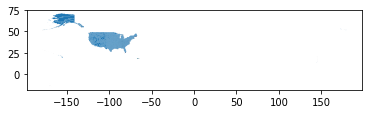

In [321]:
county_gdf.plot()

In [322]:
# write to geoJSON
county_gdf.to_file("JSON/county_polygons.json", driver="GeoJSON", encoding='utf-8')

#### Modify state geojson

In [523]:
# try loading state json and converting to dictionary
state_gpd = gpd.read_file('JSON/state_polygons.json')

In [524]:
state_gpd.head()

STATEFP   STATENS     AFFGEOID GEOID STUSPS            NAME LSAD  \
0      28  01779790  0400000US28    28     MS     Mississippi   00   
1      37  01027616  0400000US37    37     NC  North Carolina   00   
2      40  01102857  0400000US40    40     OK        Oklahoma   00   
3      51  01779803  0400000US51    51     VA        Virginia   00   
4      54  01779805  0400000US54    54     WV   West Virginia   00   

          ALAND        AWATER  Shape_Leng  Shape_Area  \
0  1.215335e+11  3.926920e+09   24.609526   11.885422   
1  1.259237e+11  1.346607e+10   41.263334   12.782199   
2  1.776629e+11  3.374588e+09   27.211118   18.005009   
3  1.022577e+11  8.528532e+09   33.614068   10.685784   
4  6.226647e+10  4.890285e+08   20.196988    6.493883   

                                            geometry  
0  MULTIPOLYGON (((-88.50297 30.21524, -88.49176 ...  
1  MULTIPOLYGON (((-75.72681 35.93585, -75.71827 ...  
2  POLYGON ((-103.00257 36.52659, -103.00220 36.6...  
3  MULTIPOLYGON (((-75.74241 37.80836, -75.74151 ...  
4  POLYGON ((-82.64320 38.16910, -82.64300 38.169...

In [531]:
# try loading state json and converting to dictionary
state_polygons = state_gpd.to_dict(orient='records')

In [532]:
len(state_polygons)

55

In [539]:
type(missing_df['State_FIPS'][0])

numpy.int64

In [540]:
type(state_polygons[0]["STATEFP"])

str

In [533]:
state_polygons[0]

{'STATEFP': '28',
 'STATENS': '01779790',
 'AFFGEOID': '0400000US28',
 'GEOID': '28',
 'STUSPS': 'MS',
 'NAME': 'Mississippi',
 'LSAD': '00',
 'ALAND': 121533519481.0,
 'AWATER': 3926919758.0,
 'Shape_Leng': 24.6095260955,
 'Shape_Area': 11.8854223509,
 'geometry': <shapely.geometry.multipolygon.MultiPolygon at 0x222490b4c88>}

In [543]:
## Create state array
state_poly_array = []
## for each state in state_centroids...
i = 0
while i < len(state_polygons):
    state_poly_dict = {}
    state_poly_dict["type"] = "Feature"
    state_poly_dict["name"] = state_polygons[i]["NAME"]
    state_poly_dict["name_abbr"] = state_polygons[i]["STUSPS"]
    state_poly_dict["state_FIPS"] = state_polygons[i]["STATEFP"]
    state_poly_dict["properties"] = {}
    missing_array = []
    j = 0
    while j < len(missing_df):
        # check if state_fips matches
        if missing_df['State_FIPS'][j] == int(state_polygons[i]["STATEFP"]):
            missing_dict = {}
            for item in missing_header:
                missing_dict[item] = str(missing_df[item][j])
            # append dictionary to missing array
            missing_array.append(missing_dict)
        # increment j
        j += 1
    state_poly_dict["properties"]['missing'] = missing_array     
    
    unclaimed_array = []
    k = 0
    while k < len(unclaimed_df):
        # check if state_fips matches
        if unclaimed_df['State_FIPS'][k] == int(state_polygons[i]["STATEFP"]):
            unclaimed_dict = {}
            for item in unclaimed_header:
                unclaimed_dict[item] = str(unclaimed_df[item][k])
            # append dictionary to unclaimed array
            unclaimed_array.append(unclaimed_dict)
        # increment k
        k += 1
    state_poly_dict["properties"]['unclaimed'] = unclaimed_array
    
    unidentified_array = []
    l = 0
    while l < len(unidentified_df):
        # check if state_fips matches
        if unidentified_df['State_FIPS'][l] == int(state_polygons[i]["STATEFP"]):
            unidentified_dict = {}
            for item in unidentified_header:
                unidentified_dict[item] = str(unidentified_df[item][l])
            # append dictionary to unclaimed array
            unidentified_array.append(unidentified_dict)
        # increment l
        l += 1
    state_poly_dict["properties"]['unidentified'] = unidentified_array
    
    state_poly_dict["properties"]['filtered'] = []
    ## set geometry
    state_poly_dict["geometry"] = state_polygons[i]["geometry"]
#     state_poly_dict["geometry"]["type"] = "Point"
#     state_poly_dict["geometry"]["coordinates"] = [state_centroids_v2_df['Lon_dd'][i], state_centroids_v2_df['Lat_dd'][i]]
    ## append state dictionary to array
    state_poly_array.append(state_poly_dict)
    # test statement
    print("added state", str(i+1), "of", len(state_polygons))
    # increment interator
    i += 1
# state_poly_array

added state 1 of 55
added state 2 of 55
added state 3 of 55
added state 4 of 55
added state 5 of 55
added state 6 of 55
added state 7 of 55
added state 8 of 55
added state 9 of 55
added state 10 of 55
added state 11 of 55
added state 12 of 55
added state 13 of 55
added state 14 of 55
added state 15 of 55
added state 16 of 55
added state 17 of 55
added state 18 of 55
added state 19 of 55
added state 20 of 55
added state 21 of 55
added state 22 of 55
added state 23 of 55
added state 24 of 55
added state 25 of 55
added state 26 of 55
added state 27 of 55
added state 28 of 55
added state 29 of 55
added state 30 of 55
added state 31 of 55
added state 32 of 55
added state 33 of 55
added state 34 of 55
added state 35 of 55
added state 36 of 55
added state 37 of 55
added state 38 of 55
added state 39 of 55
added state 40 of 55
added state 41 of 55
added state 42 of 55
added state 43 of 55
added state 44 of 55
added state 45 of 55
added state 46 of 55
added state 47 of 55
added state 48 of 55
a

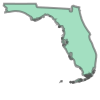

In [548]:
# check item in array
# len(state_poly_array)
# state_poly_array[9]['properties']['unclaimed'][0]
state_poly_array[9]['geometry']

In [549]:
# Create FeatureCollection
state_poly_feature_collection = {}
state_poly_feature_collection["type"] = "FeatureCollection"
state_poly_feature_collection["features"] = state_poly_array
# state_poly_feature_collection

In [550]:
# Convert FeatureCollection to JSON format
state_poly_geojson = geojson.dumps(state_poly_feature_collection)
# check type to make sure conversion was sucessful
print(type(state_poly_geojson))

<class 'str'>


In [551]:
# Save JSON-formatted FeatureCollection as JSON file
# Save as new json file
with open('JSON/state_poly_geojson.json', 'w', encoding='utf-8') as json_file:
    json_file.write(state_poly_geojson)